# WGAN

In this notebook, we'll walk through the steps required to train your own Wasserstein GAN on the CelebA faces dataset

The code has been adapted from the excellent [WGAN-GP tutorial](https://keras.io/examples/generative/wgan_gp/) created by Aakash Kumar Nain, available on the Keras website.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

from utils import display, sample_batch

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 1000#200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Cargar el archivo .npy
malware_data = np.load("./data/dataset_malware.npy")

# Revisamos normalización
print("Shape del dataset:", malware_data.shape)
print("Min:", malware_data.min(), "Max:", malware_data.max())

Shape del dataset: (584, 32, 32, 1)
Min: -1.0 Max: 1.0


In [4]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


#train = train_data.map(lambda x: preprocess(x))

# Creamos un dataset de TensorFlow
train_data = tf.data.Dataset.from_tensor_slices(malware_data) # Creamos un objeto Dataset pa partir del tensor en malware_data
train_data = train_data.shuffle(buffer_size=malware_data.shape[0], seed=42) # Mezclamos aleatoriamente los elementos del Dataset.
# Agrupamos los datos en lotes (batches) del tamaño BATCH_SIZE. 
# prefetch prepara el siguiente batch (al usar AUTOTUNE se al sistema elegir cuantos preparar según los recursos del sistema) durante el entrenamiento.
train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 
train = train_data

In [5]:
# Show some faces from the training set
train_sample = sample_batch(train)

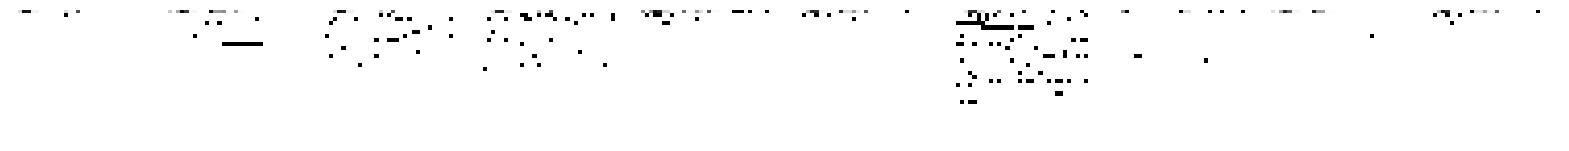

In [6]:
display(train_sample, cmap="gray_r")

## 2. Build the WGAN-GP <a name="build"></a>

In [7]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(32, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 1)        │         2,049 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,625 (650.88 KB)

 Trainable params: 166,625 (650.88 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │     1,048,576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 1)      │         2,049 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,675,649 (14.02 MB)

 Trainable params: 3,673,857 (14.01 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [9]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [10]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [11]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt.weights.h5")

## 3. Train the GAN <a name="train"></a>

In [12]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim, freq=5):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.freq = freq
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/generated_img_%03d.png" % (epoch),
                cmap="gray_r",
            )

In [14]:
# Ejemplo: si tu generador recibe un vector latente Z_DIM
generator.build((None, Z_DIM))

# Ejemplo: si tu discriminador recibe imágenes de 28x28x1
critic.build((None, 32, 32, 1))

wgangp.build((None, Z_DIM))  # si tu GAN también está en una clase Model

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 681ms/step - c_gp: 0.7918 - c_loss: 7.6293 - c_wass_loss: -0.2888 - g_loss: -0.0922
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - c_gp: 0.7224 - c_loss: 6.0273 - c_wass_loss: -1.1971 - g_loss: -0.3568
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - c_gp: 0.5793 - c_loss: 2.6579 - c_wass_loss: -3.1347 - g_loss: -1.3924
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.3102 - c_loss: -3.1756 - c_wass_loss: -6.2779 - g_loss: -4.8424
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - c_gp: 0.0712 - c_loss: -8.9147 - c_wass_loss: -9.6270 - g_loss: -10.5067
Saved to ./output/generated_img_004.png


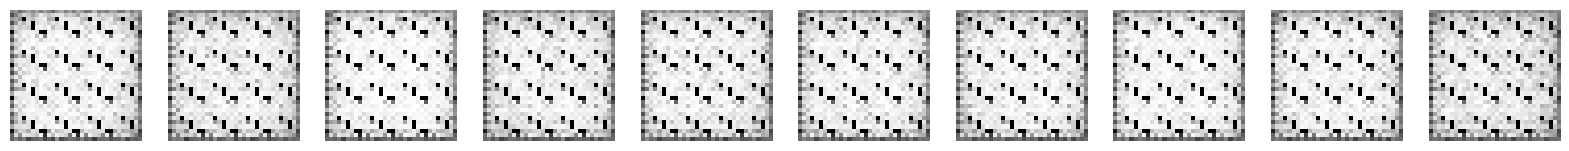

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step - c_gp: 0.0519 - c_loss: -9.5170 - c_wass_loss: -10.0358 - g_loss: -11.5234
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - c_gp: 0.0597 - c_loss: -13.0066 - c_wass_loss: -13.6036 - g_loss: -18.9670
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - c_gp: 0.1950 - c_loss: -14.3291 - c_wass_loss: -16.2791 - g_loss: -20.9470
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.2435 - c_loss: -15.8306 - c_wass_loss: -18.2653 - g_loss: -18.7846
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.2894 - c_loss: -17.3392 - c_wass_loss: -20.2334 - g_loss: -15.7428
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - c_gp: 0.3368 - c_loss: -18.4380 - c_wass_loss: -21.8060 - g_loss: -13.0344
Saved to ./output/generated_img_009.png


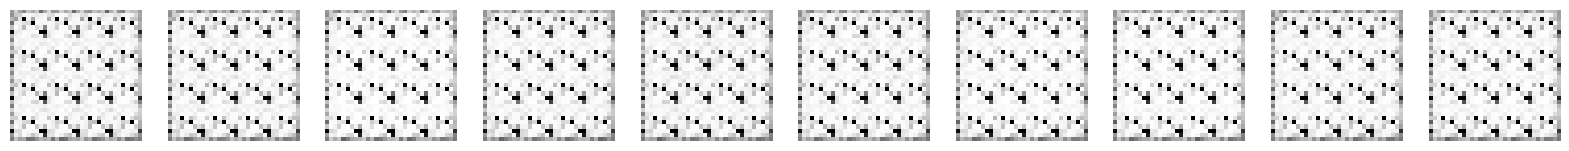

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 776ms/step - c_gp: 0.3422 - c_loss: -18.2020 - c_wass_loss: -21.6236 - g_loss: -12.9444
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.3166 - c_loss: -17.4115 - c_wass_loss: -20.5773 - g_loss: -12.2136
Epoch 12/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.3979 - c_loss: -20.5791 - c_wass_loss: -24.5585 - g_loss: -6.9199
Epoch 13/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - c_gp: 0.5553 - c_loss: -23.0198 - c_wass_loss: -28.5730 - g_loss: -0.5675
Epoch 14/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - c_gp: 0.7134 - c_loss: -24.6225 - c_wass_loss: -31.7561 - g_loss: 5.3080
Epoch 15/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_gp: 0.8672 - c_loss: -25.3990 - c_wass_loss: -34.0709 - g_loss: 8.9921
Saved to ./output/generated_img_014.png


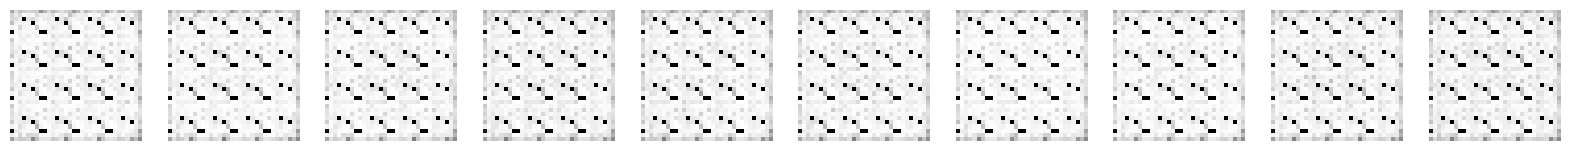

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step - c_gp: 0.8721 - c_loss: -25.5239 - c_wass_loss: -34.2451 - g_loss: 9.5494
Epoch 16/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.8948 - c_loss: -26.2626 - c_wass_loss: -35.2105 - g_loss: 12.2386
Epoch 17/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - c_gp: 1.0899 - c_loss: -25.2005 - c_wass_loss: -36.0992 - g_loss: 12.8882
Epoch 18/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.9962 - c_loss: -25.9253 - c_wass_loss: -35.8873 - g_loss: 12.9525
Epoch 19/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - c_gp: 1.0253 - c_loss: -26.1884 - c_wass_loss: -36.4417 - g_loss: 13.4702
Epoch 20/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - c_gp: 0.9809 - c_loss: -26.6560 - c_wass_loss: -36.4653 - g_loss: 13.3635
Saved to ./output/generated_img_019.png


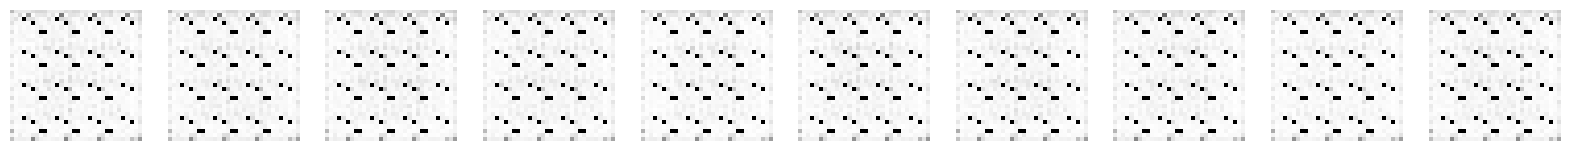

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 741ms/step - c_gp: 0.8832 - c_loss: -27.2420 - c_wass_loss: -36.0738 - g_loss: 13.5132
Epoch 21/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - c_gp: 1.1035 - c_loss: -26.7680 - c_wass_loss: -37.8026 - g_loss: 14.6464
Epoch 22/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - c_gp: 1.0504 - c_loss: -27.0201 - c_wass_loss: -37.5238 - g_loss: 15.0907
Epoch 23/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - c_gp: 1.2398 - c_loss: -25.4459 - c_wass_loss: -37.8438 - g_loss: 15.6402
Epoch 24/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - c_gp: 1.0828 - c_loss: -26.4124 - c_wass_loss: -37.2402 - g_loss: 15.3438
Epoch 25/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - c_gp: 0.9897 - c_loss: -27.8765 - c_wass_loss: -37.7732 - g_loss: 15.7082
Saved to ./output/generated_img_024.png


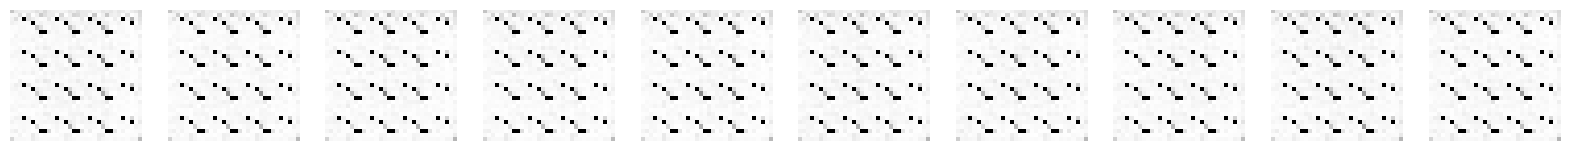

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step - c_gp: 0.9791 - c_loss: -28.4606 - c_wass_loss: -38.2513 - g_loss: 15.8588
Epoch 26/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 646ms/step - c_gp: 1.2409 - c_loss: -26.8631 - c_wass_loss: -39.2722 - g_loss: 16.6407
Epoch 27/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - c_gp: 1.0586 - c_loss: -27.9147 - c_wass_loss: -38.5011 - g_loss: 16.4877
Epoch 28/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 1.0451 - c_loss: -27.8737 - c_wass_loss: -38.3252 - g_loss: 16.6329
Epoch 29/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.9917 - c_loss: -29.1423 - c_wass_loss: -39.0590 - g_loss: 17.4888
Epoch 30/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - c_gp: 1.1010 - c_loss: -27.8926 - c_wass_loss: -38.9023 - g_loss: 17.0178
Saved to ./output/generated_img_029.png


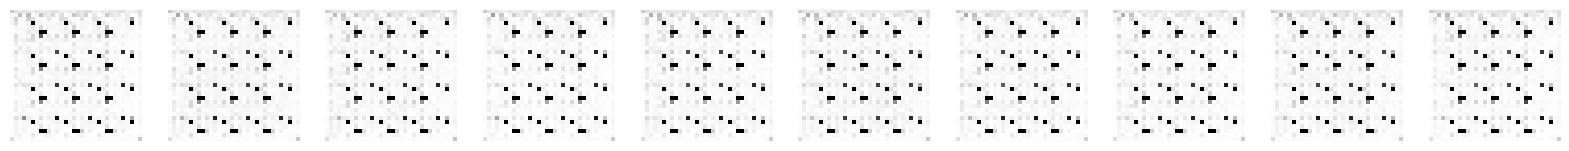

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 750ms/step - c_gp: 1.1167 - c_loss: -27.8057 - c_wass_loss: -38.9724 - g_loss: 16.7352
Epoch 31/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - c_gp: 0.8197 - c_loss: -21.2522 - c_wass_loss: -29.4492 - g_loss: 8.8307 
Epoch 32/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step - c_gp: 0.7320 - c_loss: -20.2133 - c_wass_loss: -27.5337 - g_loss: 6.4982
Epoch 33/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - c_gp: 0.6106 - c_loss: -17.6290 - c_wass_loss: -23.7352 - g_loss: 4.9393
Epoch 34/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - c_gp: 0.4529 - c_loss: -14.1904 - c_wass_loss: -18.7198 - g_loss: 0.3553
Epoch 35/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - c_gp: 0.4754 - c_loss: -14.6723 - c_wass_loss: -19.4258 - g_loss: 0.9696
Saved to ./output/generated_img_034.png


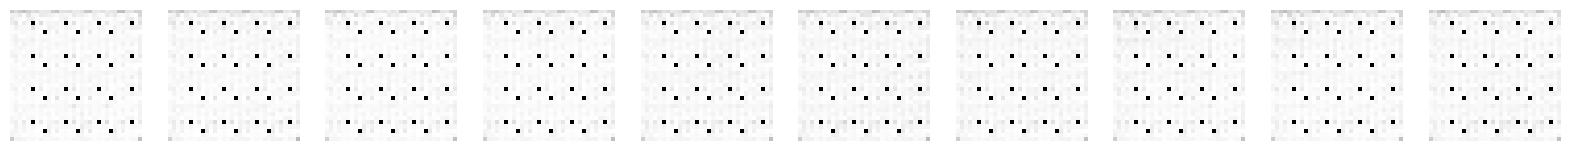

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 759ms/step - c_gp: 0.5026 - c_loss: -14.5526 - c_wass_loss: -19.5789 - g_loss: 1.3370
Epoch 36/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - c_gp: 0.4733 - c_loss: -15.2991 - c_wass_loss: -20.0317 - g_loss: 2.9690
Epoch 37/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - c_gp: 0.4287 - c_loss: -15.7563 - c_wass_loss: -20.0433 - g_loss: 4.7288
Epoch 38/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step - c_gp: 0.5984 - c_loss: -15.2299 - c_wass_loss: -21.2140 - g_loss: 6.0317
Epoch 39/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - c_gp: 0.4712 - c_loss: -16.1452 - c_wass_loss: -20.8575 - g_loss: 6.4853
Epoch 40/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - c_gp: 0.5282 - c_loss: -16.2233 - c_wass_loss: -21.5051 - g_loss: 7.3670
Saved to ./output/generated_img_039.png


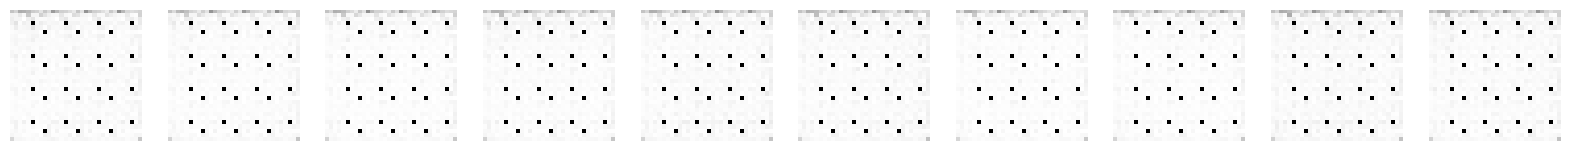

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 960ms/step - c_gp: 0.5331 - c_loss: -16.2320 - c_wass_loss: -21.5626 - g_loss: 7.4864
Epoch 41/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step - c_gp: 0.4844 - c_loss: -16.6351 - c_wass_loss: -21.4794 - g_loss: 7.4284
Epoch 42/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - c_gp: 0.5577 - c_loss: -16.7193 - c_wass_loss: -22.2961 - g_loss: 7.9160
Epoch 43/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step - c_gp: 0.5573 - c_loss: -16.2668 - c_wass_loss: -21.8394 - g_loss: 7.4002
Epoch 44/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - c_gp: 0.5144 - c_loss: -16.2886 - c_wass_loss: -21.4329 - g_loss: 7.3681
Epoch 45/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - c_gp: 0.3933 - c_loss: -13.1947 - c_wass_loss: -17.1276 - g_loss: 3.7134
Saved to ./output/generated_img_044.png


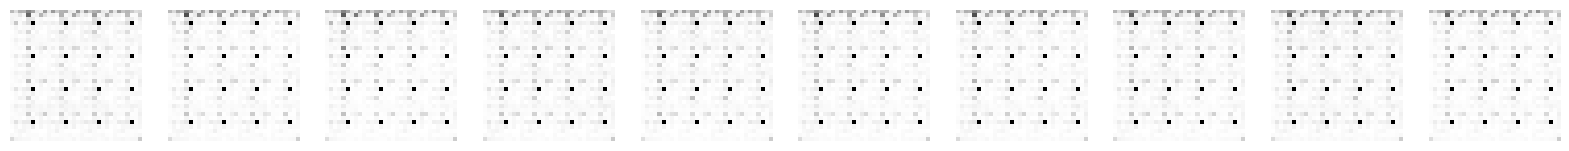

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - c_gp: 0.3618 - c_loss: -11.9425 - c_wass_loss: -15.5608 - g_loss: 2.6572   
Epoch 46/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 669ms/step - c_gp: 0.2378 - c_loss: -10.3849 - c_wass_loss: -12.7630 - g_loss: -1.2372
Epoch 47/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - c_gp: 0.2642 - c_loss: -10.6267 - c_wass_loss: -13.2684 - g_loss: -0.0483
Epoch 48/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 620ms/step - c_gp: 0.3488 - c_loss: -10.4862 - c_wass_loss: -13.9740 - g_loss: 1.4541
Epoch 49/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 704ms/step - c_gp: 0.2895 - c_loss: -11.0296 - c_wass_loss: -13.9250 - g_loss: 2.6584
Epoch 50/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - c_gp: 0.3033 - c_loss: -11.3133 - c_wass_loss: -14.3462 - g_loss: 3.2594
Saved to ./output/generated_img_049.png


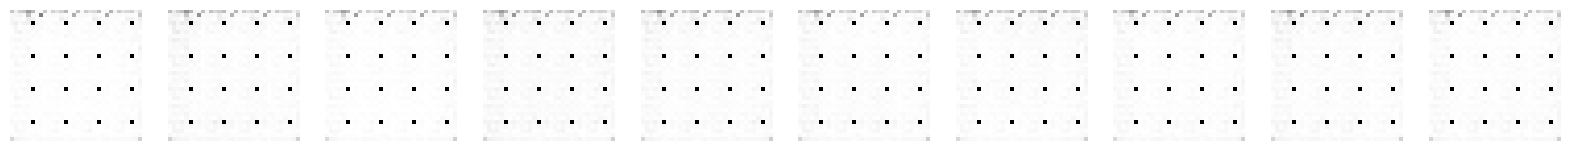

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 851ms/step - c_gp: 0.2907 - c_loss: -11.3681 - c_wass_loss: -14.2752 - g_loss: 3.3933
Epoch 51/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step - c_gp: 0.3267 - c_loss: -11.3645 - c_wass_loss: -14.6313 - g_loss: 3.9890
Epoch 52/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 689ms/step - c_gp: 0.2888 - c_loss: -11.4937 - c_wass_loss: -14.3814 - g_loss: 3.9640
Epoch 53/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.3264 - c_loss: -11.4079 - c_wass_loss: -14.6716 - g_loss: 4.1685
Epoch 54/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - c_gp: 0.2684 - c_loss: -11.6423 - c_wass_loss: -14.3268 - g_loss: 3.9064
Epoch 55/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - c_gp: 0.3462 - c_loss: -11.1559 - c_wass_loss: -14.6179 - g_loss: 3.9338
Saved to ./output/generated_img_054.png


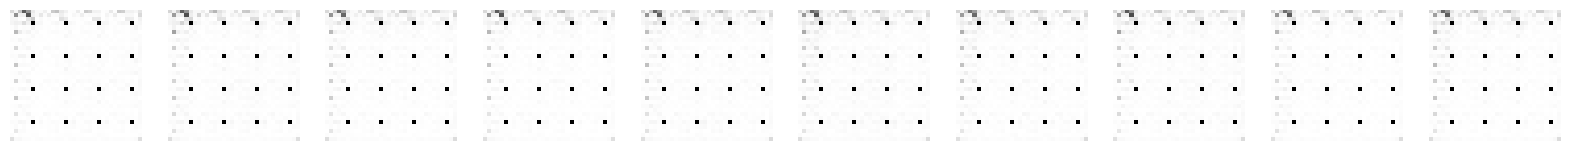

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 741ms/step - c_gp: 0.3486 - c_loss: -10.9230 - c_wass_loss: -14.4094 - g_loss: 3.7726
Epoch 56/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - c_gp: 0.3335 - c_loss: -11.1453 - c_wass_loss: -14.4804 - g_loss: 3.7450
Epoch 57/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.3448 - c_loss: -11.1104 - c_wass_loss: -14.5588 - g_loss: 3.6207
Epoch 58/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.2814 - c_loss: -11.3900 - c_wass_loss: -14.2038 - g_loss: 3.1676
Epoch 59/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.2787 - c_loss: -11.1996 - c_wass_loss: -13.9866 - g_loss: 3.6068
Epoch 60/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - c_gp: 0.2677 - c_loss: -11.7436 - c_wass_loss: -14.4208 - g_loss: 3.0320
Saved to ./output/generated_img_059.png


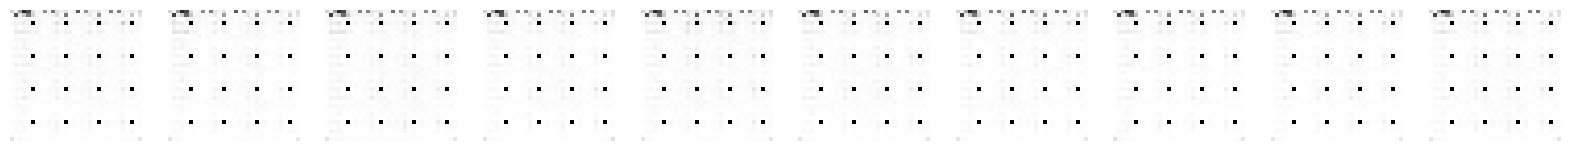

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step - c_gp: 0.2604 - c_loss: -11.8504 - c_wass_loss: -14.4545 - g_loss: 3.0346
Epoch 61/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.3624 - c_loss: -10.9005 - c_wass_loss: -14.5241 - g_loss: 3.8301
Epoch 62/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step - c_gp: 0.3010 - c_loss: -11.7895 - c_wass_loss: -14.7991 - g_loss: 3.6347
Epoch 63/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.2919 - c_loss: -11.7457 - c_wass_loss: -14.6651 - g_loss: 3.4950
Epoch 64/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - c_gp: 0.3264 - c_loss: -11.4550 - c_wass_loss: -14.7192 - g_loss: 3.8237
Epoch 65/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - c_gp: 0.2812 - c_loss: -11.5184 - c_wass_loss: -14.3306 - g_loss: 3.4625
Saved to ./output/generated_img_064.png


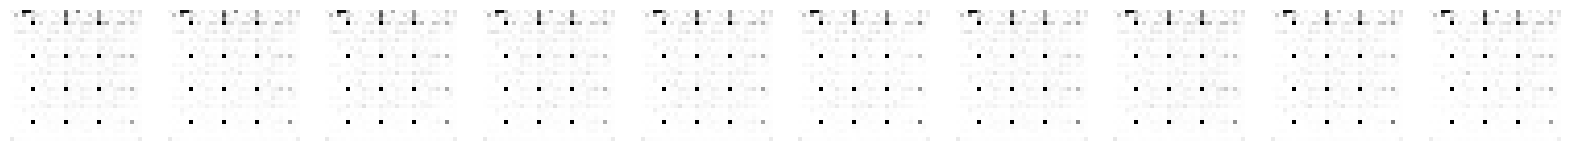

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 786ms/step - c_gp: 0.2781 - c_loss: -11.3285 - c_wass_loss: -14.1095 - g_loss: 3.4382
Epoch 66/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - c_gp: 0.1941 - c_loss: -6.9156 - c_wass_loss: -8.8564 - g_loss: -2.0480
Epoch 67/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0176 - c_loss: -1.1318 - c_wass_loss: -1.3083 - g_loss: -11.6744
Epoch 68/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - c_gp: 0.0064 - c_loss: -0.8995 - c_wass_loss: -0.9631 - g_loss: -13.8516
Epoch 69/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.0038 - c_loss: -0.5015 - c_wass_loss: -0.5399 - g_loss: -14.7383
Epoch 70/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - c_gp: 0.0025 - c_loss: -0.4434 - c_wass_loss: -0.4682 - g_loss: -15.2585
Saved to ./output/generated_img_069.png


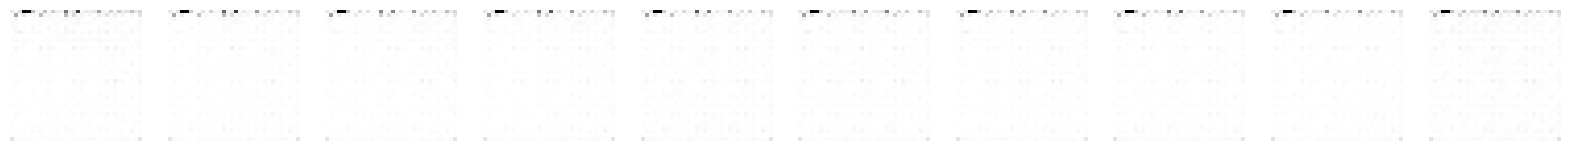

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 768ms/step - c_gp: 0.0024 - c_loss: -0.4789 - c_wass_loss: -0.5027 - g_loss: -15.2669
Epoch 71/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0030 - c_loss: -0.4822 - c_wass_loss: -0.5123 - g_loss: -14.1945
Epoch 72/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - c_gp: 0.0019 - c_loss: -0.3215 - c_wass_loss: -0.3409 - g_loss: -13.2293
Epoch 73/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0028 - c_loss: -0.5766 - c_wass_loss: -0.6046 - g_loss: -12.4277
Epoch 74/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0019 - c_loss: -0.4635 - c_wass_loss: -0.4822 - g_loss: -10.6382
Epoch 75/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - c_gp: 0.0015 - c_loss: -0.6086 - c_wass_loss: -0.6238 - g_loss: -8.9156
Saved to ./output/generated_img_074.png


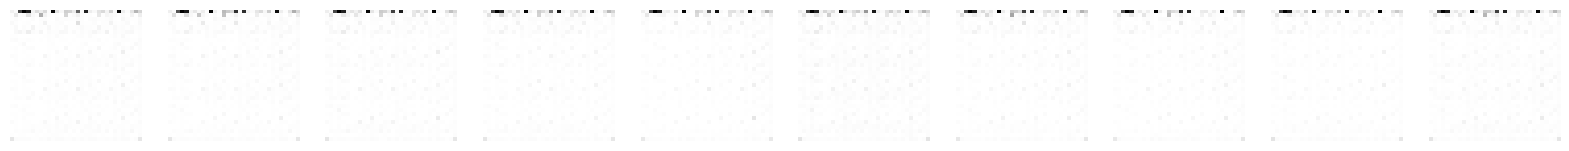

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step - c_gp: 0.0016 - c_loss: -0.7197 - c_wass_loss: -0.7360 - g_loss: -8.5863
Epoch 76/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.0018 - c_loss: -0.9984 - c_wass_loss: -1.0161 - g_loss: -7.4051
Epoch 77/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0024 - c_loss: -0.2766 - c_wass_loss: -0.3011 - g_loss: -9.2627
Epoch 78/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - c_gp: 0.0034 - c_loss: -1.1372 - c_wass_loss: -1.1711 - g_loss: -15.9972
Epoch 79/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step - c_gp: 0.0125 - c_loss: -2.6455 - c_wass_loss: -2.7709 - g_loss: -17.6017
Epoch 80/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - c_gp: 0.0048 - c_loss: -0.9201 - c_wass_loss: -0.9678 - g_loss: -16.1650
Saved to ./output/generated_img_079.png


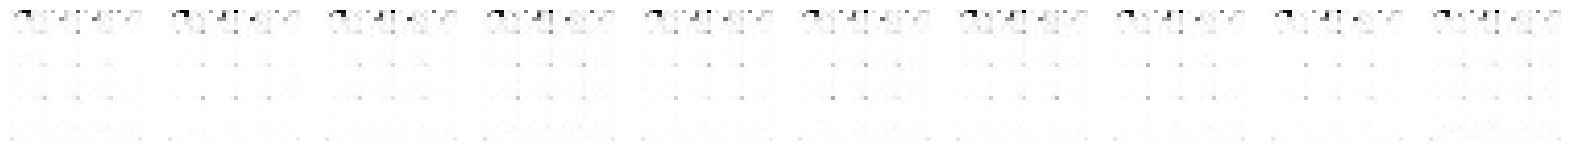

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step - c_gp: 0.0037 - c_loss: -0.8153 - c_wass_loss: -0.8521 - g_loss: -16.2278
Epoch 81/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - c_gp: 0.0017 - c_loss: -0.4504 - c_wass_loss: -0.4675 - g_loss: -17.4823
Epoch 82/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0022 - c_loss: -0.2953 - c_wass_loss: -0.3175 - g_loss: -19.2685
Epoch 83/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0015 - c_loss: -0.3582 - c_wass_loss: -0.3730 - g_loss: -19.4150
Epoch 84/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0017 - c_loss: -0.4490 - c_wass_loss: -0.4661 - g_loss: -19.2607
Epoch 85/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - c_gp: 0.0017 - c_loss: -0.3562 - c_wass_loss: -0.3733 - g_loss: -18.7675
Saved to ./output/generated_img_084.png


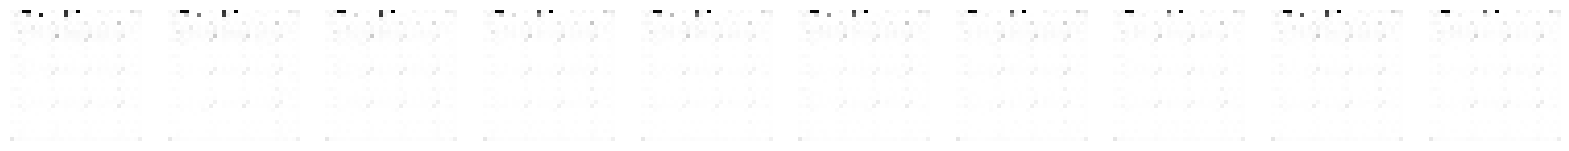

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 741ms/step - c_gp: 0.0016 - c_loss: -0.2771 - c_wass_loss: -0.2935 - g_loss: -18.6761
Epoch 86/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0022 - c_loss: -0.6576 - c_wass_loss: -0.6792 - g_loss: -17.9047
Epoch 87/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0034 - c_loss: -0.6885 - c_wass_loss: -0.7227 - g_loss: -17.8450
Epoch 88/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0058 - c_loss: -0.8493 - c_wass_loss: -0.9076 - g_loss: -16.7708
Epoch 89/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - c_gp: 0.0054 - c_loss: -0.8014 - c_wass_loss: -0.8555 - g_loss: -13.8541
Epoch 90/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - c_gp: 0.0057 - c_loss: -1.0328 - c_wass_loss: -1.0900 - g_loss: -14.4336
Saved to ./output/generated_img_089.png


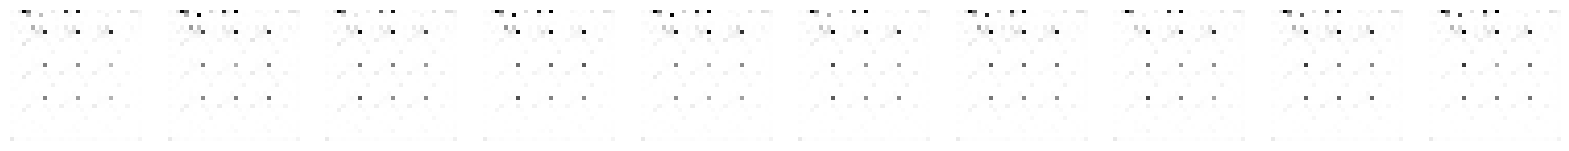

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 750ms/step - c_gp: 0.0074 - c_loss: -0.9480 - c_wass_loss: -1.0217 - g_loss: -14.2535
Epoch 91/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0087 - c_loss: -0.6760 - c_wass_loss: -0.7630 - g_loss: -15.8415
Epoch 92/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0235 - c_loss: -2.5132 - c_wass_loss: -2.7485 - g_loss: -17.8617
Epoch 93/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0262 - c_loss: -2.0460 - c_wass_loss: -2.3079 - g_loss: -15.8803
Epoch 94/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0059 - c_loss: -0.5469 - c_wass_loss: -0.6056 - g_loss: -13.0026
Epoch 95/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - c_gp: 0.0022 - c_loss: -0.4325 - c_wass_loss: -0.4547 - g_loss: -12.9125
Saved to ./output/generated_img_094.png


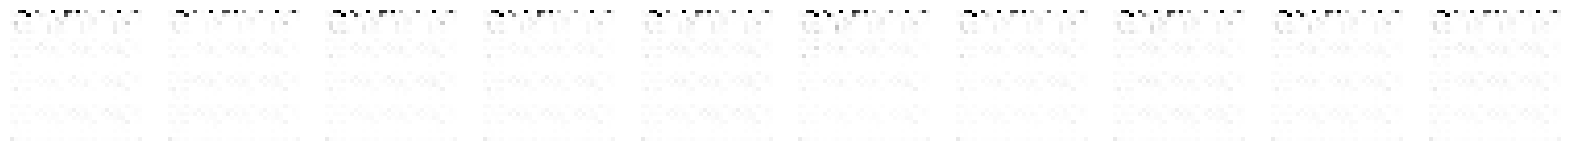

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 820ms/step - c_gp: 0.0019 - c_loss: -0.3656 - c_wass_loss: -0.3850 - g_loss: -13.0356
Epoch 96/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0020 - c_loss: -0.6151 - c_wass_loss: -0.6355 - g_loss: -14.3948
Epoch 97/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - c_gp: 0.0022 - c_loss: -0.7693 - c_wass_loss: -0.7916 - g_loss: -15.0579
Epoch 98/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0029 - c_loss: -0.8346 - c_wass_loss: -0.8638 - g_loss: -15.3967
Epoch 99/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - c_gp: 0.0032 - c_loss: -0.8135 - c_wass_loss: -0.8454 - g_loss: -16.3094
Epoch 100/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0032 - c_loss: -0.6478 - c_wass_loss: -0.6802 - g_loss: -16.0786
Saved to ./output/generated_img_099.png


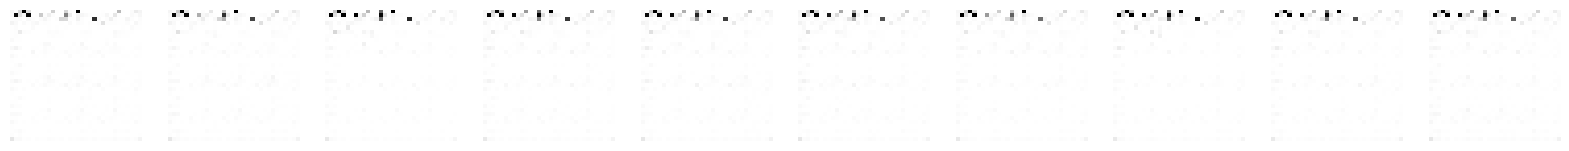

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - c_gp: 0.0032 - c_loss: -0.6229 - c_wass_loss: -0.6554 - g_loss: -15.9438
Epoch 101/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0047 - c_loss: -0.6323 - c_wass_loss: -0.6795 - g_loss: -14.0965
Epoch 102/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - c_gp: 0.0047 - c_loss: -0.7736 - c_wass_loss: -0.8210 - g_loss: -13.0860
Epoch 103/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0060 - c_loss: -0.5930 - c_wass_loss: -0.6532 - g_loss: -12.8404
Epoch 104/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0084 - c_loss: -1.7138 - c_wass_loss: -1.7981 - g_loss: -14.6240
Epoch 105/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - c_gp: 0.0119 - c_loss: -1.7047 - c_wass_loss: -1.8234 - g_loss: -13.6253
Saved to ./output/generated_img_104.png


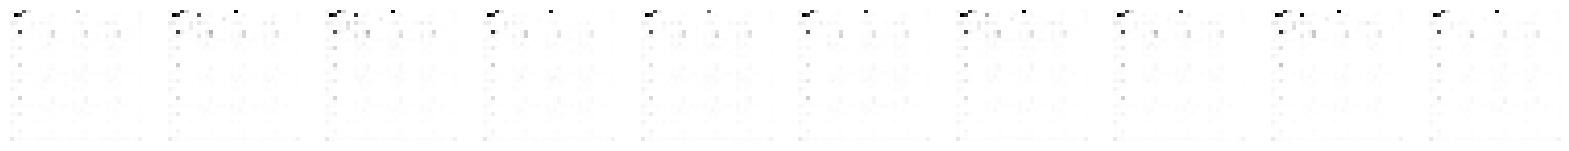

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step - c_gp: 0.0101 - c_loss: -1.4715 - c_wass_loss: -1.5722 - g_loss: -13.4936
Epoch 106/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0039 - c_loss: -0.9153 - c_wass_loss: -0.9542 - g_loss: -12.9251
Epoch 107/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0059 - c_loss: -1.0646 - c_wass_loss: -1.1239 - g_loss: -12.6523
Epoch 108/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - c_gp: 0.0083 - c_loss: -1.0988 - c_wass_loss: -1.1815 - g_loss: -11.9764
Epoch 109/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0063 - c_loss: -1.2631 - c_wass_loss: -1.3264 - g_loss: -13.7410
Epoch 110/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - c_gp: 0.0142 - c_loss: -1.8464 - c_wass_loss: -1.9879 - g_loss: -15.0332
Saved to ./output/generated_img_109.png


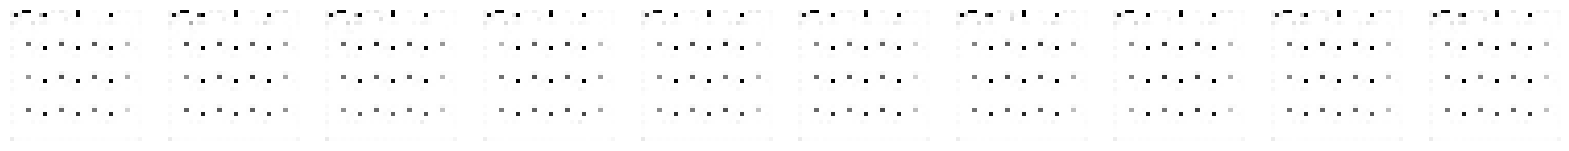

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 708ms/step - c_gp: 0.0163 - c_loss: -2.2697 - c_wass_loss: -2.4325 - g_loss: -14.8598
Epoch 111/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step - c_gp: 0.0387 - c_loss: -3.3845 - c_wass_loss: -3.7720 - g_loss: -14.5695
Epoch 112/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0275 - c_loss: -2.7084 - c_wass_loss: -2.9834 - g_loss: -14.0343
Epoch 113/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.0076 - c_loss: -1.0805 - c_wass_loss: -1.1563 - g_loss: -11.1442
Epoch 114/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0081 - c_loss: -0.8916 - c_wass_loss: -0.9729 - g_loss: -8.5274
Epoch 115/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - c_gp: 0.0098 - c_loss: -1.0002 - c_wass_loss: -1.0978 - g_loss: -6.9495
Saved to ./output/generated_img_114.png


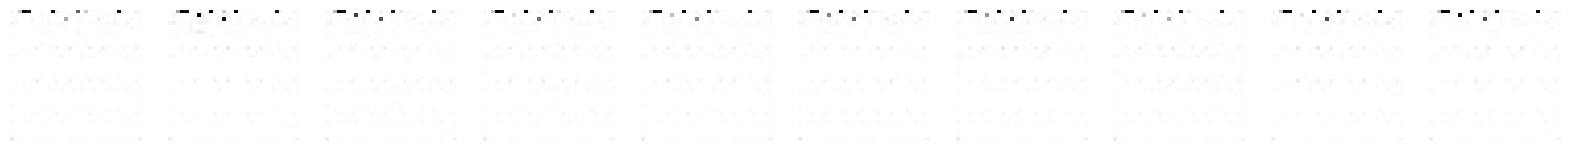

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 715ms/step - c_gp: 0.0100 - c_loss: -1.3104 - c_wass_loss: -1.4101 - g_loss: -6.6848
Epoch 116/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0128 - c_loss: -0.8670 - c_wass_loss: -0.9952 - g_loss: -4.1410
Epoch 117/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0190 - c_loss: -1.3590 - c_wass_loss: -1.5493 - g_loss: -3.9509
Epoch 118/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0190 - c_loss: -1.1361 - c_wass_loss: -1.3257 - g_loss: -5.4223
Epoch 119/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - c_gp: 0.0252 - c_loss: -1.4864 - c_wass_loss: -1.7379 - g_loss: -10.0492
Epoch 120/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - c_gp: 0.0247 - c_loss: -1.3655 - c_wass_loss: -1.6128 - g_loss: -13.0716
Saved to ./output/generated_img_119.png


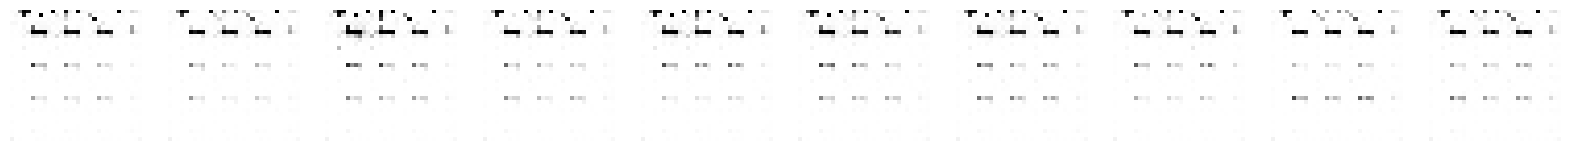

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step - c_gp: 0.0257 - c_loss: -1.3545 - c_wass_loss: -1.6110 - g_loss: -13.4535
Epoch 121/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0155 - c_loss: -2.1087 - c_wass_loss: -2.2640 - g_loss: -14.9728
Epoch 122/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - c_gp: 0.0132 - c_loss: -1.7317 - c_wass_loss: -1.8641 - g_loss: -15.6488
Epoch 123/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 589ms/step - c_gp: 0.0125 - c_loss: -1.6160 - c_wass_loss: -1.7406 - g_loss: -15.4890
Epoch 124/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.0051 - c_loss: -0.7219 - c_wass_loss: -0.7726 - g_loss: -14.8207
Epoch 125/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - c_gp: 0.0029 - c_loss: -0.6679 - c_wass_loss: -0.6965 - g_loss: -15.0353
Saved to ./output/generated_img_124.png


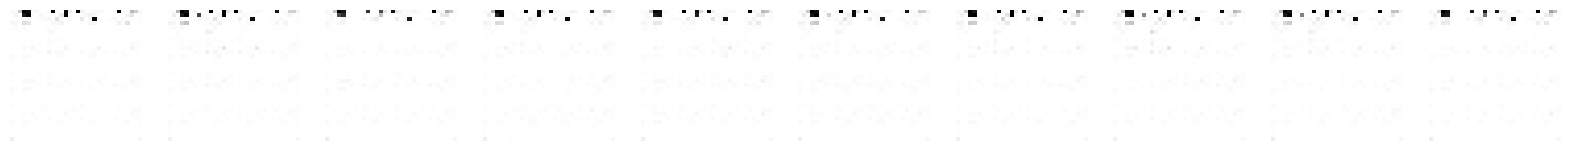

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step - c_gp: 0.0031 - c_loss: -0.8427 - c_wass_loss: -0.8741 - g_loss: -15.0432
Epoch 126/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0032 - c_loss: -0.6077 - c_wass_loss: -0.6394 - g_loss: -15.2537
Epoch 127/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0028 - c_loss: -0.7939 - c_wass_loss: -0.8217 - g_loss: -14.3291
Epoch 128/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - c_gp: 0.0027 - c_loss: -0.9281 - c_wass_loss: -0.9553 - g_loss: -12.9529
Epoch 129/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0044 - c_loss: -1.0432 - c_wass_loss: -1.0872 - g_loss: -11.8508
Epoch 130/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_gp: 0.0058 - c_loss: -0.6650 - c_wass_loss: -0.7228 - g_loss: -10.3784
Saved to ./output/generated_img_129.png


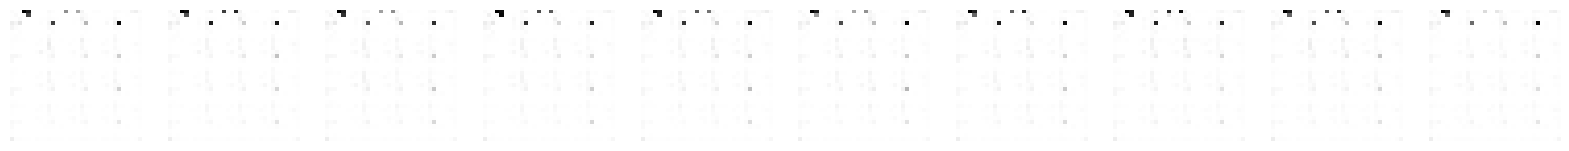

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 758ms/step - c_gp: 0.0065 - c_loss: -0.4890 - c_wass_loss: -0.5540 - g_loss: -10.2829
Epoch 131/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0070 - c_loss: -0.9095 - c_wass_loss: -0.9796 - g_loss: -9.4967
Epoch 132/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0124 - c_loss: -1.2964 - c_wass_loss: -1.4206 - g_loss: -10.2309
Epoch 133/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - c_gp: 0.0113 - c_loss: -0.9405 - c_wass_loss: -1.0530 - g_loss: -8.8905
Epoch 134/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - c_gp: 0.0090 - c_loss: -1.2365 - c_wass_loss: -1.3266 - g_loss: -9.3514
Epoch 135/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - c_gp: 0.0146 - c_loss: -1.4531 - c_wass_loss: -1.5988 - g_loss: -11.8911
Saved to ./output/generated_img_134.png


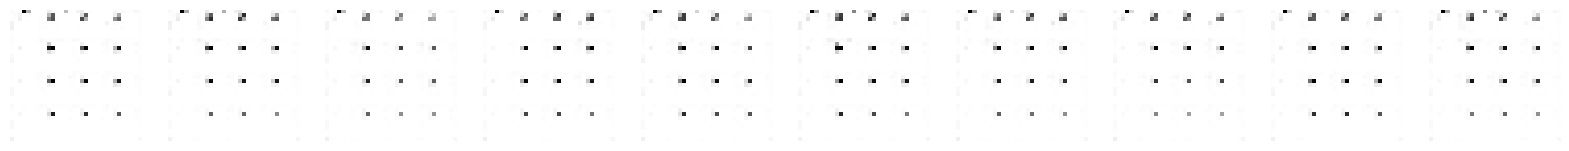

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - c_gp: 0.0172 - c_loss: -1.5023 - c_wass_loss: -1.6743 - g_loss: -12.1474
Epoch 136/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - c_gp: 0.0166 - c_loss: -2.0652 - c_wass_loss: -2.2315 - g_loss: -13.8210
Epoch 137/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0116 - c_loss: -1.5581 - c_wass_loss: -1.6739 - g_loss: -13.4858
Epoch 138/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0110 - c_loss: -1.3739 - c_wass_loss: -1.4836 - g_loss: -11.0831
Epoch 139/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0143 - c_loss: -1.4242 - c_wass_loss: -1.5670 - g_loss: -8.9400
Epoch 140/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - c_gp: 0.0184 - c_loss: -1.3562 - c_wass_loss: -1.5401 - g_loss: -7.0212
Saved to ./output/generated_img_139.png


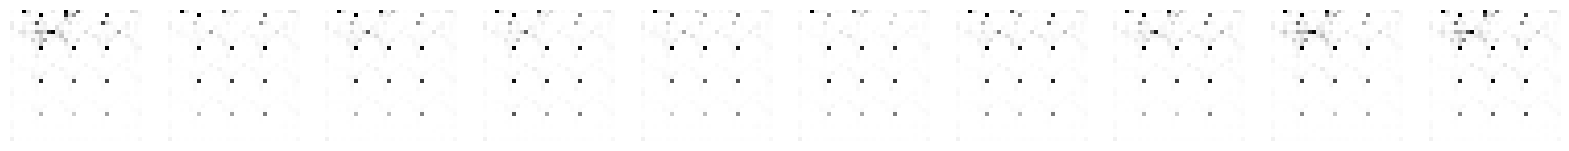

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step - c_gp: 0.0197 - c_loss: -1.2263 - c_wass_loss: -1.4230 - g_loss: -7.0694
Epoch 141/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0238 - c_loss: -1.2007 - c_wass_loss: -1.4392 - g_loss: -9.6948
Epoch 142/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0190 - c_loss: -1.2359 - c_wass_loss: -1.4255 - g_loss: -16.8859
Epoch 143/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - c_gp: 0.0298 - c_loss: -1.9758 - c_wass_loss: -2.2741 - g_loss: -21.7024
Epoch 144/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - c_gp: 0.0218 - c_loss: -1.9440 - c_wass_loss: -2.1624 - g_loss: -20.7830
Epoch 145/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - c_gp: 0.0130 - c_loss: -1.1396 - c_wass_loss: -1.2695 - g_loss: -19.2402
Saved to ./output/generated_img_144.png


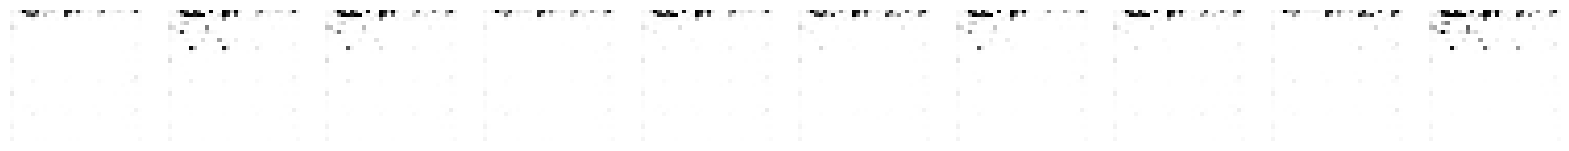

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 752ms/step - c_gp: 0.0111 - c_loss: -0.9976 - c_wass_loss: -1.1089 - g_loss: -19.1105
Epoch 146/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0076 - c_loss: -0.9917 - c_wass_loss: -1.0676 - g_loss: -18.0661
Epoch 147/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0046 - c_loss: -1.1011 - c_wass_loss: -1.1474 - g_loss: -15.6275
Epoch 148/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0037 - c_loss: -0.3919 - c_wass_loss: -0.4288 - g_loss: -13.9516
Epoch 149/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0033 - c_loss: -0.4297 - c_wass_loss: -0.4626 - g_loss: -12.4864
Epoch 150/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - c_gp: 0.0030 - c_loss: -0.6285 - c_wass_loss: -0.6586 - g_loss: -10.5115
Saved to ./output/generated_img_149.png


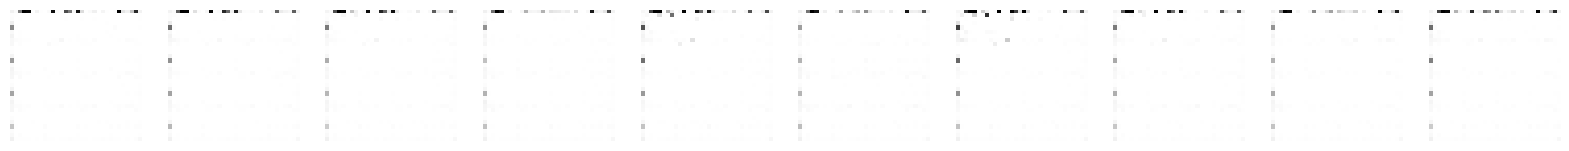

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - c_gp: 0.0032 - c_loss: -0.6108 - c_wass_loss: -0.6427 - g_loss: -10.1941
Epoch 151/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - c_gp: 0.0040 - c_loss: -0.9226 - c_wass_loss: -0.9630 - g_loss: -7.1894
Epoch 152/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0072 - c_loss: -0.9318 - c_wass_loss: -1.0039 - g_loss: -4.2471
Epoch 153/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step - c_gp: 0.0134 - c_loss: -0.8030 - c_wass_loss: -0.9368 - g_loss: -1.0023
Epoch 154/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0175 - c_loss: -1.1466 - c_wass_loss: -1.3219 - g_loss: -1.1079
Epoch 155/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - c_gp: 0.0175 - c_loss: -1.5115 - c_wass_loss: -1.6861 - g_loss: -6.4308
Saved to ./output/generated_img_154.png


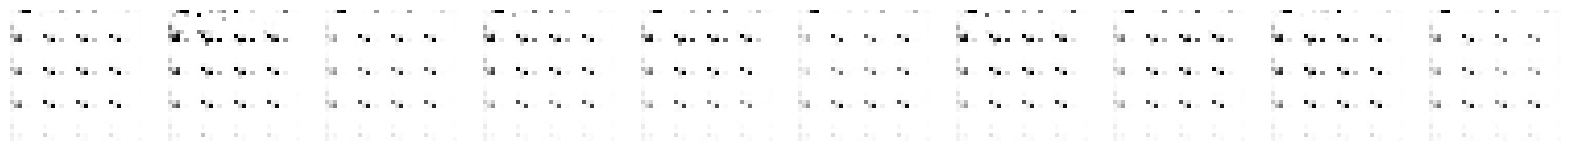

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 739ms/step - c_gp: 0.0186 - c_loss: -1.7810 - c_wass_loss: -1.9672 - g_loss: -7.1047
Epoch 156/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - c_gp: 0.0344 - c_loss: -2.8603 - c_wass_loss: -3.2048 - g_loss: -12.1315
Epoch 157/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0180 - c_loss: -1.2502 - c_wass_loss: -1.4302 - g_loss: -12.9444
Epoch 158/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0110 - c_loss: -0.7182 - c_wass_loss: -0.8277 - g_loss: -13.3995
Epoch 159/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0124 - c_loss: -0.4982 - c_wass_loss: -0.6217 - g_loss: -15.0027
Epoch 160/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0133 - c_loss: 0.2333 - c_wass_loss: 0.1003 - g_loss: -18.0026
Saved to ./output/generated_img_159.png


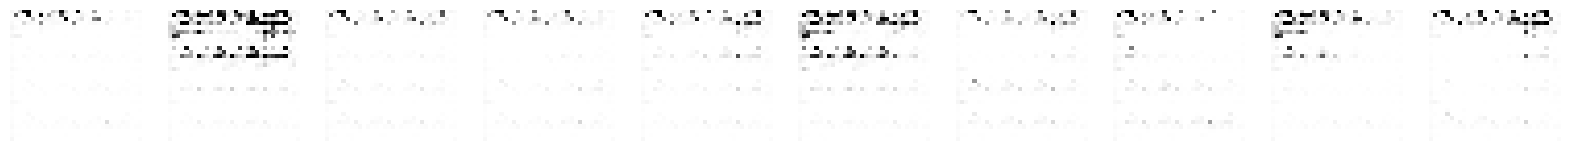

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step - c_gp: 0.0133 - c_loss: 0.1639 - c_wass_loss: 0.0306 - g_loss: -18.5887
Epoch 161/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0119 - c_loss: -0.6007 - c_wass_loss: -0.7193 - g_loss: -22.3982
Epoch 162/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0107 - c_loss: -1.0301 - c_wass_loss: -1.1375 - g_loss: -21.4960
Epoch 163/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0068 - c_loss: -1.4664 - c_wass_loss: -1.5342 - g_loss: -19.6977
Epoch 164/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0054 - c_loss: -0.8218 - c_wass_loss: -0.8755 - g_loss: -17.4302
Epoch 165/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - c_gp: 0.0034 - c_loss: -0.3815 - c_wass_loss: -0.4159 - g_loss: -15.5364
Saved to ./output/generated_img_164.png


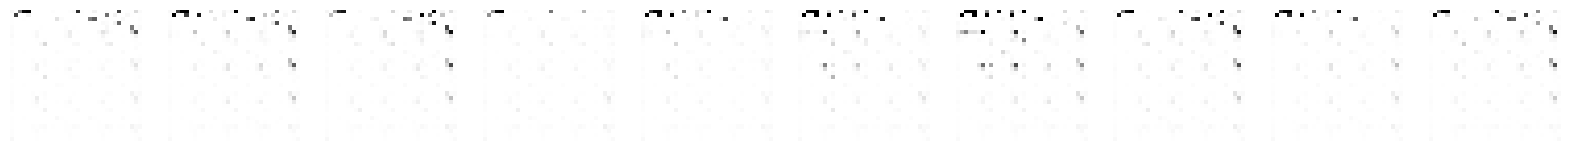

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step - c_gp: 0.0034 - c_loss: -0.2955 - c_wass_loss: -0.3293 - g_loss: -15.6995
Epoch 166/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step - c_gp: 0.0035 - c_loss: -0.1933 - c_wass_loss: -0.2281 - g_loss: -15.1606
Epoch 167/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - c_gp: 0.0028 - c_loss: -0.4455 - c_wass_loss: -0.4732 - g_loss: -17.1611
Epoch 168/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0034 - c_loss: -0.3887 - c_wass_loss: -0.4227 - g_loss: -18.8385
Epoch 169/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - c_gp: 0.0029 - c_loss: -0.3414 - c_wass_loss: -0.3701 - g_loss: -19.0582
Epoch 170/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0038 - c_loss: -0.5272 - c_wass_loss: -0.5653 - g_loss: -18.3666
Saved to ./output/generated_img_169.png


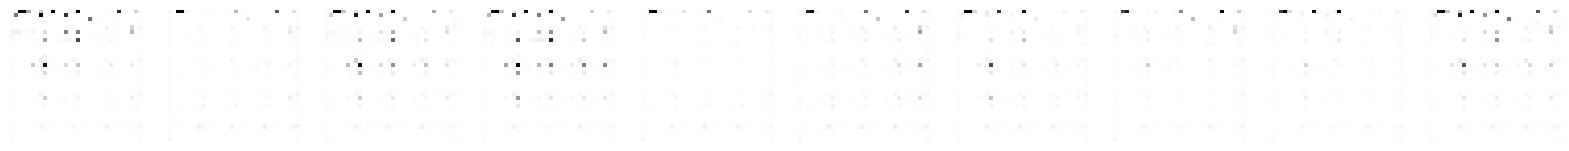

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - c_gp: 0.0041 - c_loss: -0.4727 - c_wass_loss: -0.5133 - g_loss: -18.4517
Epoch 171/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0038 - c_loss: -0.7356 - c_wass_loss: -0.7738 - g_loss: -16.5887
Epoch 172/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - c_gp: 0.0073 - c_loss: -0.8032 - c_wass_loss: -0.8767 - g_loss: -14.9057
Epoch 173/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0104 - c_loss: -0.6296 - c_wass_loss: -0.7336 - g_loss: -12.3231
Epoch 174/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - c_gp: 0.0194 - c_loss: -1.0062 - c_wass_loss: -1.2004 - g_loss: -9.7873 
Epoch 175/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - c_gp: 0.0214 - c_loss: -0.9221 - c_wass_loss: -1.1360 - g_loss: -10.6416
Saved to ./output/generated_img_174.png


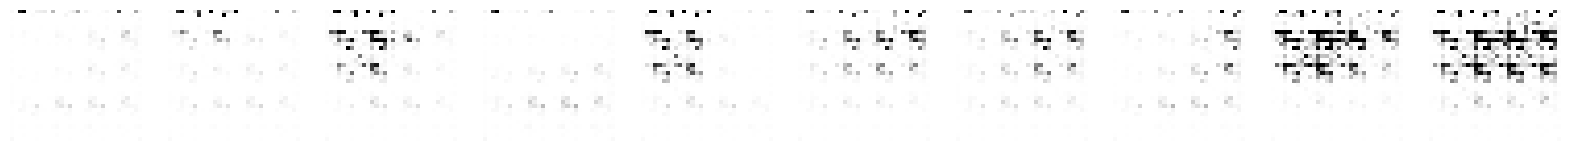

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step - c_gp: 0.0212 - c_loss: -0.9926 - c_wass_loss: -1.2047 - g_loss: -11.2566
Epoch 176/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0199 - c_loss: -1.0574 - c_wass_loss: -1.2567 - g_loss: -17.3842
Epoch 177/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - c_gp: 0.0211 - c_loss: -1.7552 - c_wass_loss: -1.9665 - g_loss: -19.0377
Epoch 178/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0190 - c_loss: -2.0186 - c_wass_loss: -2.2082 - g_loss: -16.8595
Epoch 179/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0070 - c_loss: -1.0393 - c_wass_loss: -1.1096 - g_loss: -15.7986
Epoch 180/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - c_gp: 0.0037 - c_loss: -0.5354 - c_wass_loss: -0.5721 - g_loss: -16.0972
Saved to ./output/generated_img_179.png


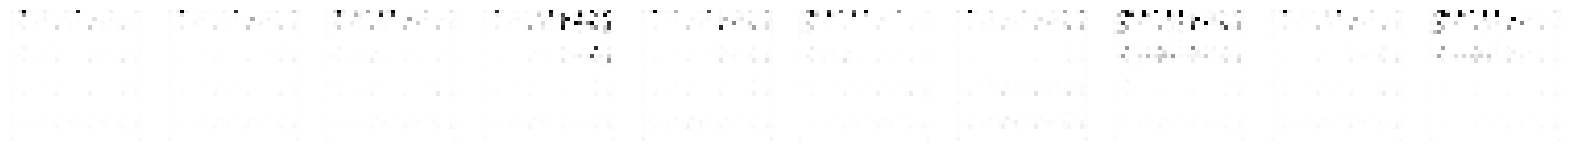

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 753ms/step - c_gp: 0.0038 - c_loss: -0.7069 - c_wass_loss: -0.7449 - g_loss: -16.1765
Epoch 181/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0046 - c_loss: -0.6558 - c_wass_loss: -0.7015 - g_loss: -16.1271
Epoch 182/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0033 - c_loss: -0.0825 - c_wass_loss: -0.1158 - g_loss: -15.3206
Epoch 183/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - c_gp: 0.0035 - c_loss: -0.3413 - c_wass_loss: -0.3763 - g_loss: -13.4775
Epoch 184/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - c_gp: 0.0034 - c_loss: -0.3311 - c_wass_loss: -0.3651 - g_loss: -12.1689
Epoch 185/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - c_gp: 0.0034 - c_loss: -0.4111 - c_wass_loss: -0.4447 - g_loss: -11.2591
Saved to ./output/generated_img_184.png


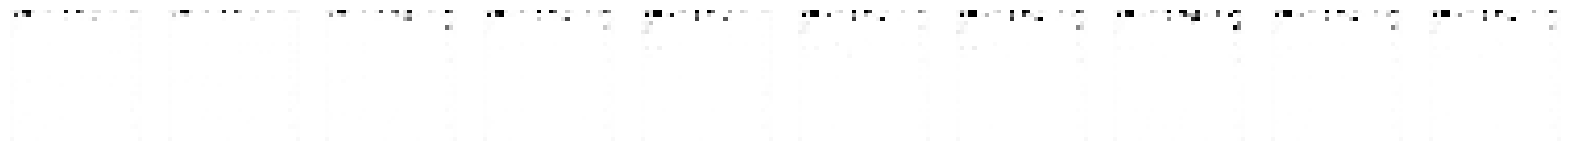

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step - c_gp: 0.0032 - c_loss: -0.3183 - c_wass_loss: -0.3506 - g_loss: -11.3036
Epoch 186/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0038 - c_loss: -0.4692 - c_wass_loss: -0.5074 - g_loss: -10.8816
Epoch 187/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0029 - c_loss: 0.1051 - c_wass_loss: 0.0756 - g_loss: -10.1888
Epoch 188/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0039 - c_loss: -0.5438 - c_wass_loss: -0.5829 - g_loss: -10.2414
Epoch 189/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - c_gp: 0.0049 - c_loss: -0.9404 - c_wass_loss: -0.9890 - g_loss: -12.4246
Epoch 190/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - c_gp: 0.0083 - c_loss: -1.5608 - c_wass_loss: -1.6437 - g_loss: -13.8802
Saved to ./output/generated_img_189.png


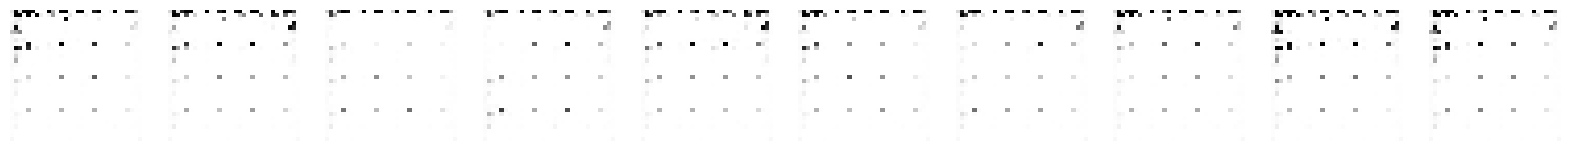

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step - c_gp: 0.0090 - c_loss: -1.7140 - c_wass_loss: -1.8035 - g_loss: -14.0401
Epoch 191/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0109 - c_loss: -2.1178 - c_wass_loss: -2.2273 - g_loss: -15.2133
Epoch 192/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - c_gp: 0.0118 - c_loss: -2.0810 - c_wass_loss: -2.1995 - g_loss: -14.1506
Epoch 193/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0101 - c_loss: -1.7808 - c_wass_loss: -1.8819 - g_loss: -11.7686
Epoch 194/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - c_gp: 0.0092 - c_loss: -0.8373 - c_wass_loss: -0.9298 - g_loss: -11.9924
Epoch 195/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - c_gp: 0.0074 - c_loss: -0.0451 - c_wass_loss: -0.1193 - g_loss: -15.5069
Saved to ./output/generated_img_194.png


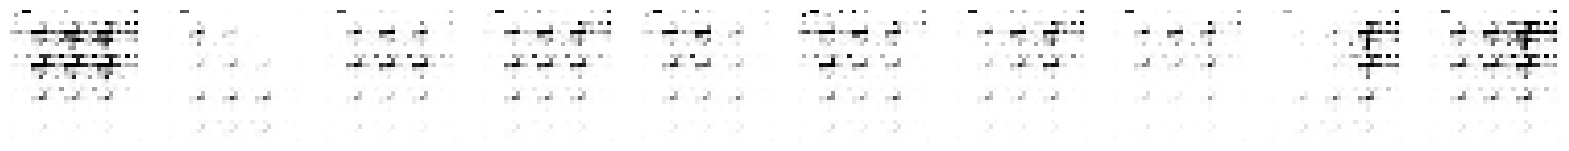

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step - c_gp: 0.0075 - c_loss: -0.0149 - c_wass_loss: -0.0896 - g_loss: -16.1336
Epoch 196/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0159 - c_loss: -0.8432 - c_wass_loss: -1.0020 - g_loss: -21.2380
Epoch 197/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - c_gp: 0.0096 - c_loss: -1.2449 - c_wass_loss: -1.3404 - g_loss: -19.9679
Epoch 198/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0027 - c_loss: -0.0679 - c_wass_loss: -0.0952 - g_loss: -17.4060
Epoch 199/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - c_gp: 0.0033 - c_loss: -0.4630 - c_wass_loss: -0.4964 - g_loss: -15.0971
Epoch 200/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - c_gp: 0.0037 - c_loss: -0.3095 - c_wass_loss: -0.3469 - g_loss: -12.4329
Saved to ./output/generated_img_199.png


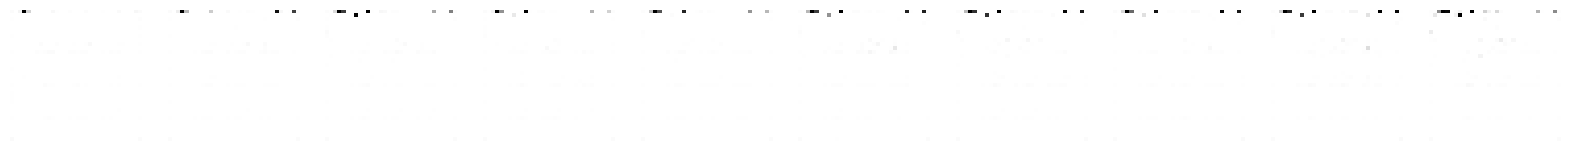

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 741ms/step - c_gp: 0.0036 - c_loss: -0.3400 - c_wass_loss: -0.3757 - g_loss: -12.2112
Epoch 201/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0042 - c_loss: -0.7344 - c_wass_loss: -0.7762 - g_loss: -10.3540
Epoch 202/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0088 - c_loss: -0.9857 - c_wass_loss: -1.0738 - g_loss: -8.1384
Epoch 203/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - c_gp: 0.0132 - c_loss: -0.9696 - c_wass_loss: -1.1018 - g_loss: -6.6555
Epoch 204/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0174 - c_loss: -1.3102 - c_wass_loss: -1.4841 - g_loss: -6.5011
Epoch 205/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - c_gp: 0.0145 - c_loss: -1.6162 - c_wass_loss: -1.7608 - g_loss: -8.7354
Saved to ./output/generated_img_204.png


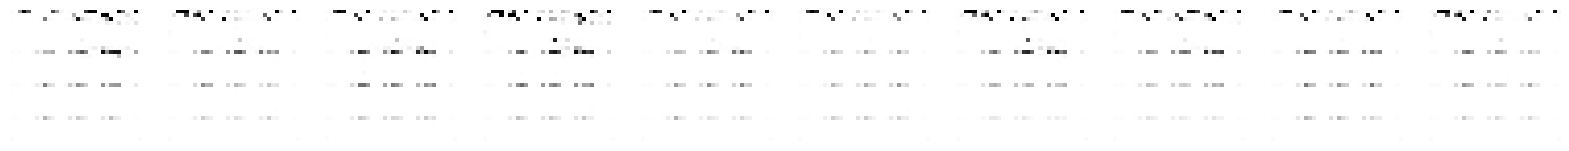

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step - c_gp: 0.0138 - c_loss: -1.6229 - c_wass_loss: -1.7614 - g_loss: -9.2505
Epoch 206/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0146 - c_loss: -1.0480 - c_wass_loss: -1.1936 - g_loss: -12.9936
Epoch 207/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - c_gp: 0.0119 - c_loss: -0.7770 - c_wass_loss: -0.8961 - g_loss: -14.0068
Epoch 208/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - c_gp: 0.0079 - c_loss: -0.6223 - c_wass_loss: -0.7014 - g_loss: -17.0773
Epoch 209/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0141 - c_loss: -1.0673 - c_wass_loss: -1.2084 - g_loss: -20.7079
Epoch 210/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_gp: 0.0183 - c_loss: -1.6096 - c_wass_loss: -1.7926 - g_loss: -21.0063
Saved to ./output/generated_img_209.png


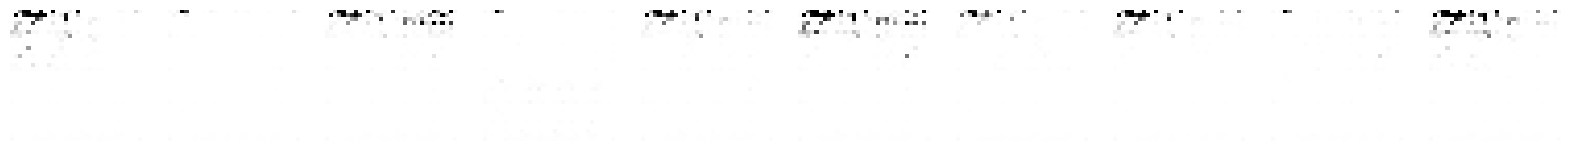

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step - c_gp: 0.0166 - c_loss: -1.5223 - c_wass_loss: -1.6879 - g_loss: -20.7209
Epoch 211/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0096 - c_loss: -0.9137 - c_wass_loss: -1.0093 - g_loss: -18.9429
Epoch 212/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - c_gp: 0.0042 - c_loss: -0.8223 - c_wass_loss: -0.8638 - g_loss: -18.5743
Epoch 213/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - c_gp: 0.0036 - c_loss: -0.2036 - c_wass_loss: -0.2395 - g_loss: -17.8974
Epoch 214/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0032 - c_loss: -0.4962 - c_wass_loss: -0.5286 - g_loss: -17.3188
Epoch 215/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - c_gp: 0.0035 - c_loss: -0.0333 - c_wass_loss: -0.0684 - g_loss: -16.2473
Saved to ./output/generated_img_214.png


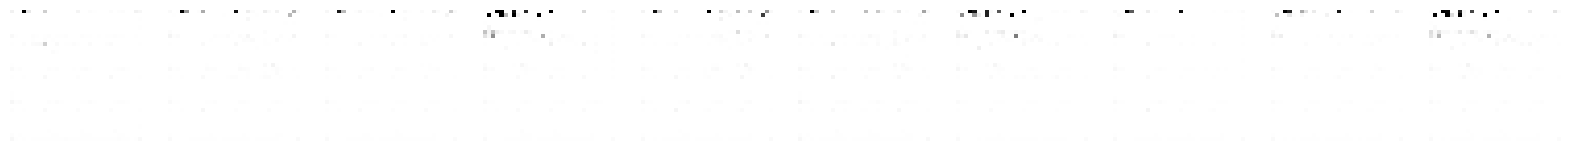

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step - c_gp: 0.0037 - c_loss: -0.0082 - c_wass_loss: -0.0455 - g_loss: -15.9959
Epoch 216/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0054 - c_loss: -0.3150 - c_wass_loss: -0.3695 - g_loss: -13.5353
Epoch 217/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0075 - c_loss: -0.7695 - c_wass_loss: -0.8445 - g_loss: -10.4680
Epoch 218/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0141 - c_loss: -0.5908 - c_wass_loss: -0.7320 - g_loss: -9.7433
Epoch 219/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0122 - c_loss: -0.7175 - c_wass_loss: -0.8390 - g_loss: -13.1954
Epoch 220/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - c_gp: 0.0128 - c_loss: -1.6373 - c_wass_loss: -1.7656 - g_loss: -17.8111
Saved to ./output/generated_img_219.png


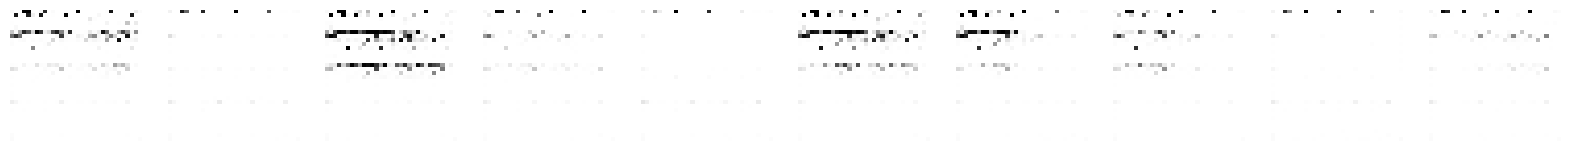

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 743ms/step - c_gp: 0.0137 - c_loss: -1.8561 - c_wass_loss: -1.9930 - g_loss: -18.3258
Epoch 221/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step - c_gp: 0.0114 - c_loss: -0.9052 - c_wass_loss: -1.0195 - g_loss: -17.8296
Epoch 222/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0043 - c_loss: -0.5385 - c_wass_loss: -0.5814 - g_loss: -15.6413
Epoch 223/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0051 - c_loss: -0.1234 - c_wass_loss: -0.1748 - g_loss: -13.6175
Epoch 224/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - c_gp: 0.0058 - c_loss: -0.5855 - c_wass_loss: -0.6439 - g_loss: -12.1977
Epoch 225/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - c_gp: 0.0063 - c_loss: -0.5577 - c_wass_loss: -0.6205 - g_loss: -11.5991
Saved to ./output/generated_img_224.png


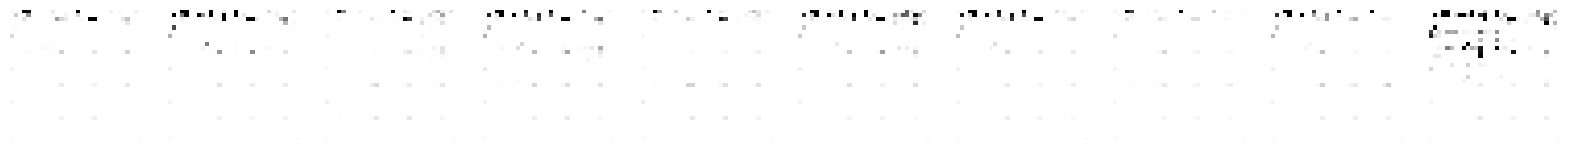

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step - c_gp: 0.0068 - c_loss: -0.7112 - c_wass_loss: -0.7793 - g_loss: -11.4399
Epoch 226/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - c_gp: 0.0064 - c_loss: -0.8827 - c_wass_loss: -0.9462 - g_loss: -11.9816
Epoch 227/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0055 - c_loss: -0.7701 - c_wass_loss: -0.8254 - g_loss: -13.3715
Epoch 228/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0050 - c_loss: -0.7040 - c_wass_loss: -0.7540 - g_loss: -14.9166
Epoch 229/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0039 - c_loss: -0.5073 - c_wass_loss: -0.5459 - g_loss: -15.0114
Epoch 230/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - c_gp: 0.0050 - c_loss: -0.4476 - c_wass_loss: -0.4976 - g_loss: -15.2955
Saved to ./output/generated_img_229.png


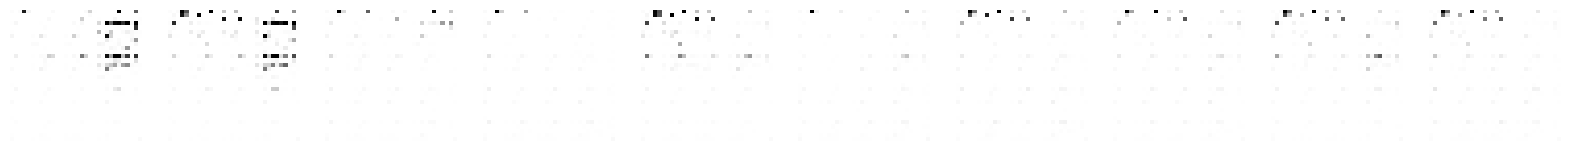

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step - c_gp: 0.0050 - c_loss: -0.4172 - c_wass_loss: -0.4677 - g_loss: -15.1142
Epoch 231/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0035 - c_loss: -0.4052 - c_wass_loss: -0.4402 - g_loss: -15.3756
Epoch 232/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - c_gp: 0.0038 - c_loss: -0.3362 - c_wass_loss: -0.3746 - g_loss: -15.5082
Epoch 233/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - c_gp: 0.0034 - c_loss: -0.1533 - c_wass_loss: -0.1873 - g_loss: -15.0636
Epoch 234/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0044 - c_loss: -0.5829 - c_wass_loss: -0.6269 - g_loss: -14.6268
Epoch 235/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - c_gp: 0.0049 - c_loss: -0.4804 - c_wass_loss: -0.5291 - g_loss: -13.5720
Saved to ./output/generated_img_234.png


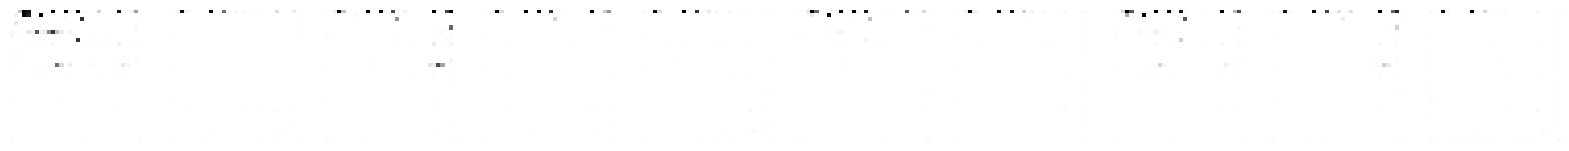

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step - c_gp: 0.0048 - c_loss: -0.5337 - c_wass_loss: -0.5815 - g_loss: -13.4334
Epoch 236/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0063 - c_loss: -0.8121 - c_wass_loss: -0.8747 - g_loss: -11.8246
Epoch 237/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - c_gp: 0.0071 - c_loss: -0.2996 - c_wass_loss: -0.3705 - g_loss: -10.9101
Epoch 238/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0099 - c_loss: -0.6333 - c_wass_loss: -0.7323 - g_loss: -9.7746 
Epoch 239/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0104 - c_loss: -0.8971 - c_wass_loss: -1.0014 - g_loss: -9.9469
Epoch 240/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_gp: 0.0097 - c_loss: -0.7023 - c_wass_loss: -0.7996 - g_loss: -11.2590
Saved to ./output/generated_img_239.png


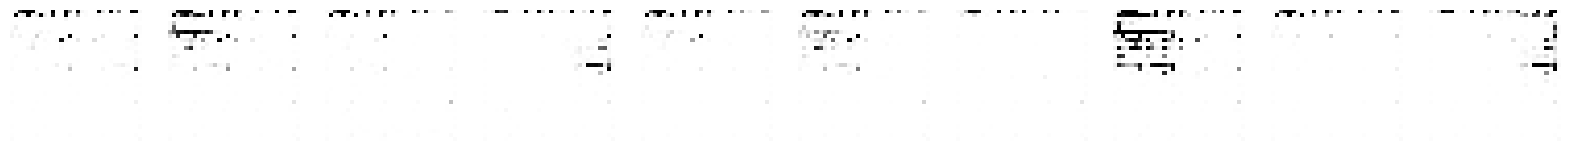

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 745ms/step - c_gp: 0.0089 - c_loss: -0.6727 - c_wass_loss: -0.7620 - g_loss: -11.1938
Epoch 241/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - c_gp: 0.0064 - c_loss: -0.6419 - c_wass_loss: -0.7063 - g_loss: -13.6227
Epoch 242/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - c_gp: 0.0079 - c_loss: -1.1134 - c_wass_loss: -1.1928 - g_loss: -15.5191
Epoch 243/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0100 - c_loss: -1.5960 - c_wass_loss: -1.6957 - g_loss: -15.5723
Epoch 244/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - c_gp: 0.0068 - c_loss: -1.6790 - c_wass_loss: -1.7469 - g_loss: -14.2346
Epoch 245/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - c_gp: 0.0056 - c_loss: -1.4021 - c_wass_loss: -1.4581 - g_loss: -12.8761
Saved to ./output/generated_img_244.png


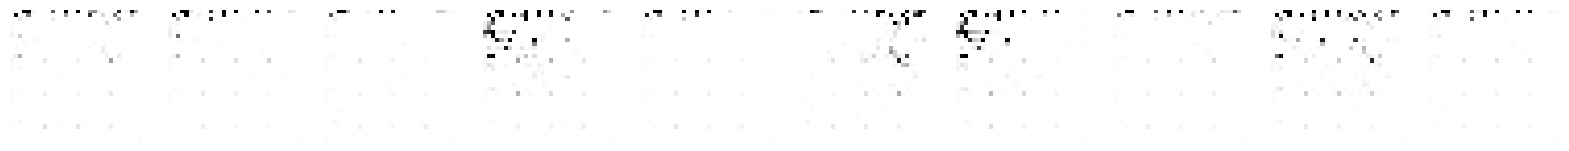

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - c_gp: 0.0053 - c_loss: -1.4130 - c_wass_loss: -1.4657 - g_loss: -12.7051
Epoch 246/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - c_gp: 0.0056 - c_loss: -0.6599 - c_wass_loss: -0.7164 - g_loss: -10.8828
Epoch 247/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step - c_gp: 0.0052 - c_loss: -0.2618 - c_wass_loss: -0.3139 - g_loss: -11.4308
Epoch 248/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - c_gp: 0.0060 - c_loss: -0.4454 - c_wass_loss: -0.5053 - g_loss: -14.4912
Epoch 249/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0060 - c_loss: -0.4882 - c_wass_loss: -0.5479 - g_loss: -16.2182
Epoch 250/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - c_gp: 0.0069 - c_loss: -0.1661 - c_wass_loss: -0.2350 - g_loss: -15.7245
Saved to ./output/generated_img_249.png


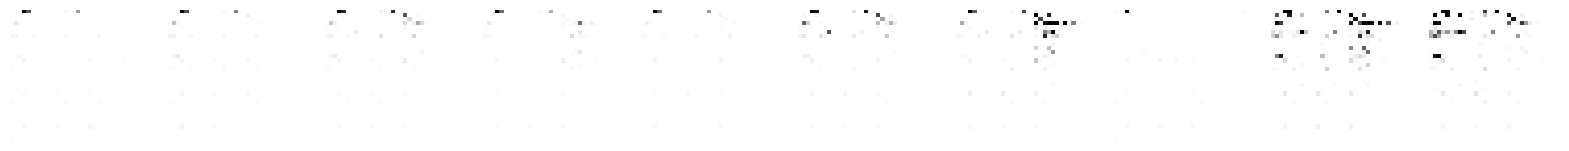

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 727ms/step - c_gp: 0.0074 - c_loss: 0.0372 - c_wass_loss: -0.0363 - g_loss: -15.8072 
Epoch 251/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0062 - c_loss: -0.4900 - c_wass_loss: -0.5516 - g_loss: -16.0998
Epoch 252/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0072 - c_loss: -0.4161 - c_wass_loss: -0.4884 - g_loss: -16.9351
Epoch 253/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0058 - c_loss: -0.8066 - c_wass_loss: -0.8645 - g_loss: -18.1354
Epoch 254/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0043 - c_loss: -0.5852 - c_wass_loss: -0.6277 - g_loss: -18.7563
Epoch 255/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0043 - c_loss: -0.4560 - c_wass_loss: -0.4992 - g_loss: -18.2358
Saved to ./output/generated_img_254.png


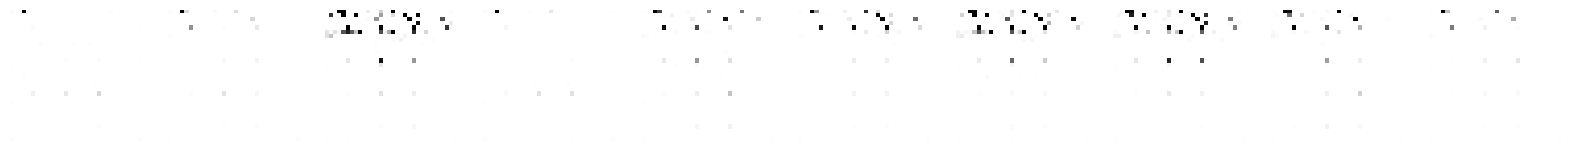

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step - c_gp: 0.0042 - c_loss: -0.4725 - c_wass_loss: -0.5150 - g_loss: -18.0538
Epoch 256/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - c_gp: 0.0042 - c_loss: -1.1519 - c_wass_loss: -1.1938 - g_loss: -16.7543
Epoch 257/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0033 - c_loss: -0.7405 - c_wass_loss: -0.7731 - g_loss: -13.3247
Epoch 258/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0046 - c_loss: -0.9765 - c_wass_loss: -1.0225 - g_loss: -11.0140
Epoch 259/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0050 - c_loss: -0.5555 - c_wass_loss: -0.6060 - g_loss: -10.6624
Epoch 260/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - c_gp: 0.0063 - c_loss: -0.5334 - c_wass_loss: -0.5963 - g_loss: -11.9017
Saved to ./output/generated_img_259.png


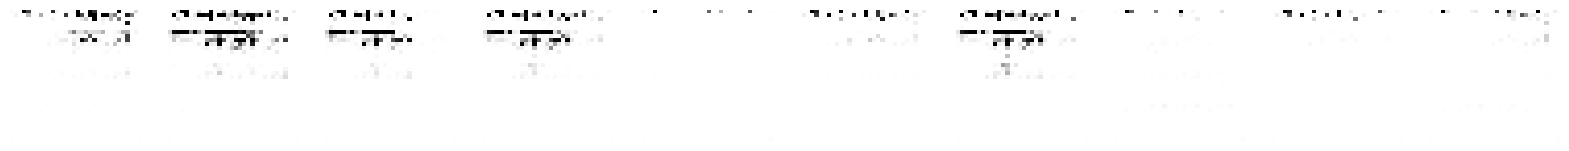

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step - c_gp: 0.0062 - c_loss: -0.4520 - c_wass_loss: -0.5141 - g_loss: -12.1098
Epoch 261/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - c_gp: 0.0068 - c_loss: -0.4263 - c_wass_loss: -0.4945 - g_loss: -14.9629
Epoch 262/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - c_gp: 0.0063 - c_loss: -0.3499 - c_wass_loss: -0.4126 - g_loss: -14.5667
Epoch 263/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - c_gp: 0.0049 - c_loss: -0.7195 - c_wass_loss: -0.7684 - g_loss: -13.2805
Epoch 264/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0034 - c_loss: -0.4575 - c_wass_loss: -0.4919 - g_loss: -11.9572
Epoch 265/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_gp: 0.0035 - c_loss: -0.2339 - c_wass_loss: -0.2693 - g_loss: -11.8726
Saved to ./output/generated_img_264.png


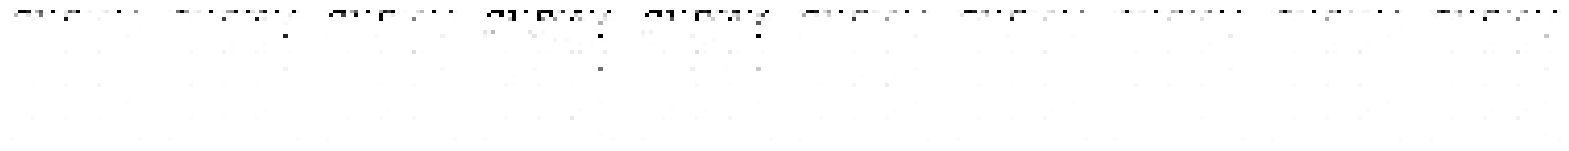

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 732ms/step - c_gp: 0.0034 - c_loss: -0.1169 - c_wass_loss: -0.1508 - g_loss: -11.8384
Epoch 266/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0034 - c_loss: -0.1925 - c_wass_loss: -0.2263 - g_loss: -10.9274
Epoch 267/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0048 - c_loss: -0.8243 - c_wass_loss: -0.8722 - g_loss: -10.5643
Epoch 268/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - c_gp: 0.0049 - c_loss: -1.0551 - c_wass_loss: -1.1042 - g_loss: -9.3149
Epoch 269/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0077 - c_loss: -1.1043 - c_wass_loss: -1.1808 - g_loss: -7.3828
Epoch 270/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - c_gp: 0.0114 - c_loss: -1.2904 - c_wass_loss: -1.4040 - g_loss: -6.7019
Saved to ./output/generated_img_269.png


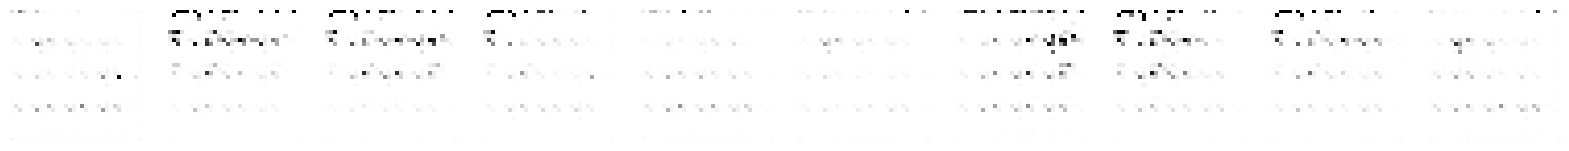

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 739ms/step - c_gp: 0.0135 - c_loss: -1.3546 - c_wass_loss: -1.4894 - g_loss: -6.4160
Epoch 271/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0188 - c_loss: -0.7548 - c_wass_loss: -0.9425 - g_loss: -5.7845
Epoch 272/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - c_gp: 0.0171 - c_loss: -1.0072 - c_wass_loss: -1.1780 - g_loss: -8.8714
Epoch 273/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0211 - c_loss: -2.0436 - c_wass_loss: -2.2545 - g_loss: -13.9112
Epoch 274/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.0256 - c_loss: -1.9113 - c_wass_loss: -2.1673 - g_loss: -16.6176
Epoch 275/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_gp: 0.0115 - c_loss: -1.0760 - c_wass_loss: -1.1908 - g_loss: -16.1613
Saved to ./output/generated_img_274.png


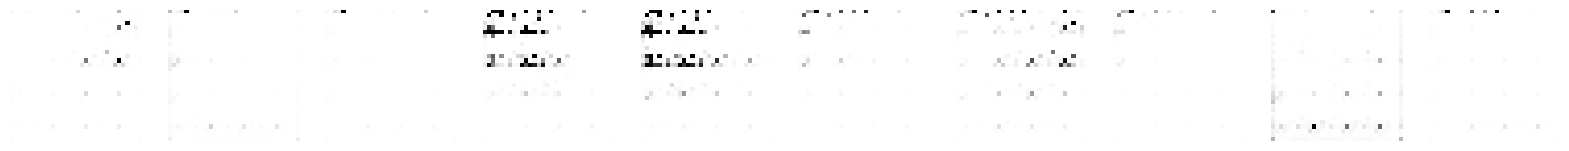

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 715ms/step - c_gp: 0.0108 - c_loss: -0.7938 - c_wass_loss: -0.9014 - g_loss: -15.7874
Epoch 276/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step - c_gp: 0.0061 - c_loss: -0.8651 - c_wass_loss: -0.9257 - g_loss: -14.4328
Epoch 277/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0057 - c_loss: -0.8427 - c_wass_loss: -0.9001 - g_loss: -13.1744
Epoch 278/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0064 - c_loss: -0.6484 - c_wass_loss: -0.7128 - g_loss: -11.5910
Epoch 279/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0068 - c_loss: -0.5797 - c_wass_loss: -0.6478 - g_loss: -10.3349
Epoch 280/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - c_gp: 0.0067 - c_loss: -0.6442 - c_wass_loss: -0.7109 - g_loss: -10.3089
Saved to ./output/generated_img_279.png


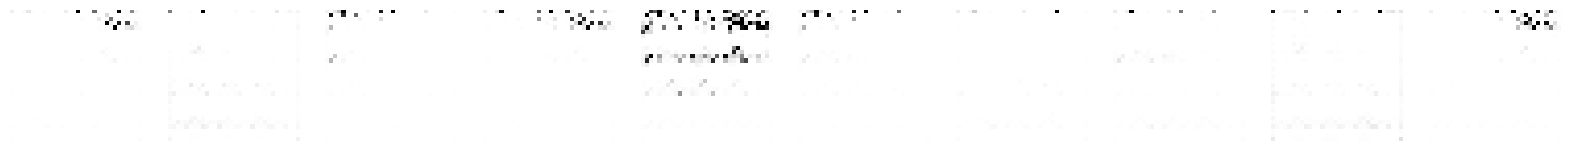

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step - c_gp: 0.0062 - c_loss: -0.6076 - c_wass_loss: -0.6698 - g_loss: -10.3292
Epoch 281/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step - c_gp: 0.0057 - c_loss: -0.3959 - c_wass_loss: -0.4526 - g_loss: -11.9343
Epoch 282/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - c_gp: 0.0056 - c_loss: -0.7643 - c_wass_loss: -0.8203 - g_loss: -14.4520
Epoch 283/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0089 - c_loss: -0.7636 - c_wass_loss: -0.8527 - g_loss: -16.9875
Epoch 284/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0063 - c_loss: -0.7875 - c_wass_loss: -0.8505 - g_loss: -16.8156
Epoch 285/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - c_gp: 0.0037 - c_loss: -0.3837 - c_wass_loss: -0.4204 - g_loss: -15.9378
Saved to ./output/generated_img_284.png


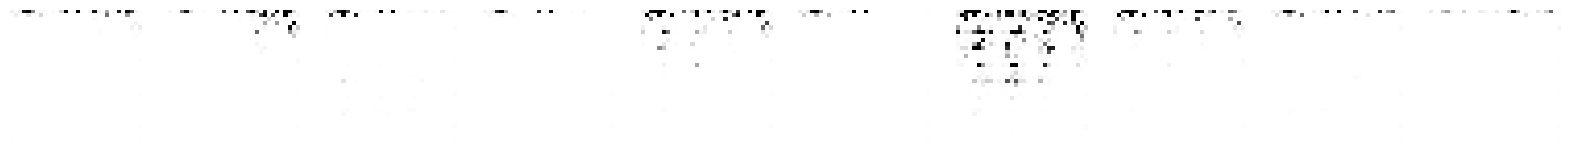

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step - c_gp: 0.0034 - c_loss: -0.1518 - c_wass_loss: -0.1856 - g_loss: -15.7093
Epoch 286/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - c_gp: 0.0041 - c_loss: -0.3211 - c_wass_loss: -0.3623 - g_loss: -15.0567
Epoch 287/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - c_gp: 0.0044 - c_loss: -0.3984 - c_wass_loss: -0.4422 - g_loss: -14.2794
Epoch 288/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0052 - c_loss: -0.8439 - c_wass_loss: -0.8962 - g_loss: -14.7360
Epoch 289/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.0044 - c_loss: -0.4229 - c_wass_loss: -0.4667 - g_loss: -15.5733
Epoch 290/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0053 - c_loss: -0.6549 - c_wass_loss: -0.7084 - g_loss: -16.4663
Saved to ./output/generated_img_289.png


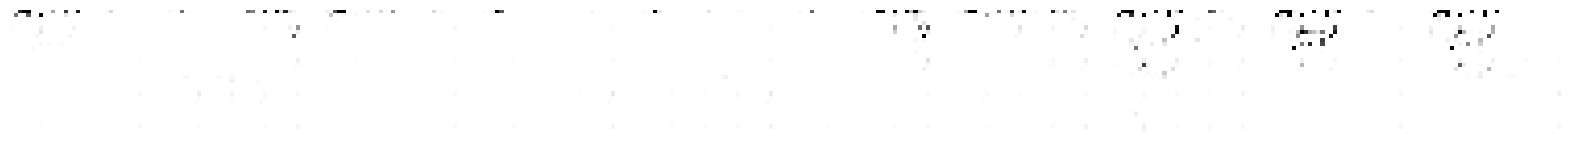

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step - c_gp: 0.0061 - c_loss: -0.6346 - c_wass_loss: -0.6955 - g_loss: -16.4379
Epoch 291/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0033 - c_loss: -0.3558 - c_wass_loss: -0.3890 - g_loss: -16.4595
Epoch 292/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - c_gp: 0.0038 - c_loss: -0.1214 - c_wass_loss: -0.1592 - g_loss: -15.4043
Epoch 293/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0043 - c_loss: -0.6567 - c_wass_loss: -0.7001 - g_loss: -13.3163
Epoch 294/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0056 - c_loss: -0.2447 - c_wass_loss: -0.3005 - g_loss: -12.4611
Epoch 295/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - c_gp: 0.0062 - c_loss: -0.4621 - c_wass_loss: -0.5237 - g_loss: -12.2011
Saved to ./output/generated_img_294.png


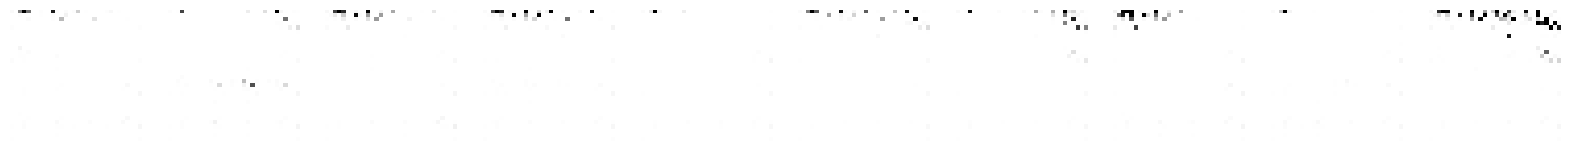

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step - c_gp: 0.0059 - c_loss: -0.4081 - c_wass_loss: -0.4668 - g_loss: -12.4294
Epoch 296/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0062 - c_loss: -0.7138 - c_wass_loss: -0.7760 - g_loss: -13.3322
Epoch 297/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0071 - c_loss: -0.2402 - c_wass_loss: -0.3114 - g_loss: -15.1051
Epoch 298/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - c_gp: 0.0105 - c_loss: -0.8821 - c_wass_loss: -0.9869 - g_loss: -16.9301
Epoch 299/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0085 - c_loss: -1.0192 - c_wass_loss: -1.1042 - g_loss: -18.1906
Epoch 300/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - c_gp: 0.0056 - c_loss: -0.4546 - c_wass_loss: -0.5104 - g_loss: -17.5406
Saved to ./output/generated_img_299.png


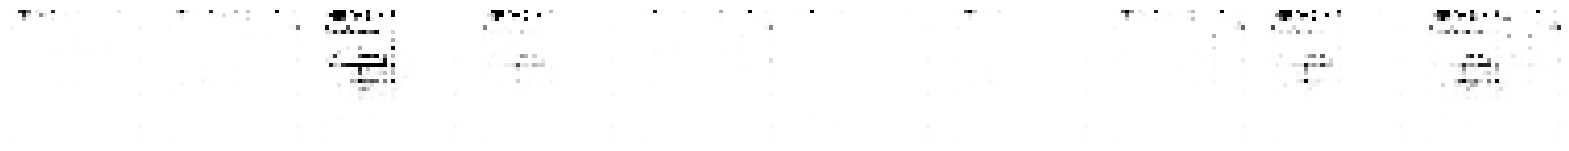

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 736ms/step - c_gp: 0.0055 - c_loss: -0.2124 - c_wass_loss: -0.2672 - g_loss: -17.4785
Epoch 301/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0038 - c_loss: 0.1638 - c_wass_loss: 0.1261 - g_loss: -15.3742 
Epoch 302/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0033 - c_loss: -0.4702 - c_wass_loss: -0.5030 - g_loss: -14.6584
Epoch 303/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0036 - c_loss: -0.2338 - c_wass_loss: -0.2695 - g_loss: -14.2017
Epoch 304/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - c_gp: 0.0055 - c_loss: -0.6149 - c_wass_loss: -0.6703 - g_loss: -13.9588
Epoch 305/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - c_gp: 0.0051 - c_loss: -0.9062 - c_wass_loss: -0.9570 - g_loss: -12.6949
Saved to ./output/generated_img_304.png


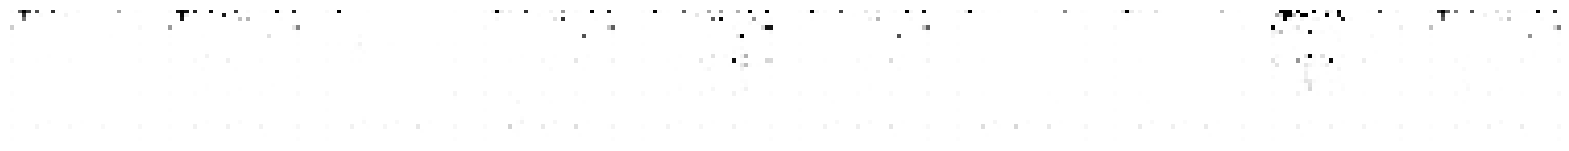

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 770ms/step - c_gp: 0.0045 - c_loss: -0.8476 - c_wass_loss: -0.8925 - g_loss: -12.2742
Epoch 306/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - c_gp: 0.0061 - c_loss: -0.6199 - c_wass_loss: -0.6808 - g_loss: -11.6632
Epoch 307/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0076 - c_loss: -1.0495 - c_wass_loss: -1.1252 - g_loss: -13.0105
Epoch 308/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0075 - c_loss: -0.6170 - c_wass_loss: -0.6920 - g_loss: -16.2998
Epoch 309/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - c_gp: 0.0093 - c_loss: -0.9244 - c_wass_loss: -1.0178 - g_loss: -18.6836
Epoch 310/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - c_gp: 0.0067 - c_loss: -0.7545 - c_wass_loss: -0.8214 - g_loss: -17.8499
Saved to ./output/generated_img_309.png


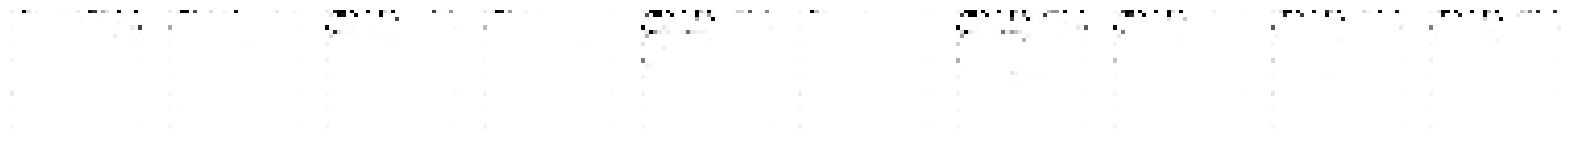

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step - c_gp: 0.0065 - c_loss: -0.6570 - c_wass_loss: -0.7220 - g_loss: -17.4966
Epoch 311/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - c_gp: 0.0044 - c_loss: -0.7464 - c_wass_loss: -0.7903 - g_loss: -15.6198
Epoch 312/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0040 - c_loss: -0.3673 - c_wass_loss: -0.4077 - g_loss: -14.2923
Epoch 313/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0037 - c_loss: -0.5545 - c_wass_loss: -0.5910 - g_loss: -13.9200
Epoch 314/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - c_gp: 0.0035 - c_loss: -0.3145 - c_wass_loss: -0.3495 - g_loss: -13.6961
Epoch 315/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - c_gp: 0.0038 - c_loss: -0.0744 - c_wass_loss: -0.1120 - g_loss: -14.4413
Saved to ./output/generated_img_314.png


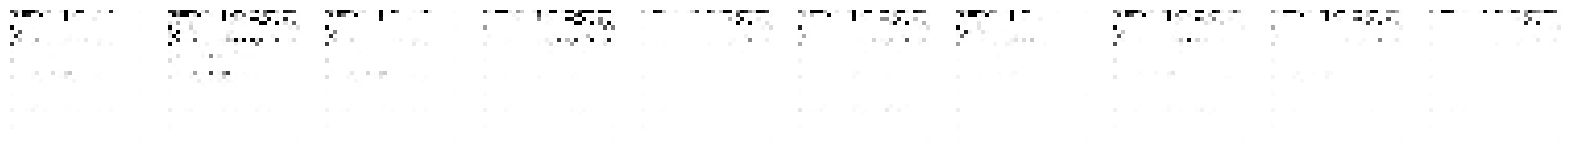

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step - c_gp: 0.0036 - c_loss: -0.1577 - c_wass_loss: -0.1938 - g_loss: -14.5912
Epoch 316/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - c_gp: 0.0041 - c_loss: -0.0464 - c_wass_loss: -0.0875 - g_loss: -14.5118
Epoch 317/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - c_gp: 0.0040 - c_loss: -0.2227 - c_wass_loss: -0.2624 - g_loss: -13.8191
Epoch 318/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0043 - c_loss: -0.7775 - c_wass_loss: -0.8207 - g_loss: -13.5869
Epoch 319/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0040 - c_loss: -0.6714 - c_wass_loss: -0.7118 - g_loss: -12.3005
Epoch 320/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_gp: 0.0050 - c_loss: -0.6242 - c_wass_loss: -0.6740 - g_loss: -9.9968
Saved to ./output/generated_img_319.png


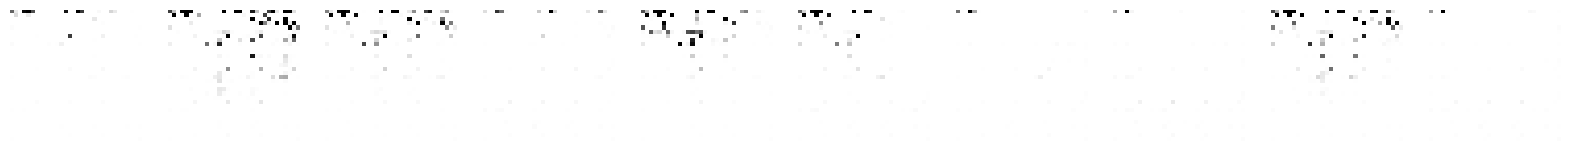

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - c_gp: 0.0057 - c_loss: -0.6725 - c_wass_loss: -0.7292 - g_loss: -9.8089
Epoch 321/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - c_gp: 0.0047 - c_loss: -0.4516 - c_wass_loss: -0.4991 - g_loss: -8.5130
Epoch 322/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0058 - c_loss: -0.6469 - c_wass_loss: -0.7048 - g_loss: -9.1742
Epoch 323/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0058 - c_loss: -0.3249 - c_wass_loss: -0.3834 - g_loss: -12.0115
Epoch 324/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0057 - c_loss: -0.6335 - c_wass_loss: -0.6909 - g_loss: -14.5630
Epoch 325/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0059 - c_loss: -0.6947 - c_wass_loss: -0.7541 - g_loss: -15.7164
Saved to ./output/generated_img_324.png


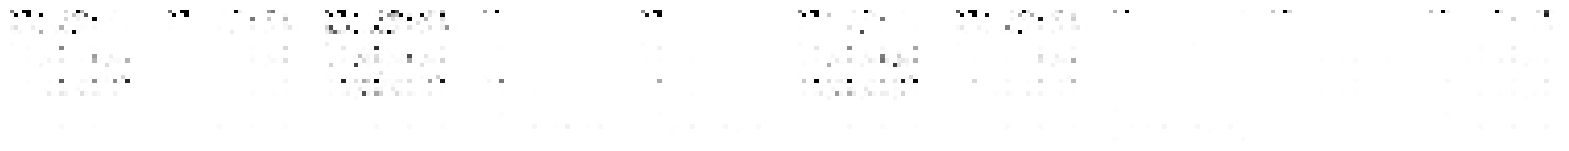

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step - c_gp: 0.0061 - c_loss: -0.6349 - c_wass_loss: -0.6958 - g_loss: -15.6722
Epoch 326/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - c_gp: 0.0050 - c_loss: -0.2167 - c_wass_loss: -0.2665 - g_loss: -14.7035
Epoch 327/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - c_gp: 0.0034 - c_loss: -0.5238 - c_wass_loss: -0.5579 - g_loss: -14.1549
Epoch 328/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0039 - c_loss: -0.6071 - c_wass_loss: -0.6466 - g_loss: -14.7432
Epoch 329/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0043 - c_loss: -0.6382 - c_wass_loss: -0.6813 - g_loss: -15.6500
Epoch 330/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - c_gp: 0.0053 - c_loss: -0.8435 - c_wass_loss: -0.8969 - g_loss: -16.3647
Saved to ./output/generated_img_329.png


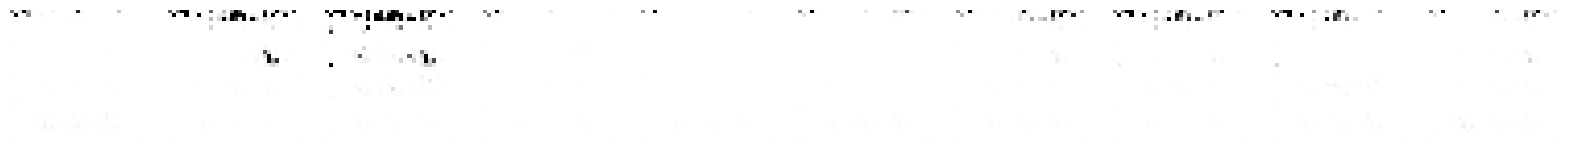

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step - c_gp: 0.0057 - c_loss: -0.8570 - c_wass_loss: -0.9136 - g_loss: -16.8065
Epoch 331/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step - c_gp: 0.0046 - c_loss: -0.7261 - c_wass_loss: -0.7720 - g_loss: -16.0686
Epoch 332/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0038 - c_loss: -0.3446 - c_wass_loss: -0.3826 - g_loss: -15.6158
Epoch 333/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0040 - c_loss: -0.6002 - c_wass_loss: -0.6404 - g_loss: -16.0042
Epoch 334/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.0044 - c_loss: -0.2693 - c_wass_loss: -0.3133 - g_loss: -15.9971
Epoch 335/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - c_gp: 0.0046 - c_loss: -0.2410 - c_wass_loss: -0.2874 - g_loss: -16.1865
Saved to ./output/generated_img_334.png


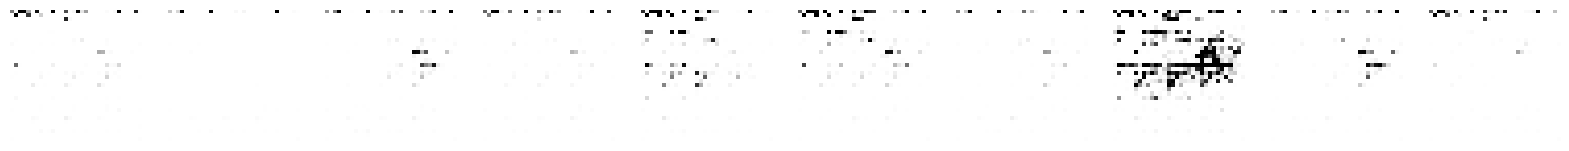

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - c_gp: 0.0044 - c_loss: -0.3826 - c_wass_loss: -0.4267 - g_loss: -16.1604
Epoch 336/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - c_gp: 0.0055 - c_loss: -0.4748 - c_wass_loss: -0.5301 - g_loss: -16.1367
Epoch 337/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - c_gp: 0.0058 - c_loss: -0.6619 - c_wass_loss: -0.7197 - g_loss: -16.1821
Epoch 338/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0073 - c_loss: -0.7947 - c_wass_loss: -0.8673 - g_loss: -16.4297
Epoch 339/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - c_gp: 0.0073 - c_loss: -0.8422 - c_wass_loss: -0.9155 - g_loss: -16.3202
Epoch 340/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_gp: 0.0056 - c_loss: -0.9928 - c_wass_loss: -1.0491 - g_loss: -16.2906
Saved to ./output/generated_img_339.png


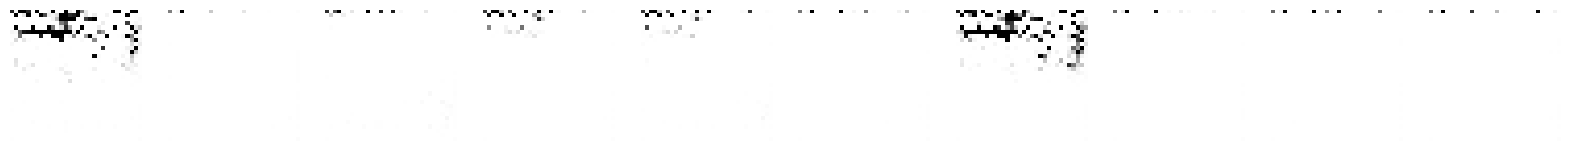

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step - c_gp: 0.0056 - c_loss: -1.1118 - c_wass_loss: -1.1677 - g_loss: -16.3543
Epoch 341/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - c_gp: 0.0058 - c_loss: -0.6830 - c_wass_loss: -0.7412 - g_loss: -16.6611
Epoch 342/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - c_gp: 0.0079 - c_loss: -0.5881 - c_wass_loss: -0.6673 - g_loss: -15.8489
Epoch 343/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0056 - c_loss: -0.2762 - c_wass_loss: -0.3318 - g_loss: -15.4382
Epoch 344/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0052 - c_loss: -0.4624 - c_wass_loss: -0.5139 - g_loss: -14.3475
Epoch 345/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0039 - c_loss: -0.3325 - c_wass_loss: -0.3715 - g_loss: -13.9778
Saved to ./output/generated_img_344.png


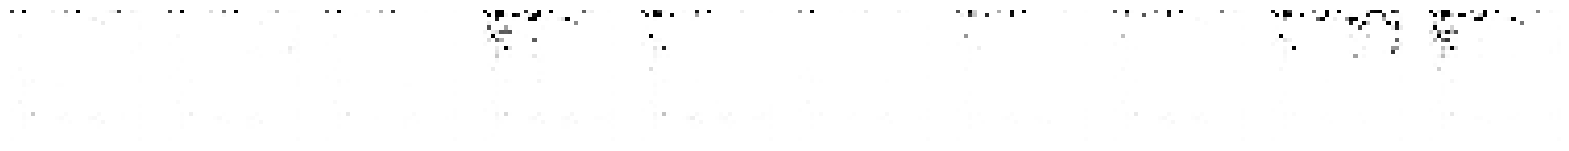

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - c_gp: 0.0037 - c_loss: -0.3447 - c_wass_loss: -0.3820 - g_loss: -14.0836
Epoch 346/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0036 - c_loss: -0.2038 - c_wass_loss: -0.2397 - g_loss: -13.4813
Epoch 347/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - c_gp: 0.0035 - c_loss: -0.5050 - c_wass_loss: -0.5404 - g_loss: -13.2866
Epoch 348/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - c_gp: 0.0049 - c_loss: -0.6061 - c_wass_loss: -0.6554 - g_loss: -14.0143
Epoch 349/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0072 - c_loss: -0.7668 - c_wass_loss: -0.8385 - g_loss: -14.7165
Epoch 350/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - c_gp: 0.0076 - c_loss: -0.5929 - c_wass_loss: -0.6690 - g_loss: -14.9478
Saved to ./output/generated_img_349.png


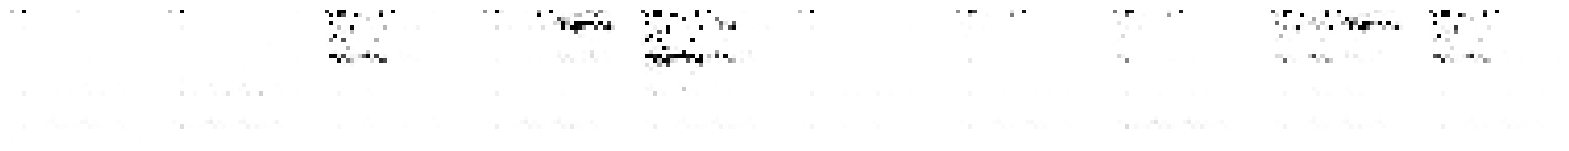

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step - c_gp: 0.0071 - c_loss: -0.6595 - c_wass_loss: -0.7306 - g_loss: -15.0900
Epoch 351/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.0077 - c_loss: -0.5394 - c_wass_loss: -0.6162 - g_loss: -15.8449
Epoch 352/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0051 - c_loss: -0.6497 - c_wass_loss: -0.7005 - g_loss: -15.1333
Epoch 353/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0047 - c_loss: -0.7028 - c_wass_loss: -0.7502 - g_loss: -13.2419
Epoch 354/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - c_gp: 0.0052 - c_loss: -0.8785 - c_wass_loss: -0.9303 - g_loss: -11.9917
Epoch 355/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_gp: 0.0045 - c_loss: -0.4885 - c_wass_loss: -0.5330 - g_loss: -11.4469
Saved to ./output/generated_img_354.png


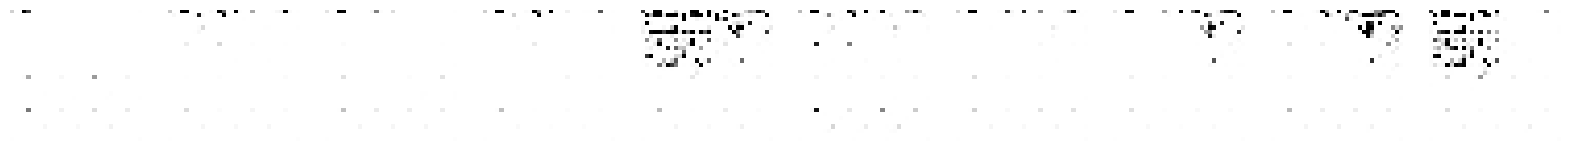

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 736ms/step - c_gp: 0.0042 - c_loss: -0.4303 - c_wass_loss: -0.4724 - g_loss: -11.4405
Epoch 356/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0048 - c_loss: -0.5379 - c_wass_loss: -0.5860 - g_loss: -11.7749
Epoch 357/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - c_gp: 0.0044 - c_loss: -0.9150 - c_wass_loss: -0.9592 - g_loss: -13.7771
Epoch 358/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0059 - c_loss: -0.3681 - c_wass_loss: -0.4268 - g_loss: -13.7904
Epoch 359/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0039 - c_loss: -0.5528 - c_wass_loss: -0.5923 - g_loss: -12.9882
Epoch 360/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - c_gp: 0.0044 - c_loss: -0.4838 - c_wass_loss: -0.5280 - g_loss: -10.5292
Saved to ./output/generated_img_359.png


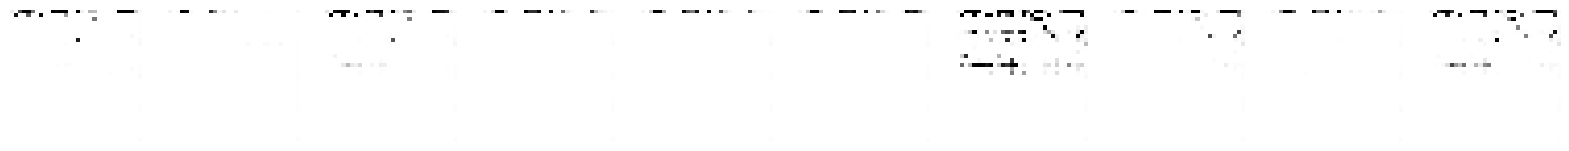

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 743ms/step - c_gp: 0.0046 - c_loss: -0.5128 - c_wass_loss: -0.5586 - g_loss: -10.1798
Epoch 361/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - c_gp: 0.0076 - c_loss: -0.7640 - c_wass_loss: -0.8398 - g_loss: -8.2042
Epoch 362/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.0068 - c_loss: -0.4357 - c_wass_loss: -0.5033 - g_loss: -8.0002
Epoch 363/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0059 - c_loss: -0.3846 - c_wass_loss: -0.4439 - g_loss: -8.8138
Epoch 364/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0056 - c_loss: -0.8362 - c_wass_loss: -0.8923 - g_loss: -11.2953
Epoch 365/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - c_gp: 0.0043 - c_loss: -0.6452 - c_wass_loss: -0.6884 - g_loss: -12.9694
Saved to ./output/generated_img_364.png


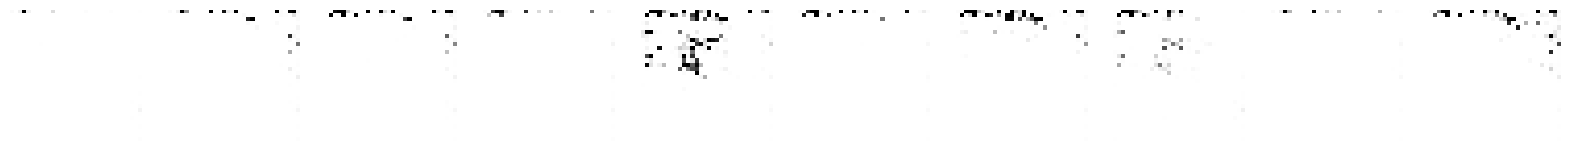

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step - c_gp: 0.0038 - c_loss: -0.7790 - c_wass_loss: -0.8173 - g_loss: -13.0615
Epoch 366/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0030 - c_loss: -0.3455 - c_wass_loss: -0.3754 - g_loss: -12.0086
Epoch 367/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - c_gp: 0.0030 - c_loss: -0.5314 - c_wass_loss: -0.5618 - g_loss: -12.0693
Epoch 368/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - c_gp: 0.0034 - c_loss: -0.0791 - c_wass_loss: -0.1135 - g_loss: -11.7846
Epoch 369/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - c_gp: 0.0032 - c_loss: -0.3375 - c_wass_loss: -0.3692 - g_loss: -12.1449
Epoch 370/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - c_gp: 0.0035 - c_loss: -0.1818 - c_wass_loss: -0.2169 - g_loss: -12.0530
Saved to ./output/generated_img_369.png


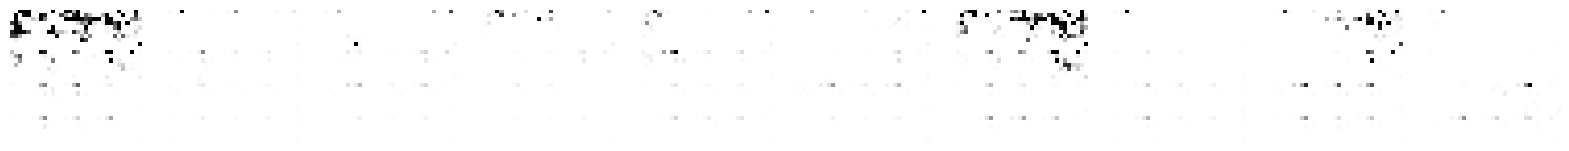

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step - c_gp: 0.0035 - c_loss: -0.0712 - c_wass_loss: -0.1061 - g_loss: -12.0512
Epoch 371/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0034 - c_loss: -0.3089 - c_wass_loss: -0.3426 - g_loss: -12.4092
Epoch 372/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0037 - c_loss: -0.5768 - c_wass_loss: -0.6133 - g_loss: -11.8512
Epoch 373/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0036 - c_loss: -0.1784 - c_wass_loss: -0.2147 - g_loss: -11.3501
Epoch 374/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0062 - c_loss: -0.4653 - c_wass_loss: -0.5270 - g_loss: -11.9537
Epoch 375/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - c_gp: 0.0069 - c_loss: -0.6298 - c_wass_loss: -0.6986 - g_loss: -12.8181
Saved to ./output/generated_img_374.png


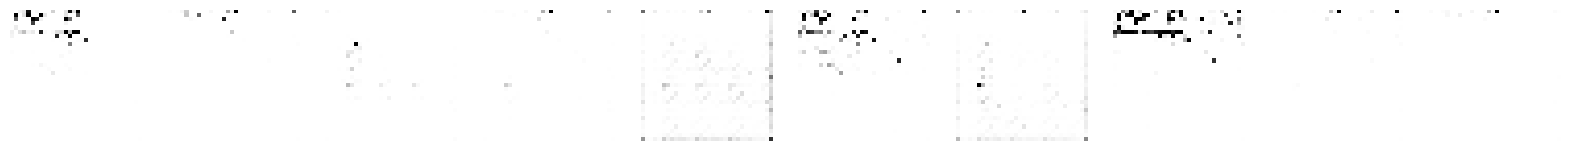

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - c_gp: 0.0068 - c_loss: -0.6906 - c_wass_loss: -0.7583 - g_loss: -12.7767
Epoch 376/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - c_gp: 0.0068 - c_loss: -0.6154 - c_wass_loss: -0.6836 - g_loss: -12.9222
Epoch 377/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - c_gp: 0.0054 - c_loss: -0.7674 - c_wass_loss: -0.8217 - g_loss: -11.2061
Epoch 378/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - c_gp: 0.0047 - c_loss: -0.8098 - c_wass_loss: -0.8568 - g_loss: -10.5667
Epoch 379/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0044 - c_loss: -0.8590 - c_wass_loss: -0.9035 - g_loss: -9.7229
Epoch 380/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - c_gp: 0.0047 - c_loss: -0.5025 - c_wass_loss: -0.5499 - g_loss: -8.9194
Saved to ./output/generated_img_379.png


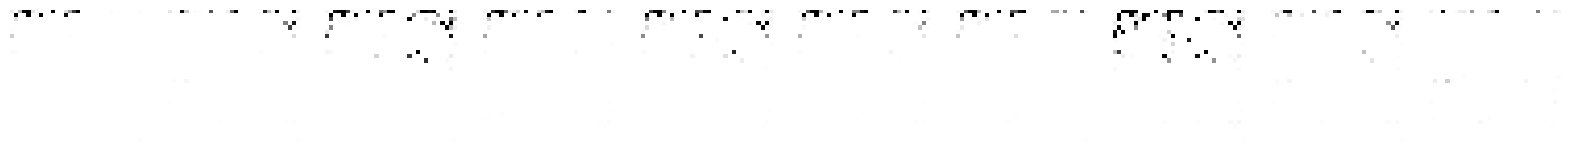

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 780ms/step - c_gp: 0.0048 - c_loss: -0.4470 - c_wass_loss: -0.4952 - g_loss: -8.7053
Epoch 381/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0041 - c_loss: -0.2729 - c_wass_loss: -0.3144 - g_loss: -7.8688
Epoch 382/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - c_gp: 0.0052 - c_loss: -0.4735 - c_wass_loss: -0.5260 - g_loss: -7.7718
Epoch 383/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0052 - c_loss: -0.5351 - c_wass_loss: -0.5875 - g_loss: -9.3112
Epoch 384/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - c_gp: 0.0055 - c_loss: -0.6674 - c_wass_loss: -0.7223 - g_loss: -11.6068
Epoch 385/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - c_gp: 0.0074 - c_loss: -0.9298 - c_wass_loss: -1.0040 - g_loss: -13.3698
Saved to ./output/generated_img_384.png


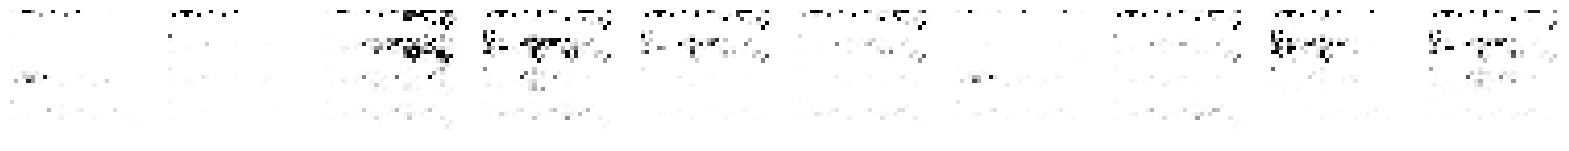

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 776ms/step - c_gp: 0.0074 - c_loss: -0.8786 - c_wass_loss: -0.9531 - g_loss: -13.5166
Epoch 386/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 712ms/step - c_gp: 0.0047 - c_loss: -0.7715 - c_wass_loss: -0.8183 - g_loss: -14.4925
Epoch 387/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step - c_gp: 0.0043 - c_loss: -0.9252 - c_wass_loss: -0.9683 - g_loss: -13.6481
Epoch 388/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0040 - c_loss: -0.3594 - c_wass_loss: -0.3989 - g_loss: -11.3034
Epoch 389/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0045 - c_loss: -0.2170 - c_wass_loss: -0.2615 - g_loss: -8.8204
Epoch 390/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - c_gp: 0.0047 - c_loss: -0.8044 - c_wass_loss: -0.8516 - g_loss: -7.5597
Saved to ./output/generated_img_389.png


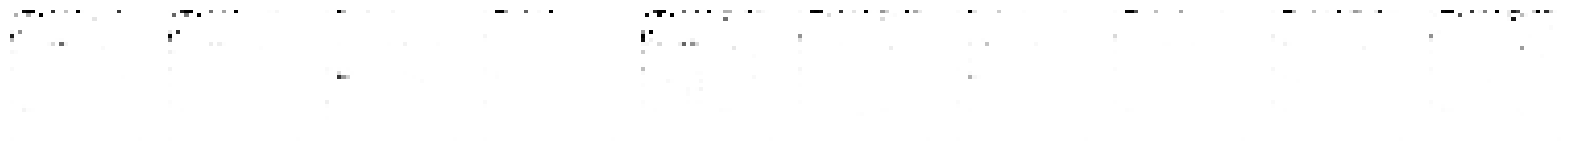

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 828ms/step - c_gp: 0.0046 - c_loss: -0.8917 - c_wass_loss: -0.9378 - g_loss: -7.3790
Epoch 391/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0089 - c_loss: -0.9876 - c_wass_loss: -1.0762 - g_loss: -5.8245
Epoch 392/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0097 - c_loss: -0.9061 - c_wass_loss: -1.0035 - g_loss: -4.7896
Epoch 393/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - c_gp: 0.0118 - c_loss: -0.9481 - c_wass_loss: -1.0665 - g_loss: -4.0900
Epoch 394/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0133 - c_loss: -0.7667 - c_wass_loss: -0.8993 - g_loss: -4.2589
Epoch 395/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - c_gp: 0.0118 - c_loss: -0.9642 - c_wass_loss: -1.0820 - g_loss: -5.7862
Saved to ./output/generated_img_394.png


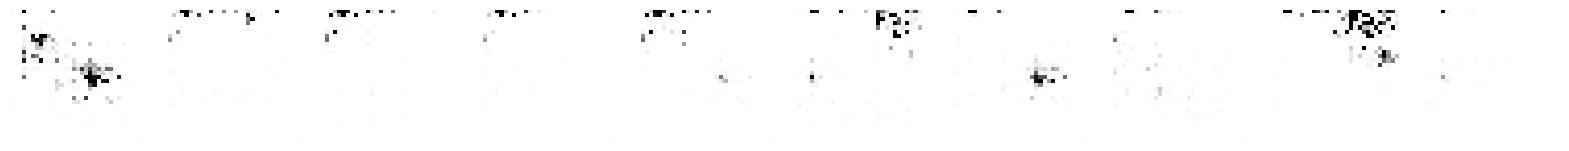

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 746ms/step - c_gp: 0.0110 - c_loss: -0.9462 - c_wass_loss: -1.0564 - g_loss: -6.1096
Epoch 396/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0072 - c_loss: -0.6172 - c_wass_loss: -0.6897 - g_loss: -9.0812
Epoch 397/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - c_gp: 0.0099 - c_loss: -0.8588 - c_wass_loss: -0.9578 - g_loss: -12.6637
Epoch 398/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0101 - c_loss: -0.7549 - c_wass_loss: -0.8556 - g_loss: -15.5746
Epoch 399/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0073 - c_loss: -0.6197 - c_wass_loss: -0.6927 - g_loss: -15.6974
Epoch 400/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - c_gp: 0.0045 - c_loss: -0.6337 - c_wass_loss: -0.6791 - g_loss: -14.8279
Saved to ./output/generated_img_399.png


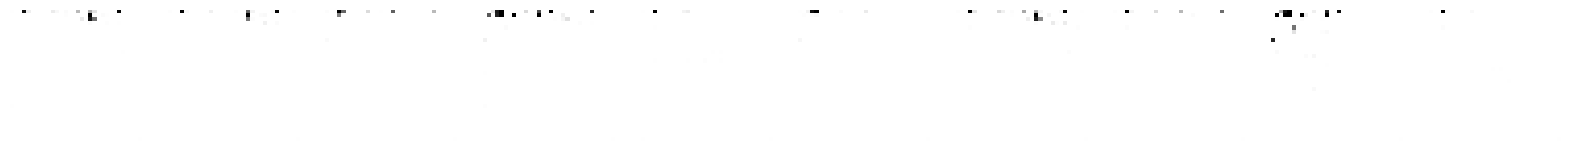

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 832ms/step - c_gp: 0.0045 - c_loss: -0.5808 - c_wass_loss: -0.6259 - g_loss: -14.7637
Epoch 401/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.0036 - c_loss: -0.2774 - c_wass_loss: -0.3134 - g_loss: -13.1827
Epoch 402/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0050 - c_loss: -0.3409 - c_wass_loss: -0.3910 - g_loss: -10.3658
Epoch 403/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 575ms/step - c_gp: 0.0043 - c_loss: -0.7743 - c_wass_loss: -0.8178 - g_loss: -9.1114
Epoch 404/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0047 - c_loss: -0.1574 - c_wass_loss: -0.2040 - g_loss: -9.0476
Epoch 405/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - c_gp: 0.0053 - c_loss: -0.2608 - c_wass_loss: -0.3138 - g_loss: -8.8695
Saved to ./output/generated_img_404.png


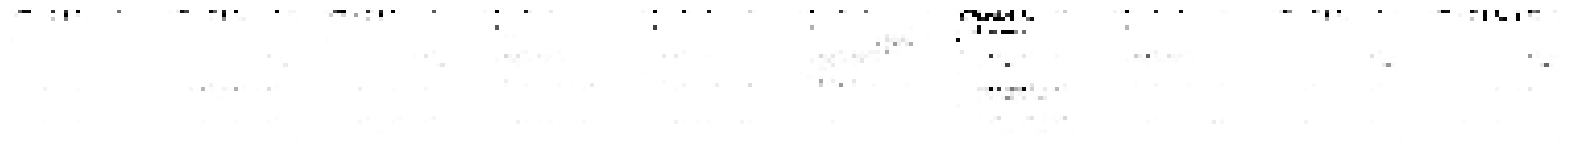

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 736ms/step - c_gp: 0.0058 - c_loss: -0.3792 - c_wass_loss: -0.4374 - g_loss: -8.8337
Epoch 406/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - c_gp: 0.0050 - c_loss: -0.4574 - c_wass_loss: -0.5079 - g_loss: -10.0397
Epoch 407/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - c_gp: 0.0078 - c_loss: -1.0003 - c_wass_loss: -1.0779 - g_loss: -11.9651
Epoch 408/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0067 - c_loss: -0.9176 - c_wass_loss: -0.9844 - g_loss: -12.4478
Epoch 409/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - c_gp: 0.0051 - c_loss: -1.1315 - c_wass_loss: -1.1825 - g_loss: -12.0130
Epoch 410/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - c_gp: 0.0052 - c_loss: -0.7740 - c_wass_loss: -0.8257 - g_loss: -10.5945
Saved to ./output/generated_img_409.png


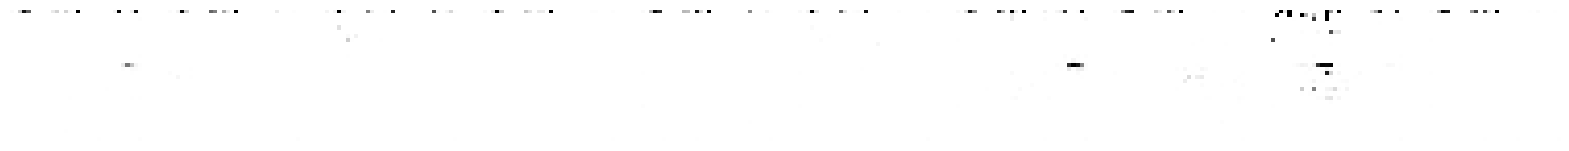

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 776ms/step - c_gp: 0.0057 - c_loss: -0.8717 - c_wass_loss: -0.9285 - g_loss: -10.2485
Epoch 411/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0042 - c_loss: -0.4352 - c_wass_loss: -0.4770 - g_loss: -8.3963
Epoch 412/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - c_gp: 0.0049 - c_loss: -0.5505 - c_wass_loss: -0.5990 - g_loss: -7.0838
Epoch 413/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0068 - c_loss: -0.7700 - c_wass_loss: -0.8379 - g_loss: -6.2939
Epoch 414/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0073 - c_loss: -0.4962 - c_wass_loss: -0.5688 - g_loss: -5.7954
Epoch 415/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - c_gp: 0.0061 - c_loss: -0.4848 - c_wass_loss: -0.5460 - g_loss: -6.7827
Saved to ./output/generated_img_414.png


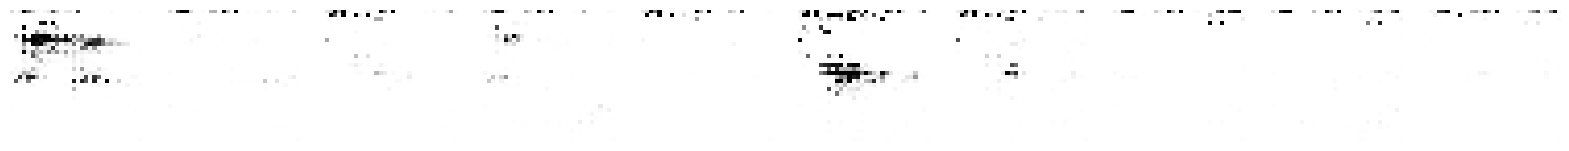

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step - c_gp: 0.0060 - c_loss: -0.3758 - c_wass_loss: -0.4360 - g_loss: -7.0698
Epoch 416/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0049 - c_loss: -0.3038 - c_wass_loss: -0.3523 - g_loss: -9.0506
Epoch 417/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - c_gp: 0.0069 - c_loss: -0.5035 - c_wass_loss: -0.5724 - g_loss: -11.5652
Epoch 418/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0065 - c_loss: -0.9202 - c_wass_loss: -0.9848 - g_loss: -13.4308
Epoch 419/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0055 - c_loss: -0.5720 - c_wass_loss: -0.6268 - g_loss: -13.2615
Epoch 420/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0043 - c_loss: -0.7201 - c_wass_loss: -0.7630 - g_loss: -12.5088
Saved to ./output/generated_img_419.png


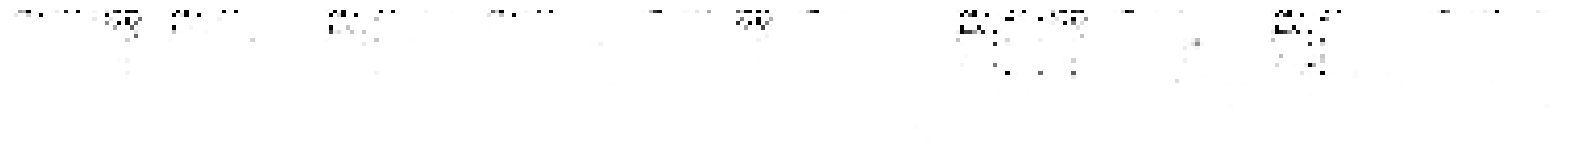

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 722ms/step - c_gp: 0.0045 - c_loss: -0.8151 - c_wass_loss: -0.8605 - g_loss: -12.2552
Epoch 421/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0037 - c_loss: -0.5869 - c_wass_loss: -0.6240 - g_loss: -10.5767
Epoch 422/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0035 - c_loss: -0.6043 - c_wass_loss: -0.6395 - g_loss: -8.8016
Epoch 423/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - c_gp: 0.0050 - c_loss: -0.6848 - c_wass_loss: -0.7347 - g_loss: -7.1409
Epoch 424/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - c_gp: 0.0053 - c_loss: -0.5608 - c_wass_loss: -0.6134 - g_loss: -6.5122
Epoch 425/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - c_gp: 0.0064 - c_loss: -0.5287 - c_wass_loss: -0.5926 - g_loss: -6.8812
Saved to ./output/generated_img_424.png


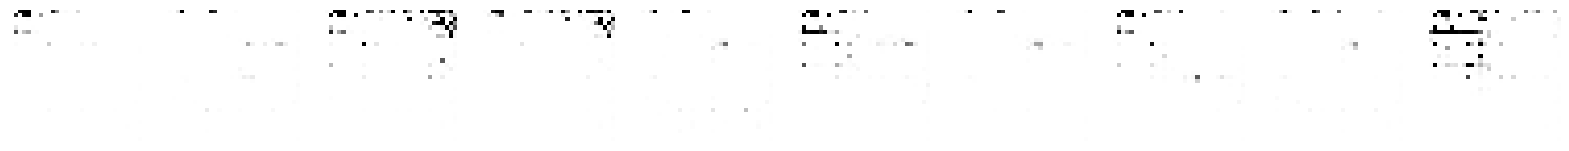

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 727ms/step - c_gp: 0.0062 - c_loss: -0.4383 - c_wass_loss: -0.5003 - g_loss: -6.7637
Epoch 426/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0063 - c_loss: -0.7125 - c_wass_loss: -0.7754 - g_loss: -6.5535
Epoch 427/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0081 - c_loss: -0.7522 - c_wass_loss: -0.8330 - g_loss: -7.5806
Epoch 428/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0078 - c_loss: -0.8924 - c_wass_loss: -0.9703 - g_loss: -9.3038
Epoch 429/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - c_gp: 0.0076 - c_loss: -0.7168 - c_wass_loss: -0.7931 - g_loss: -11.2069
Epoch 430/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - c_gp: 0.0066 - c_loss: -0.5925 - c_wass_loss: -0.6590 - g_loss: -12.4945
Saved to ./output/generated_img_429.png


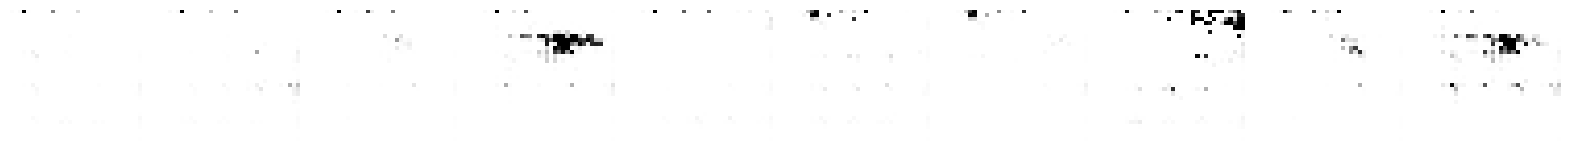

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 714ms/step - c_gp: 0.0067 - c_loss: -0.5939 - c_wass_loss: -0.6608 - g_loss: -12.8229
Epoch 431/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - c_gp: 0.0057 - c_loss: -0.5238 - c_wass_loss: -0.5805 - g_loss: -14.1296
Epoch 432/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 598ms/step - c_gp: 0.0056 - c_loss: -0.8433 - c_wass_loss: -0.8990 - g_loss: -13.2626
Epoch 433/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 607ms/step - c_gp: 0.0052 - c_loss: -0.2612 - c_wass_loss: -0.3128 - g_loss: -11.5038
Epoch 434/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 590ms/step - c_gp: 0.0051 - c_loss: -0.7032 - c_wass_loss: -0.7542 - g_loss: -9.5180
Epoch 435/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - c_gp: 0.0058 - c_loss: -0.6448 - c_wass_loss: -0.7030 - g_loss: -9.9254
Saved to ./output/generated_img_434.png


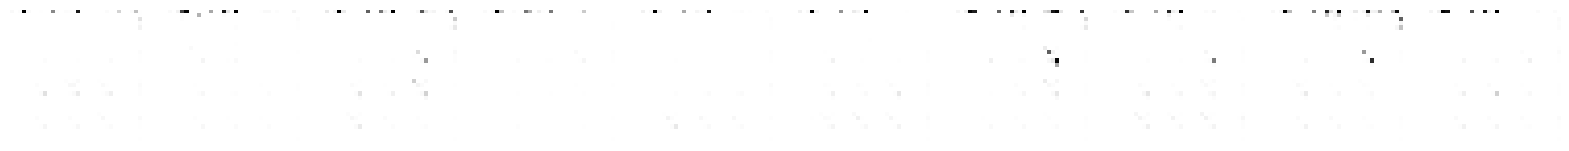

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 878ms/step - c_gp: 0.0060 - c_loss: -0.5117 - c_wass_loss: -0.5721 - g_loss: -9.8896
Epoch 436/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - c_gp: 0.0065 - c_loss: -0.9782 - c_wass_loss: -1.0431 - g_loss: -10.7473
Epoch 437/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - c_gp: 0.0044 - c_loss: -0.5458 - c_wass_loss: -0.5897 - g_loss: -11.9146
Epoch 438/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.0040 - c_loss: -0.3810 - c_wass_loss: -0.4210 - g_loss: -11.8600
Epoch 439/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0034 - c_loss: -0.0862 - c_wass_loss: -0.1201 - g_loss: -11.6294
Epoch 440/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - c_gp: 0.0040 - c_loss: -0.3616 - c_wass_loss: -0.4018 - g_loss: -11.3491
Saved to ./output/generated_img_439.png


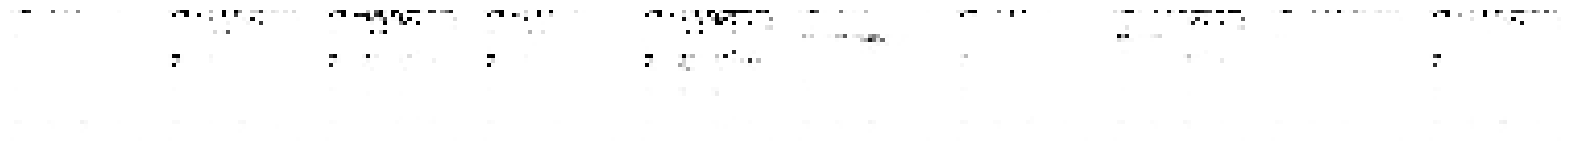

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - c_gp: 0.0044 - c_loss: -0.3235 - c_wass_loss: -0.3678 - g_loss: -11.4108
Epoch 441/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step - c_gp: 0.0036 - c_loss: -0.2982 - c_wass_loss: -0.3344 - g_loss: -11.5019
Epoch 442/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - c_gp: 0.0036 - c_loss: -0.3048 - c_wass_loss: -0.3407 - g_loss: -12.5515
Epoch 443/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - c_gp: 0.0035 - c_loss: -0.5457 - c_wass_loss: -0.5810 - g_loss: -14.3400
Epoch 444/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0037 - c_loss: -0.4833 - c_wass_loss: -0.5206 - g_loss: -14.8217
Epoch 445/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - c_gp: 0.0041 - c_loss: -0.7236 - c_wass_loss: -0.7648 - g_loss: -14.1502
Saved to ./output/generated_img_444.png


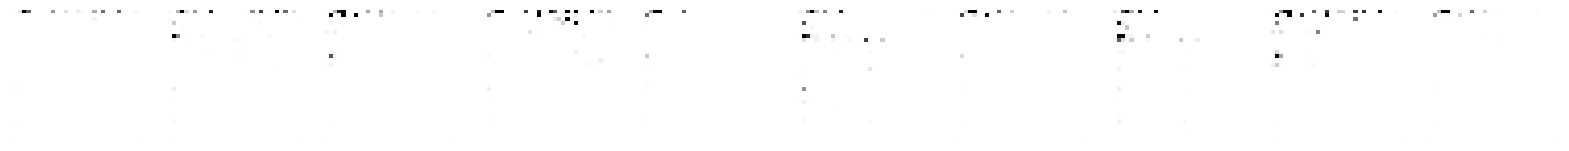

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 719ms/step - c_gp: 0.0041 - c_loss: -0.7456 - c_wass_loss: -0.7865 - g_loss: -13.9370
Epoch 446/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0043 - c_loss: -0.3103 - c_wass_loss: -0.3532 - g_loss: -11.6975
Epoch 447/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - c_gp: 0.0043 - c_loss: -0.4292 - c_wass_loss: -0.4724 - g_loss: -9.2171
Epoch 448/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0055 - c_loss: -0.5303 - c_wass_loss: -0.5848 - g_loss: -6.8501
Epoch 449/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0069 - c_loss: -0.6337 - c_wass_loss: -0.7027 - g_loss: -4.8426
Epoch 450/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - c_gp: 0.0071 - c_loss: -0.6772 - c_wass_loss: -0.7487 - g_loss: -4.8590
Saved to ./output/generated_img_449.png


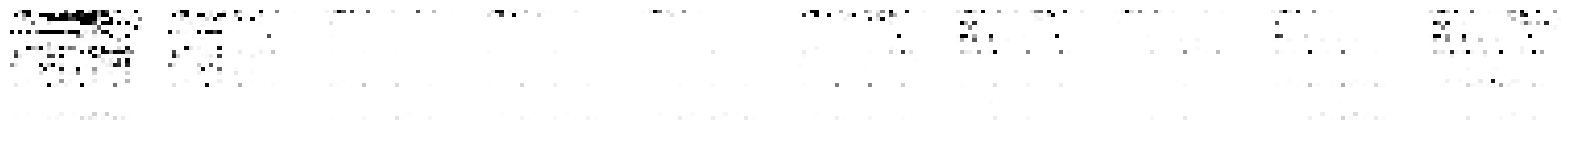

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 762ms/step - c_gp: 0.0073 - c_loss: -0.6881 - c_wass_loss: -0.7609 - g_loss: -4.6810
Epoch 451/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - c_gp: 0.0071 - c_loss: -0.4145 - c_wass_loss: -0.4851 - g_loss: -6.1973
Epoch 452/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - c_gp: 0.0058 - c_loss: -0.7196 - c_wass_loss: -0.7774 - g_loss: -9.7174
Epoch 453/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0069 - c_loss: -0.8969 - c_wass_loss: -0.9659 - g_loss: -12.9323
Epoch 454/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - c_gp: 0.0060 - c_loss: -0.7090 - c_wass_loss: -0.7689 - g_loss: -13.5204
Epoch 455/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - c_gp: 0.0036 - c_loss: -0.1642 - c_wass_loss: -0.2004 - g_loss: -13.1314
Saved to ./output/generated_img_454.png


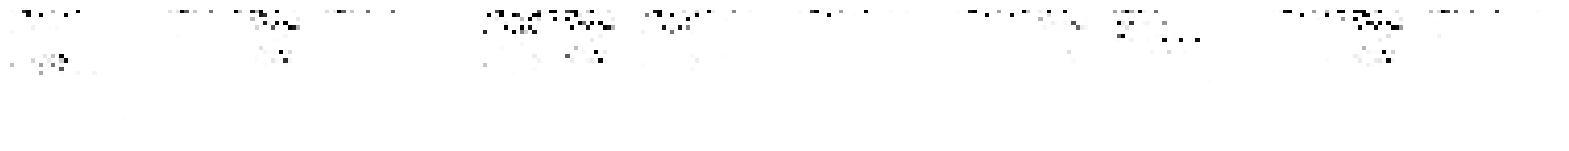

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 765ms/step - c_gp: 0.0037 - c_loss: -0.0100 - c_wass_loss: -0.0471 - g_loss: -13.0819
Epoch 456/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0027 - c_loss: -0.4810 - c_wass_loss: -0.5077 - g_loss: -10.9797
Epoch 457/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - c_gp: 0.0029 - c_loss: -0.5394 - c_wass_loss: -0.5683 - g_loss: -9.5254
Epoch 458/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - c_gp: 0.0024 - c_loss: -0.4993 - c_wass_loss: -0.5237 - g_loss: -7.3967
Epoch 459/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0040 - c_loss: -0.7605 - c_wass_loss: -0.8003 - g_loss: -5.0091
Epoch 460/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - c_gp: 0.0067 - c_loss: -0.8938 - c_wass_loss: -0.9605 - g_loss: -3.7473
Saved to ./output/generated_img_459.png


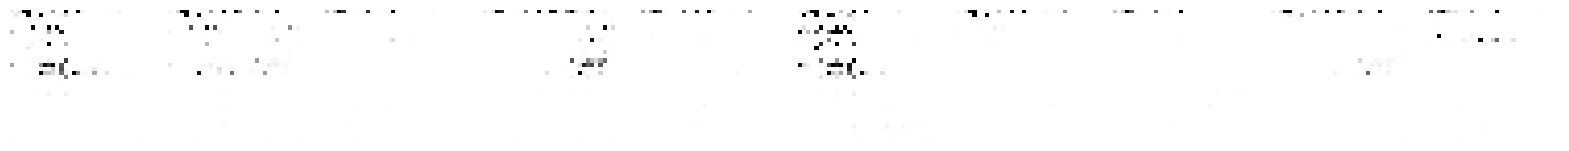

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 715ms/step - c_gp: 0.0077 - c_loss: -0.9208 - c_wass_loss: -0.9975 - g_loss: -3.5642
Epoch 461/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0091 - c_loss: -0.8402 - c_wass_loss: -0.9309 - g_loss: -3.5555
Epoch 462/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step - c_gp: 0.0092 - c_loss: -0.4273 - c_wass_loss: -0.5195 - g_loss: -5.9892
Epoch 463/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0099 - c_loss: -0.5663 - c_wass_loss: -0.6652 - g_loss: -9.1448
Epoch 464/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0088 - c_loss: -1.0243 - c_wass_loss: -1.1121 - g_loss: -9.8516 
Epoch 465/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_gp: 0.0059 - c_loss: -0.6924 - c_wass_loss: -0.7509 - g_loss: -8.8842
Saved to ./output/generated_img_464.png


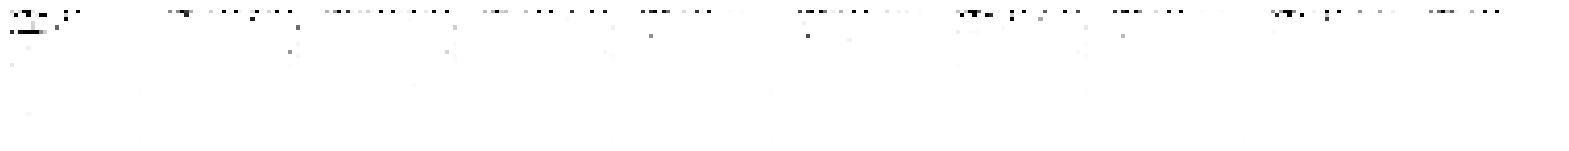

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step - c_gp: 0.0053 - c_loss: -0.5604 - c_wass_loss: -0.6132 - g_loss: -8.7431
Epoch 466/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - c_gp: 0.0041 - c_loss: -0.8537 - c_wass_loss: -0.8951 - g_loss: -7.1613
Epoch 467/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0043 - c_loss: -0.4065 - c_wass_loss: -0.4494 - g_loss: -5.4974
Epoch 468/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0045 - c_loss: -0.5599 - c_wass_loss: -0.6046 - g_loss: -5.0845
Epoch 469/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - c_gp: 0.0041 - c_loss: -0.4130 - c_wass_loss: -0.4537 - g_loss: -4.6803
Epoch 470/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - c_gp: 0.0045 - c_loss: -0.5637 - c_wass_loss: -0.6083 - g_loss: -5.2724
Saved to ./output/generated_img_469.png


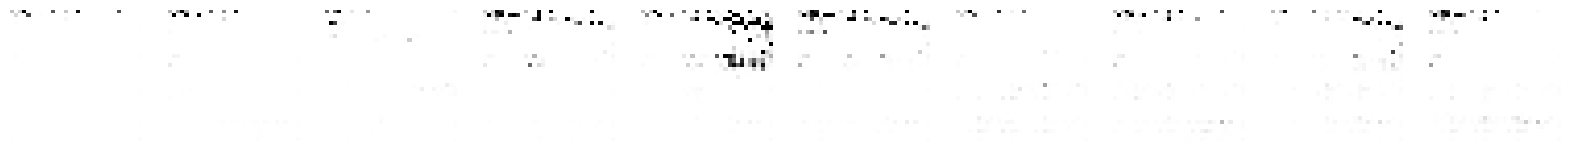

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 722ms/step - c_gp: 0.0042 - c_loss: -0.5892 - c_wass_loss: -0.6315 - g_loss: -5.3441
Epoch 471/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - c_gp: 0.0043 - c_loss: -0.1814 - c_wass_loss: -0.2240 - g_loss: -7.3126
Epoch 472/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0054 - c_loss: -0.2612 - c_wass_loss: -0.3151 - g_loss: -9.9329
Epoch 473/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - c_gp: 0.0046 - c_loss: -0.6626 - c_wass_loss: -0.7083 - g_loss: -11.7456
Epoch 474/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0054 - c_loss: -0.5916 - c_wass_loss: -0.6460 - g_loss: -12.2019
Epoch 475/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0037 - c_loss: -0.7629 - c_wass_loss: -0.8004 - g_loss: -11.5453
Saved to ./output/generated_img_474.png


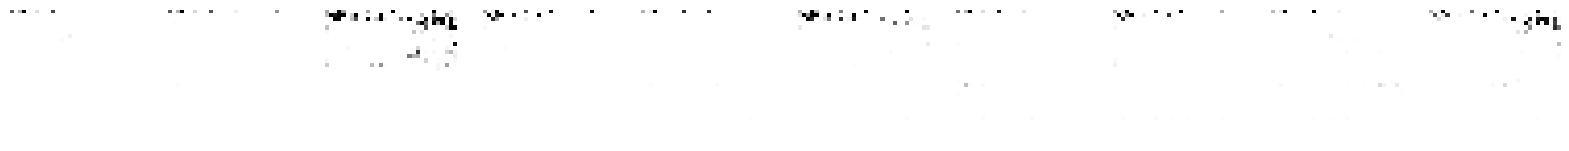

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step - c_gp: 0.0036 - c_loss: -0.9251 - c_wass_loss: -0.9614 - g_loss: -11.4772
Epoch 476/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0038 - c_loss: -0.2820 - c_wass_loss: -0.3199 - g_loss: -10.5632
Epoch 477/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - c_gp: 0.0038 - c_loss: -0.4345 - c_wass_loss: -0.4729 - g_loss: -9.6516
Epoch 478/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0042 - c_loss: -0.6375 - c_wass_loss: -0.6798 - g_loss: -8.3616
Epoch 479/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0079 - c_loss: -0.6705 - c_wass_loss: -0.7497 - g_loss: -6.4248
Epoch 480/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - c_gp: 0.0091 - c_loss: -0.7526 - c_wass_loss: -0.8433 - g_loss: -6.2647
Saved to ./output/generated_img_479.png


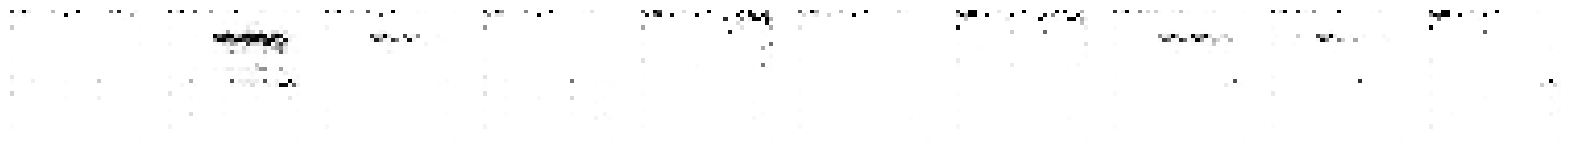

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 722ms/step - c_gp: 0.0093 - c_loss: -0.6675 - c_wass_loss: -0.7607 - g_loss: -6.2878
Epoch 481/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0081 - c_loss: -0.8675 - c_wass_loss: -0.9482 - g_loss: -7.9045
Epoch 482/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - c_gp: 0.0079 - c_loss: -1.2842 - c_wass_loss: -1.3631 - g_loss: -9.6288
Epoch 483/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0076 - c_loss: -0.7990 - c_wass_loss: -0.8753 - g_loss: -11.6895
Epoch 484/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0074 - c_loss: -0.9174 - c_wass_loss: -0.9909 - g_loss: -13.1103
Epoch 485/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - c_gp: 0.0063 - c_loss: -0.7725 - c_wass_loss: -0.8351 - g_loss: -12.9629
Saved to ./output/generated_img_484.png


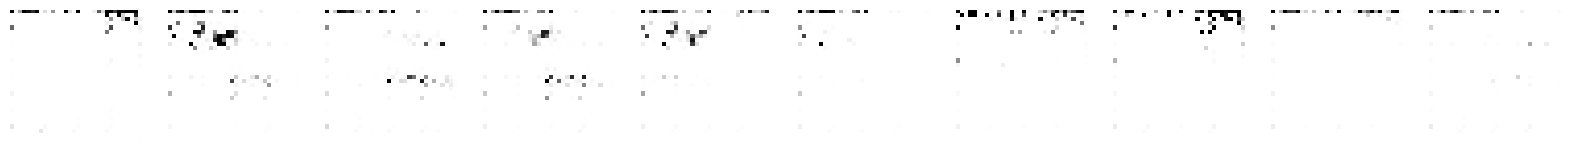

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - c_gp: 0.0061 - c_loss: -0.8355 - c_wass_loss: -0.8966 - g_loss: -12.9942
Epoch 486/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.0050 - c_loss: -0.1408 - c_wass_loss: -0.1912 - g_loss: -12.0768
Epoch 487/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0054 - c_loss: -0.1163 - c_wass_loss: -0.1703 - g_loss: -12.1445
Epoch 488/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - c_gp: 0.0049 - c_loss: -0.3192 - c_wass_loss: -0.3679 - g_loss: -10.9614
Epoch 489/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - c_gp: 0.0075 - c_loss: -0.8231 - c_wass_loss: -0.8985 - g_loss: -10.0471
Epoch 490/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - c_gp: 0.0072 - c_loss: -0.5879 - c_wass_loss: -0.6594 - g_loss: -9.8438
Saved to ./output/generated_img_489.png


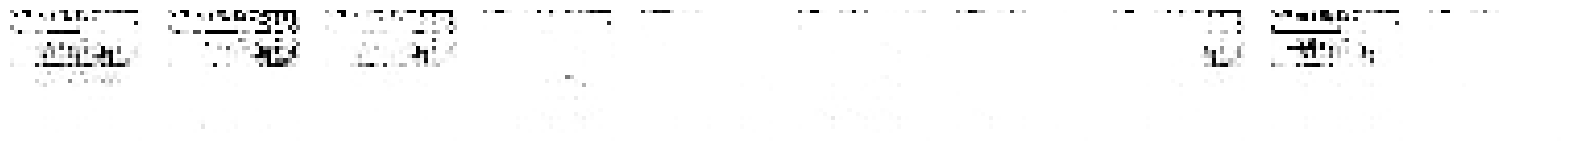

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 794ms/step - c_gp: 0.0083 - c_loss: -0.5877 - c_wass_loss: -0.6704 - g_loss: -10.3698
Epoch 491/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0044 - c_loss: -0.6084 - c_wass_loss: -0.6526 - g_loss: -12.4725
Epoch 492/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0058 - c_loss: -0.5729 - c_wass_loss: -0.6306 - g_loss: -14.4698
Epoch 493/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - c_gp: 0.0059 - c_loss: -0.4357 - c_wass_loss: -0.4947 - g_loss: -13.9219
Epoch 494/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0033 - c_loss: -0.7407 - c_wass_loss: -0.7736 - g_loss: -12.5118
Epoch 495/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - c_gp: 0.0034 - c_loss: -0.4131 - c_wass_loss: -0.4468 - g_loss: -11.5374
Saved to ./output/generated_img_494.png


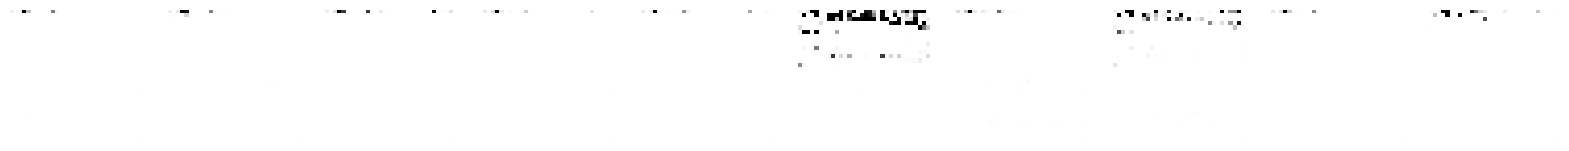

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 715ms/step - c_gp: 0.0032 - c_loss: -0.3750 - c_wass_loss: -0.4067 - g_loss: -11.1208
Epoch 496/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step - c_gp: 0.0040 - c_loss: -0.3011 - c_wass_loss: -0.3409 - g_loss: -9.6086
Epoch 497/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0041 - c_loss: -0.4784 - c_wass_loss: -0.5197 - g_loss: -9.6997
Epoch 498/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0048 - c_loss: -0.5485 - c_wass_loss: -0.5965 - g_loss: -10.9872
Epoch 499/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0053 - c_loss: -0.5587 - c_wass_loss: -0.6119 - g_loss: -11.6079
Epoch 500/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - c_gp: 0.0048 - c_loss: -0.9501 - c_wass_loss: -0.9982 - g_loss: -11.1685
Saved to ./output/generated_img_499.png


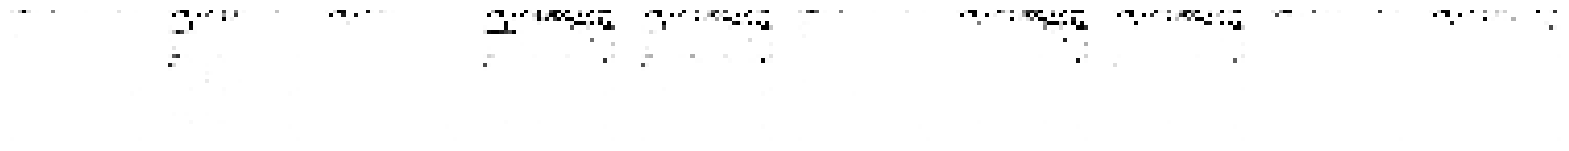

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 776ms/step - c_gp: 0.0049 - c_loss: -0.9513 - c_wass_loss: -1.0003 - g_loss: -11.1200
Epoch 501/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.0041 - c_loss: -0.9967 - c_wass_loss: -1.0375 - g_loss: -10.8957
Epoch 502/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0051 - c_loss: -0.5463 - c_wass_loss: -0.5974 - g_loss: -8.6136
Epoch 503/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0057 - c_loss: -0.4549 - c_wass_loss: -0.5121 - g_loss: -7.3801
Epoch 504/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0056 - c_loss: -0.4536 - c_wass_loss: -0.5092 - g_loss: -7.2886
Epoch 505/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - c_gp: 0.0072 - c_loss: -0.2828 - c_wass_loss: -0.3551 - g_loss: -8.5372
Saved to ./output/generated_img_504.png


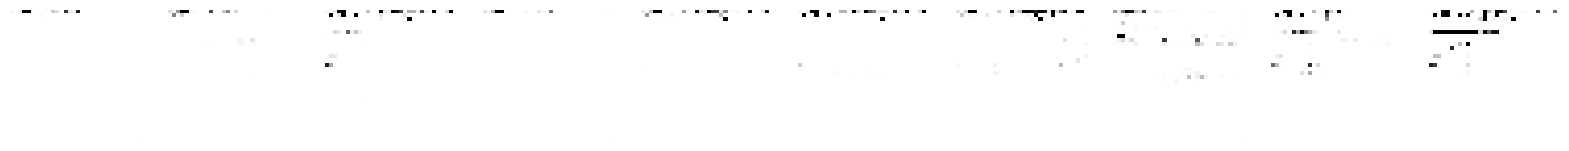

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 707ms/step - c_gp: 0.0078 - c_loss: -0.1721 - c_wass_loss: -0.2500 - g_loss: -9.1350
Epoch 506/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0047 - c_loss: -0.3180 - c_wass_loss: -0.3652 - g_loss: -13.5255
Epoch 507/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0054 - c_loss: -0.6253 - c_wass_loss: -0.6798 - g_loss: -16.0031
Epoch 508/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0044 - c_loss: -0.4363 - c_wass_loss: -0.4805 - g_loss: -14.7055
Epoch 509/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - c_gp: 0.0050 - c_loss: -0.7972 - c_wass_loss: -0.8472 - g_loss: -12.8955
Epoch 510/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - c_gp: 0.0042 - c_loss: -0.5251 - c_wass_loss: -0.5674 - g_loss: -10.8356
Saved to ./output/generated_img_509.png


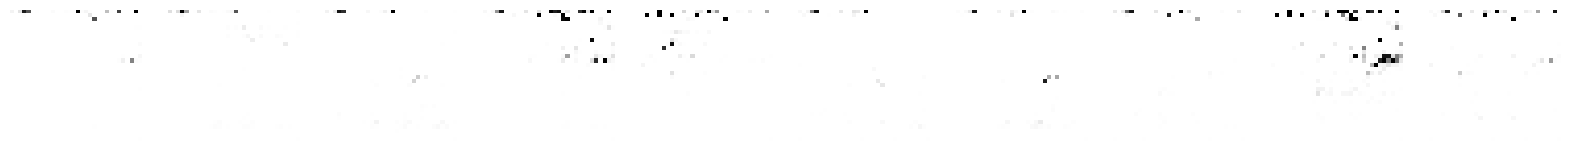

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step - c_gp: 0.0042 - c_loss: -0.5151 - c_wass_loss: -0.5575 - g_loss: -10.4210
Epoch 511/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - c_gp: 0.0058 - c_loss: -0.3775 - c_wass_loss: -0.4354 - g_loss: -8.2447
Epoch 512/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step - c_gp: 0.0071 - c_loss: -0.3520 - c_wass_loss: -0.4228 - g_loss: -7.9951
Epoch 513/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - c_gp: 0.0054 - c_loss: -0.4012 - c_wass_loss: -0.4548 - g_loss: -10.4787
Epoch 514/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - c_gp: 0.0043 - c_loss: -0.2962 - c_wass_loss: -0.3396 - g_loss: -13.4171
Epoch 515/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - c_gp: 0.0036 - c_loss: -0.6011 - c_wass_loss: -0.6370 - g_loss: -15.6880
Saved to ./output/generated_img_514.png


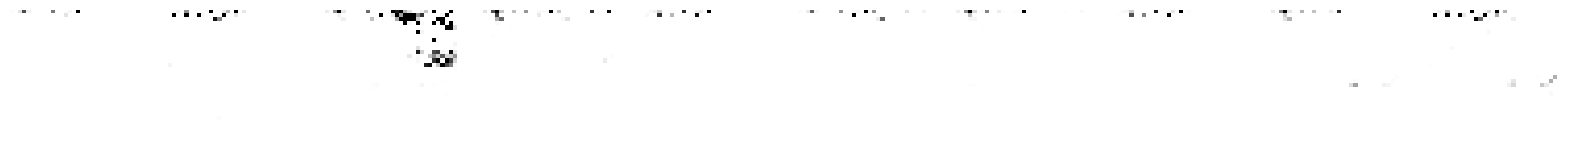

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step - c_gp: 0.0037 - c_loss: -0.6150 - c_wass_loss: -0.6522 - g_loss: -16.0173
Epoch 516/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - c_gp: 0.0039 - c_loss: -0.6845 - c_wass_loss: -0.7236 - g_loss: -16.1349
Epoch 517/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 585ms/step - c_gp: 0.0033 - c_loss: -0.5654 - c_wass_loss: -0.5984 - g_loss: -14.9064
Epoch 518/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - c_gp: 0.0041 - c_loss: -0.9060 - c_wass_loss: -0.9467 - g_loss: -13.5275
Epoch 519/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - c_gp: 0.0035 - c_loss: -0.7549 - c_wass_loss: -0.7899 - g_loss: -12.0310
Epoch 520/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - c_gp: 0.0040 - c_loss: -0.7121 - c_wass_loss: -0.7520 - g_loss: -9.8843
Saved to ./output/generated_img_519.png


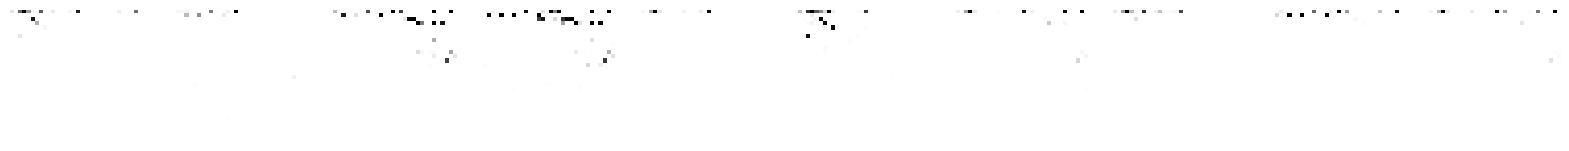

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step - c_gp: 0.0040 - c_loss: -0.6556 - c_wass_loss: -0.6954 - g_loss: -9.7373
Epoch 521/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - c_gp: 0.0044 - c_loss: -0.7630 - c_wass_loss: -0.8065 - g_loss: -7.1658
Epoch 522/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - c_gp: 0.0058 - c_loss: -0.6822 - c_wass_loss: -0.7406 - g_loss: -4.9000
Epoch 523/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - c_gp: 0.0090 - c_loss: -0.7841 - c_wass_loss: -0.8745 - g_loss: -3.6185
Epoch 524/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step - c_gp: 0.0082 - c_loss: -0.7432 - c_wass_loss: -0.8253 - g_loss: -4.7517
Epoch 525/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - c_gp: 0.0067 - c_loss: -0.2434 - c_wass_loss: -0.3107 - g_loss: -6.9713
Saved to ./output/generated_img_524.png


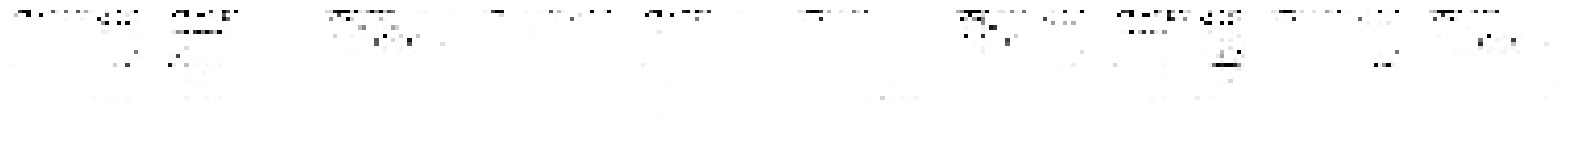

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 708ms/step - c_gp: 0.0063 - c_loss: -0.3032 - c_wass_loss: -0.3658 - g_loss: -7.1956
Epoch 526/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - c_gp: 0.0051 - c_loss: -0.2866 - c_wass_loss: -0.3380 - g_loss: -9.5895
Epoch 527/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - c_gp: 0.0057 - c_loss: -0.5502 - c_wass_loss: -0.6071 - g_loss: -12.3171
Epoch 528/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - c_gp: 0.0049 - c_loss: -0.1930 - c_wass_loss: -0.2423 - g_loss: -12.4185
Epoch 529/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - c_gp: 0.0052 - c_loss: -0.3373 - c_wass_loss: -0.3890 - g_loss: -11.8143
Epoch 530/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0028 - c_loss: -0.4258 - c_wass_loss: -0.4540 - g_loss: -10.8370
Saved to ./output/generated_img_529.png


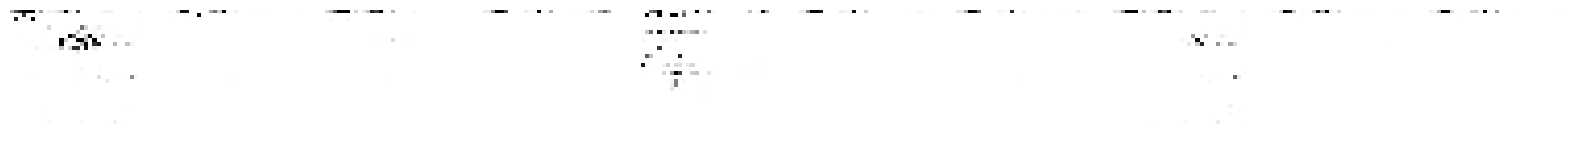

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 741ms/step - c_gp: 0.0026 - c_loss: -0.4149 - c_wass_loss: -0.4409 - g_loss: -10.7482
Epoch 531/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0033 - c_loss: -0.2296 - c_wass_loss: -0.2626 - g_loss: -9.4630
Epoch 532/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - c_gp: 0.0040 - c_loss: -0.8299 - c_wass_loss: -0.8697 - g_loss: -7.0842
Epoch 533/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - c_gp: 0.0047 - c_loss: -0.5472 - c_wass_loss: -0.5944 - g_loss: -4.8275
Epoch 534/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0075 - c_loss: -0.9411 - c_wass_loss: -1.0160 - g_loss: -4.9538
Epoch 535/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - c_gp: 0.0067 - c_loss: -0.8713 - c_wass_loss: -0.9379 - g_loss: -6.6156
Saved to ./output/generated_img_534.png


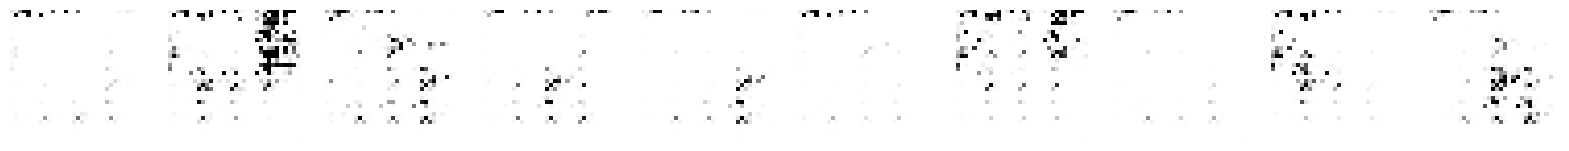

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 950ms/step - c_gp: 0.0067 - c_loss: -0.8284 - c_wass_loss: -0.8957 - g_loss: -6.9710
Epoch 536/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - c_gp: 0.0064 - c_loss: -0.8700 - c_wass_loss: -0.9340 - g_loss: -9.5249
Epoch 537/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - c_gp: 0.0065 - c_loss: -0.8203 - c_wass_loss: -0.8848 - g_loss: -12.7003
Epoch 538/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - c_gp: 0.0069 - c_loss: -1.1665 - c_wass_loss: -1.2357 - g_loss: -15.0167
Epoch 539/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0072 - c_loss: -0.4907 - c_wass_loss: -0.5625 - g_loss: -15.9758
Epoch 540/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - c_gp: 0.0054 - c_loss: -0.3672 - c_wass_loss: -0.4216 - g_loss: -15.8245
Saved to ./output/generated_img_539.png


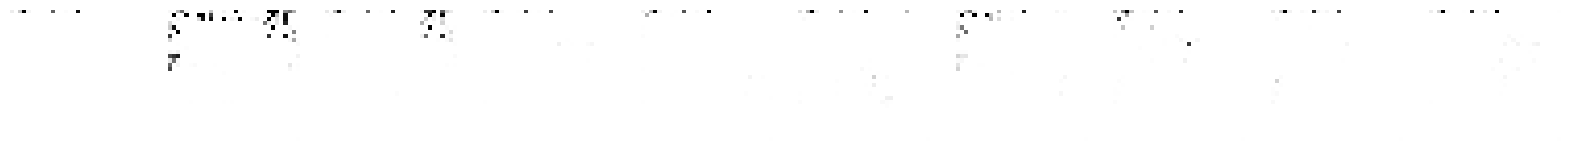

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 828ms/step - c_gp: 0.0056 - c_loss: -0.0917 - c_wass_loss: -0.1475 - g_loss: -15.5744
Epoch 541/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0049 - c_loss: -0.7805 - c_wass_loss: -0.8300 - g_loss: -13.8682
Epoch 542/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0044 - c_loss: -0.3438 - c_wass_loss: -0.3877 - g_loss: -12.8501
Epoch 543/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.0057 - c_loss: -0.1376 - c_wass_loss: -0.1945 - g_loss: -11.8542
Epoch 544/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0055 - c_loss: -0.4776 - c_wass_loss: -0.5328 - g_loss: -11.6452
Epoch 545/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - c_gp: 0.0053 - c_loss: -0.5848 - c_wass_loss: -0.6380 - g_loss: -11.5614
Saved to ./output/generated_img_544.png


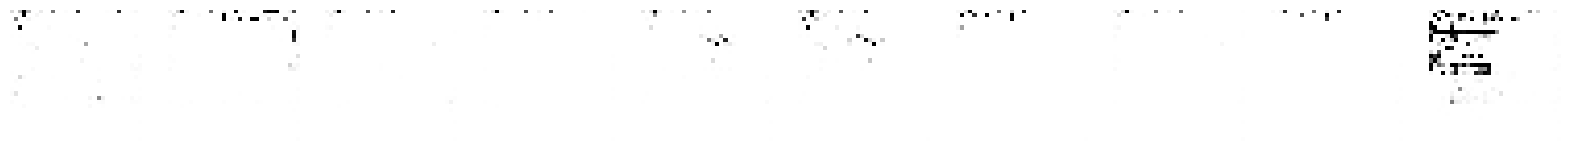

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step - c_gp: 0.0057 - c_loss: -0.5856 - c_wass_loss: -0.6430 - g_loss: -11.9050
Epoch 546/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - c_gp: 0.0053 - c_loss: -0.4719 - c_wass_loss: -0.5252 - g_loss: -12.9465
Epoch 547/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - c_gp: 0.0043 - c_loss: -0.3642 - c_wass_loss: -0.4073 - g_loss: -12.7877
Epoch 548/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - c_gp: 0.0038 - c_loss: -0.7669 - c_wass_loss: -0.8053 - g_loss: -12.7398
Epoch 549/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - c_gp: 0.0044 - c_loss: -0.4596 - c_wass_loss: -0.5037 - g_loss: -13.1081
Epoch 550/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - c_gp: 0.0036 - c_loss: -0.3941 - c_wass_loss: -0.4298 - g_loss: -13.3314
Saved to ./output/generated_img_549.png


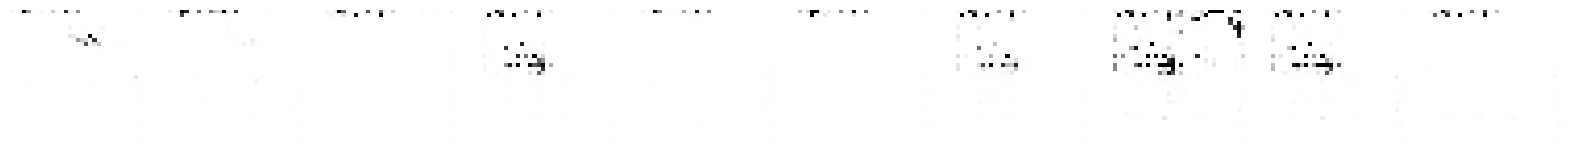

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - c_gp: 0.0035 - c_loss: -0.4495 - c_wass_loss: -0.4846 - g_loss: -13.1903
Epoch 551/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 703ms/step - c_gp: 0.0035 - c_loss: -0.0887 - c_wass_loss: -0.1238 - g_loss: -13.2996
Epoch 552/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0038 - c_loss: -0.0580 - c_wass_loss: -0.0962 - g_loss: -12.2967
Epoch 553/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0041 - c_loss: -0.4863 - c_wass_loss: -0.5273 - g_loss: -12.2245
Epoch 554/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0042 - c_loss: -0.5480 - c_wass_loss: -0.5896 - g_loss: -13.2113
Epoch 555/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - c_gp: 0.0047 - c_loss: -0.3559 - c_wass_loss: -0.4028 - g_loss: -14.2078
Saved to ./output/generated_img_554.png


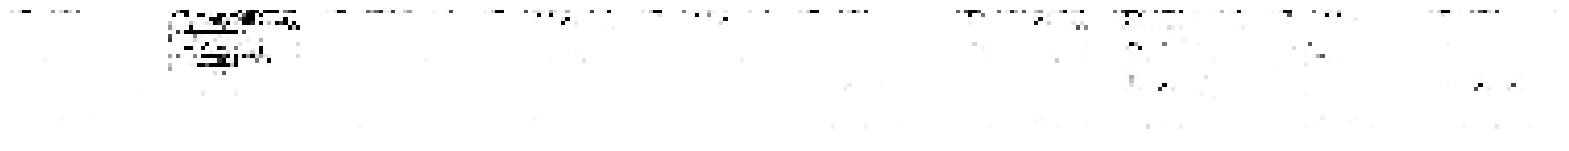

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step - c_gp: 0.0045 - c_loss: -0.3392 - c_wass_loss: -0.3840 - g_loss: -13.9972
Epoch 556/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - c_gp: 0.0046 - c_loss: -0.5720 - c_wass_loss: -0.6178 - g_loss: -13.6269
Epoch 557/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.0037 - c_loss: -0.1203 - c_wass_loss: -0.1573 - g_loss: -12.4897
Epoch 558/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - c_gp: 0.0043 - c_loss: -0.2482 - c_wass_loss: -0.2913 - g_loss: -10.8524
Epoch 559/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0047 - c_loss: -0.8001 - c_wass_loss: -0.8472 - g_loss: -8.5072
Epoch 560/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0060 - c_loss: -0.4110 - c_wass_loss: -0.4714 - g_loss: -7.5303
Saved to ./output/generated_img_559.png


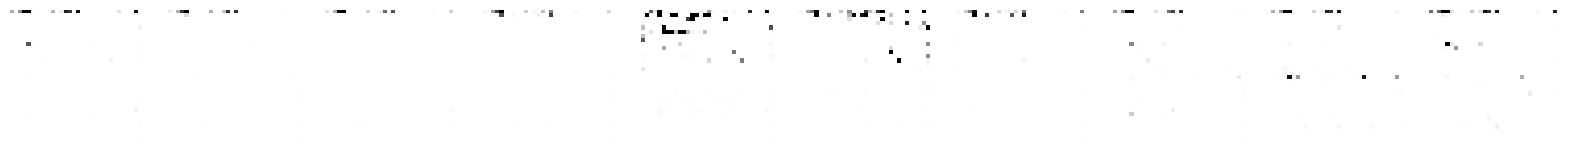

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step - c_gp: 0.0056 - c_loss: -0.3295 - c_wass_loss: -0.3851 - g_loss: -7.5413
Epoch 561/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - c_gp: 0.0080 - c_loss: -0.8792 - c_wass_loss: -0.9590 - g_loss: -6.9375
Epoch 562/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0088 - c_loss: -0.2847 - c_wass_loss: -0.3727 - g_loss: -7.4619
Epoch 563/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - c_gp: 0.0066 - c_loss: -0.4046 - c_wass_loss: -0.4705 - g_loss: -9.0820
Epoch 564/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0061 - c_loss: -0.6362 - c_wass_loss: -0.6968 - g_loss: -10.9656
Epoch 565/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - c_gp: 0.0066 - c_loss: -0.5538 - c_wass_loss: -0.6200 - g_loss: -12.6295
Saved to ./output/generated_img_564.png


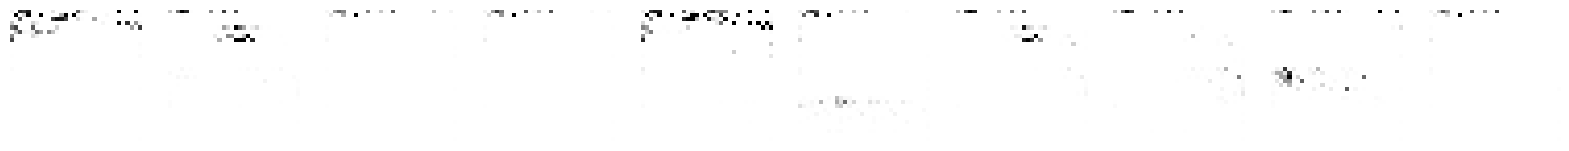

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 775ms/step - c_gp: 0.0067 - c_loss: -0.6015 - c_wass_loss: -0.6687 - g_loss: -12.7578
Epoch 566/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - c_gp: 0.0053 - c_loss: -0.0953 - c_wass_loss: -0.1479 - g_loss: -13.4516
Epoch 567/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step - c_gp: 0.0040 - c_loss: 0.0074 - c_wass_loss: -0.0322 - g_loss: -12.8129 
Epoch 568/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - c_gp: 0.0041 - c_loss: -0.1077 - c_wass_loss: -0.1490 - g_loss: -11.3743
Epoch 569/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - c_gp: 0.0039 - c_loss: -0.3143 - c_wass_loss: -0.3537 - g_loss: -10.1481
Epoch 570/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - c_gp: 0.0037 - c_loss: -0.2753 - c_wass_loss: -0.3127 - g_loss: -10.3462
Saved to ./output/generated_img_569.png


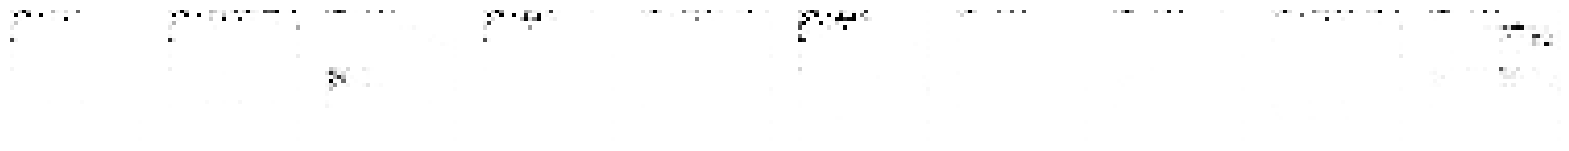

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step - c_gp: 0.0037 - c_loss: -0.3053 - c_wass_loss: -0.3420 - g_loss: -10.3665
Epoch 571/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - c_gp: 0.0035 - c_loss: -0.0657 - c_wass_loss: -0.1009 - g_loss: -10.4346
Epoch 572/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0048 - c_loss: -0.3589 - c_wass_loss: -0.4066 - g_loss: -10.2087
Epoch 573/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - c_gp: 0.0055 - c_loss: -0.6746 - c_wass_loss: -0.7296 - g_loss: -10.7746
Epoch 574/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0052 - c_loss: -0.8129 - c_wass_loss: -0.8652 - g_loss: -11.7622
Epoch 575/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - c_gp: 0.0060 - c_loss: -0.8210 - c_wass_loss: -0.8807 - g_loss: -12.4909
Saved to ./output/generated_img_574.png


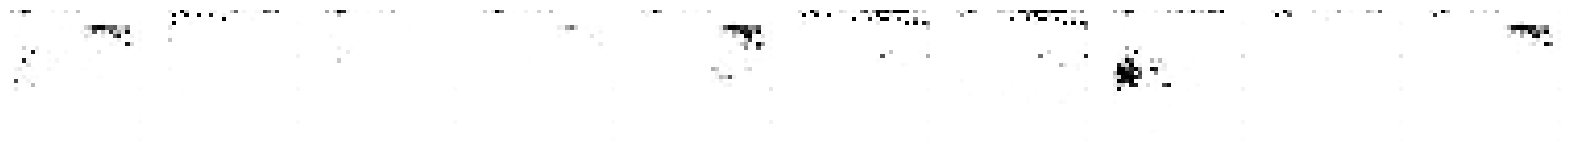

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 768ms/step - c_gp: 0.0053 - c_loss: -0.8319 - c_wass_loss: -0.8845 - g_loss: -12.4750
Epoch 576/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0056 - c_loss: -0.5004 - c_wass_loss: -0.5565 - g_loss: -11.1484
Epoch 577/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0056 - c_loss: -0.4788 - c_wass_loss: -0.5345 - g_loss: -10.1136
Epoch 578/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.0064 - c_loss: -0.5873 - c_wass_loss: -0.6516 - g_loss: -10.0392
Epoch 579/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0063 - c_loss: -0.5795 - c_wass_loss: -0.6427 - g_loss: -11.6535
Epoch 580/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - c_gp: 0.0073 - c_loss: -0.7101 - c_wass_loss: -0.7828 - g_loss: -12.2338
Saved to ./output/generated_img_579.png


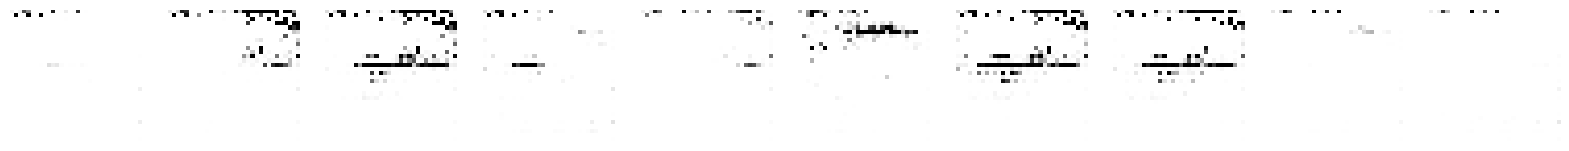

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - c_gp: 0.0075 - c_loss: -0.7202 - c_wass_loss: -0.7953 - g_loss: -12.2023
Epoch 581/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - c_gp: 0.0067 - c_loss: -0.9739 - c_wass_loss: -1.0408 - g_loss: -11.4576
Epoch 582/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0061 - c_loss: -1.0434 - c_wass_loss: -1.1049 - g_loss: -11.0771
Epoch 583/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0058 - c_loss: -0.9716 - c_wass_loss: -1.0294 - g_loss: -10.4510
Epoch 584/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0058 - c_loss: -0.6259 - c_wass_loss: -0.6841 - g_loss: -8.7921
Epoch 585/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - c_gp: 0.0088 - c_loss: -0.4438 - c_wass_loss: -0.5317 - g_loss: -6.8297
Saved to ./output/generated_img_584.png


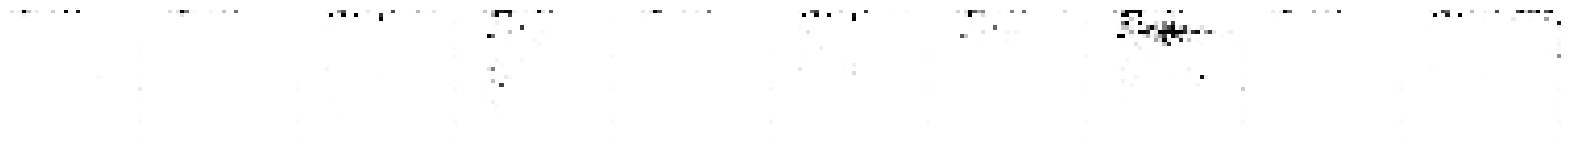

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 794ms/step - c_gp: 0.0088 - c_loss: -0.3526 - c_wass_loss: -0.4410 - g_loss: -6.4736
Epoch 586/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - c_gp: 0.0065 - c_loss: -0.5217 - c_wass_loss: -0.5862 - g_loss: -6.8909
Epoch 587/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - c_gp: 0.0079 - c_loss: -0.1321 - c_wass_loss: -0.2109 - g_loss: -11.2058
Epoch 588/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - c_gp: 0.0069 - c_loss: -0.3871 - c_wass_loss: -0.4559 - g_loss: -13.4787
Epoch 589/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - c_gp: 0.0060 - c_loss: -1.0975 - c_wass_loss: -1.1578 - g_loss: -14.0895
Epoch 590/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - c_gp: 0.0043 - c_loss: -0.2343 - c_wass_loss: -0.2769 - g_loss: -13.1409
Saved to ./output/generated_img_589.png


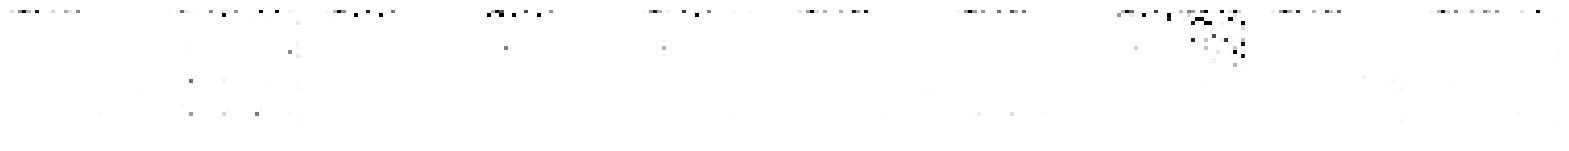

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 816ms/step - c_gp: 0.0044 - c_loss: -0.2886 - c_wass_loss: -0.3325 - g_loss: -12.9772
Epoch 591/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - c_gp: 0.0045 - c_loss: -0.8208 - c_wass_loss: -0.8658 - g_loss: -10.3366
Epoch 592/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0069 - c_loss: -0.4693 - c_wass_loss: -0.5383 - g_loss: -8.1101
Epoch 593/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - c_gp: 0.0054 - c_loss: -0.2156 - c_wass_loss: -0.2695 - g_loss: -5.4838
Epoch 594/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0073 - c_loss: -0.4308 - c_wass_loss: -0.5042 - g_loss: -4.9718
Epoch 595/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - c_gp: 0.0063 - c_loss: -0.6100 - c_wass_loss: -0.6727 - g_loss: -5.6908
Saved to ./output/generated_img_594.png


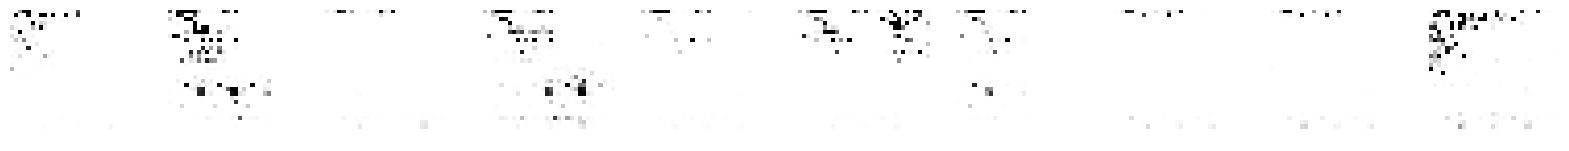

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step - c_gp: 0.0063 - c_loss: -0.6590 - c_wass_loss: -0.7217 - g_loss: -5.9438
Epoch 596/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0081 - c_loss: -0.1990 - c_wass_loss: -0.2798 - g_loss: -8.6025
Epoch 597/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0053 - c_loss: -0.1976 - c_wass_loss: -0.2502 - g_loss: -12.7026
Epoch 598/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0059 - c_loss: -1.0158 - c_wass_loss: -1.0753 - g_loss: -15.3383
Epoch 599/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - c_gp: 0.0056 - c_loss: -1.0906 - c_wass_loss: -1.1464 - g_loss: -16.1591
Epoch 600/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - c_gp: 0.0046 - c_loss: -0.7804 - c_wass_loss: -0.8266 - g_loss: -15.5984
Saved to ./output/generated_img_599.png


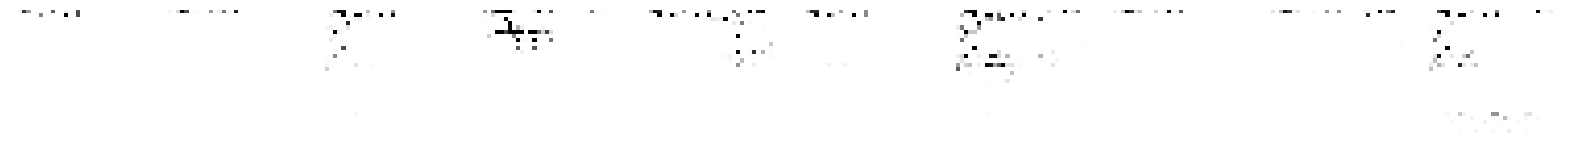

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 742ms/step - c_gp: 0.0045 - c_loss: -0.7716 - c_wass_loss: -0.8168 - g_loss: -15.6065
Epoch 601/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0033 - c_loss: -0.2647 - c_wass_loss: -0.2981 - g_loss: -14.0871
Epoch 602/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0036 - c_loss: -0.2584 - c_wass_loss: -0.2945 - g_loss: -12.6894
Epoch 603/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - c_gp: 0.0046 - c_loss: -0.4578 - c_wass_loss: -0.5040 - g_loss: -11.0082
Epoch 604/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - c_gp: 0.0051 - c_loss: -0.3513 - c_wass_loss: -0.4024 - g_loss: -10.0474
Epoch 605/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - c_gp: 0.0057 - c_loss: -0.6100 - c_wass_loss: -0.6666 - g_loss: -9.7973
Saved to ./output/generated_img_604.png


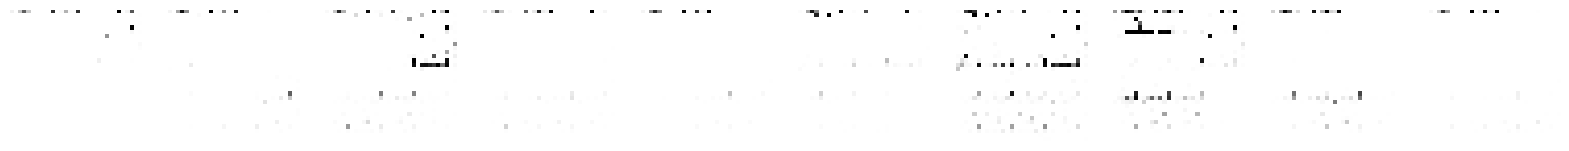

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 740ms/step - c_gp: 0.0055 - c_loss: -0.6315 - c_wass_loss: -0.6863 - g_loss: -9.6228
Epoch 606/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 877ms/step - c_gp: 0.0062 - c_loss: -0.7506 - c_wass_loss: -0.8127 - g_loss: -9.4498
Epoch 607/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - c_gp: 0.0071 - c_loss: -0.9059 - c_wass_loss: -0.9772 - g_loss: -9.2728
Epoch 608/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0076 - c_loss: -0.9554 - c_wass_loss: -1.0310 - g_loss: -8.4746
Epoch 609/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0063 - c_loss: -0.4300 - c_wass_loss: -0.4932 - g_loss: -8.2901
Epoch 610/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - c_gp: 0.0053 - c_loss: -0.5012 - c_wass_loss: -0.5547 - g_loss: -8.7739
Saved to ./output/generated_img_609.png


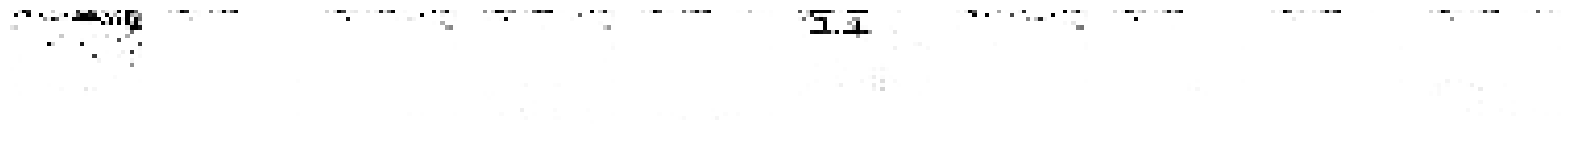

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 881ms/step - c_gp: 0.0054 - c_loss: -0.4173 - c_wass_loss: -0.4710 - g_loss: -8.9623
Epoch 611/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - c_gp: 0.0048 - c_loss: -0.3749 - c_wass_loss: -0.4225 - g_loss: -9.8686
Epoch 612/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - c_gp: 0.0041 - c_loss: -0.7933 - c_wass_loss: -0.8343 - g_loss: -9.8988
Epoch 613/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - c_gp: 0.0040 - c_loss: -0.7439 - c_wass_loss: -0.7834 - g_loss: -9.6410
Epoch 614/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - c_gp: 0.0048 - c_loss: -0.4410 - c_wass_loss: -0.4894 - g_loss: -9.8366
Epoch 615/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - c_gp: 0.0046 - c_loss: -0.3895 - c_wass_loss: -0.4356 - g_loss: -9.2001
Saved to ./output/generated_img_614.png


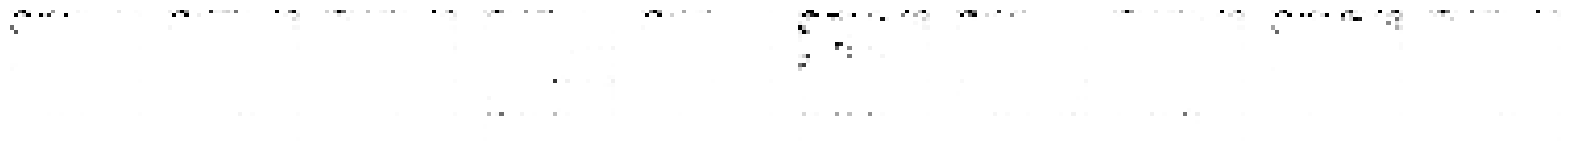

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 741ms/step - c_gp: 0.0048 - c_loss: -0.3914 - c_wass_loss: -0.4392 - g_loss: -9.0273
Epoch 616/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0049 - c_loss: -1.0889 - c_wass_loss: -1.1375 - g_loss: -8.5560
Epoch 617/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - c_gp: 0.0055 - c_loss: -0.0807 - c_wass_loss: -0.1353 - g_loss: -8.5849
Epoch 618/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - c_gp: 0.0049 - c_loss: -0.9661 - c_wass_loss: -1.0156 - g_loss: -8.4369
Epoch 619/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0072 - c_loss: -0.7479 - c_wass_loss: -0.8198 - g_loss: -9.1270
Epoch 620/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - c_gp: 0.0067 - c_loss: -0.4597 - c_wass_loss: -0.5266 - g_loss: -9.2930
Saved to ./output/generated_img_619.png


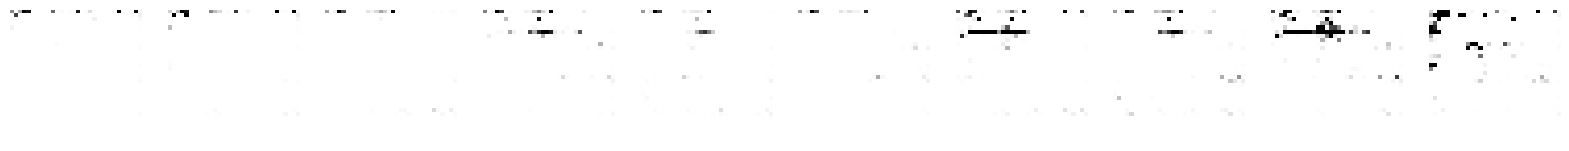

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 773ms/step - c_gp: 0.0063 - c_loss: -0.4345 - c_wass_loss: -0.4977 - g_loss: -9.3798
Epoch 621/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.0074 - c_loss: -0.9498 - c_wass_loss: -1.0242 - g_loss: -9.0623
Epoch 622/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0082 - c_loss: -0.8091 - c_wass_loss: -0.8907 - g_loss: -8.6187
Epoch 623/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - c_gp: 0.0074 - c_loss: -0.2995 - c_wass_loss: -0.3739 - g_loss: -7.4473
Epoch 624/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0074 - c_loss: -0.6632 - c_wass_loss: -0.7377 - g_loss: -7.1584
Epoch 625/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - c_gp: 0.0063 - c_loss: -0.6856 - c_wass_loss: -0.7483 - g_loss: -7.8874
Saved to ./output/generated_img_624.png


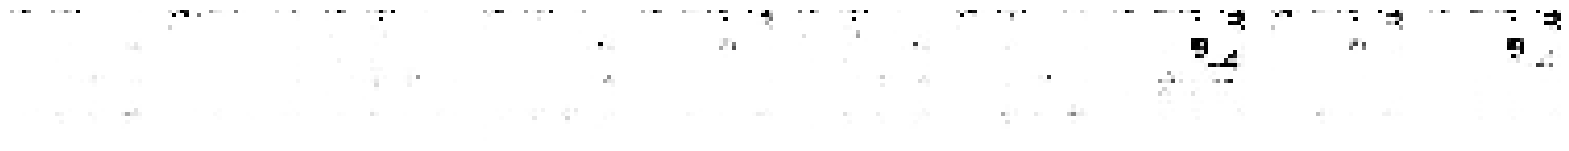

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step - c_gp: 0.0059 - c_loss: -0.5467 - c_wass_loss: -0.6057 - g_loss: -7.8828
Epoch 626/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - c_gp: 0.0056 - c_loss: -0.1972 - c_wass_loss: -0.2535 - g_loss: -8.8174
Epoch 627/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - c_gp: 0.0050 - c_loss: -0.7839 - c_wass_loss: -0.8334 - g_loss: -9.9432 
Epoch 628/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0045 - c_loss: 0.1036 - c_wass_loss: 0.0583 - g_loss: -10.1307  
Epoch 629/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - c_gp: 0.0045 - c_loss: -0.6357 - c_wass_loss: -0.6803 - g_loss: -10.7563
Epoch 630/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - c_gp: 0.0047 - c_loss: -0.4889 - c_wass_loss: -0.5362 - g_loss: -11.9113
Saved to ./output/generated_img_629.png


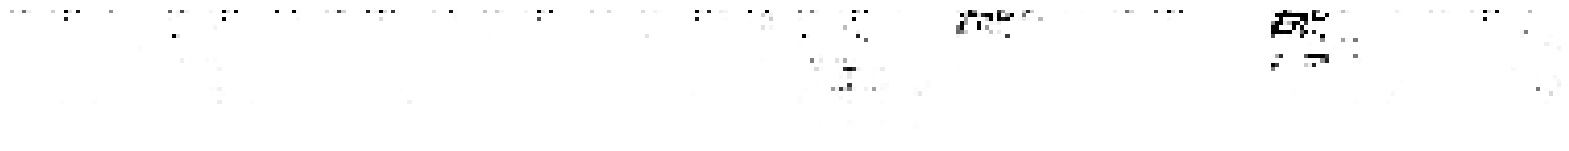

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step - c_gp: 0.0047 - c_loss: -0.4514 - c_wass_loss: -0.4989 - g_loss: -12.0117
Epoch 631/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.0046 - c_loss: -0.4486 - c_wass_loss: -0.4950 - g_loss: -11.9950
Epoch 632/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0043 - c_loss: -0.2792 - c_wass_loss: -0.3222 - g_loss: -11.4192
Epoch 633/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0044 - c_loss: -0.2603 - c_wass_loss: -0.3046 - g_loss: -10.8488
Epoch 634/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - c_gp: 0.0036 - c_loss: -0.0115 - c_wass_loss: -0.0473 - g_loss: -10.4324
Epoch 635/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - c_gp: 0.0037 - c_loss: -0.3397 - c_wass_loss: -0.3772 - g_loss: -10.2758
Saved to ./output/generated_img_634.png


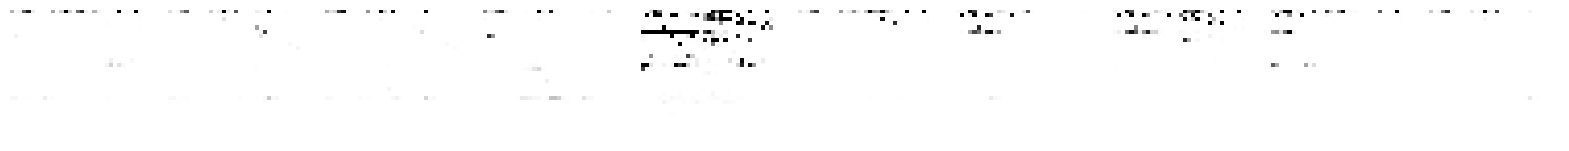

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step - c_gp: 0.0036 - c_loss: -0.3199 - c_wass_loss: -0.3558 - g_loss: -10.3325
Epoch 636/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0045 - c_loss: -0.3042 - c_wass_loss: -0.3495 - g_loss: -11.9096
Epoch 637/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0051 - c_loss: -0.4557 - c_wass_loss: -0.5067 - g_loss: -12.0579
Epoch 638/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0049 - c_loss: -0.3058 - c_wass_loss: -0.3547 - g_loss: -11.2893
Epoch 639/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0046 - c_loss: -0.3303 - c_wass_loss: -0.3760 - g_loss: -10.7136
Epoch 640/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0037 - c_loss: -0.3462 - c_wass_loss: -0.3831 - g_loss: -9.5664
Saved to ./output/generated_img_639.png


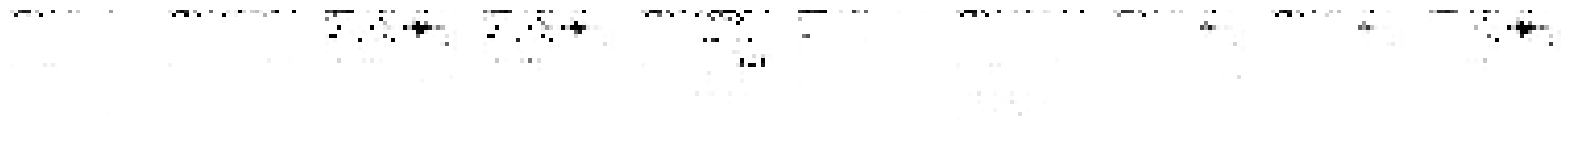

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step - c_gp: 0.0039 - c_loss: -0.4529 - c_wass_loss: -0.4917 - g_loss: -9.1824
Epoch 641/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step - c_gp: 0.0051 - c_loss: -0.6575 - c_wass_loss: -0.7089 - g_loss: -8.2500
Epoch 642/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - c_gp: 0.0048 - c_loss: -0.7109 - c_wass_loss: -0.7585 - g_loss: -8.0148
Epoch 643/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0044 - c_loss: -0.3536 - c_wass_loss: -0.3974 - g_loss: -7.9328
Epoch 644/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - c_gp: 0.0051 - c_loss: -0.6294 - c_wass_loss: -0.6800 - g_loss: -7.8780
Epoch 645/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - c_gp: 0.0058 - c_loss: -0.7671 - c_wass_loss: -0.8254 - g_loss: -8.5764
Saved to ./output/generated_img_644.png


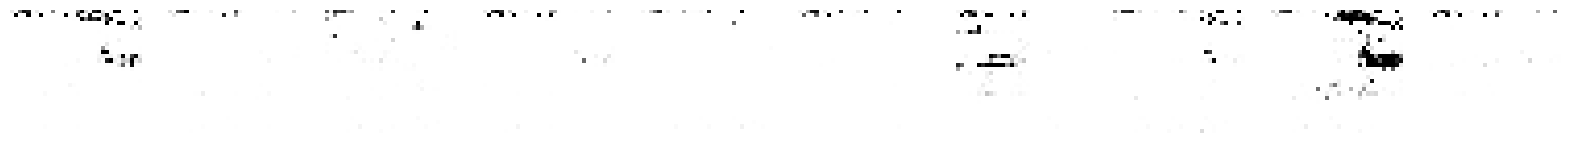

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step - c_gp: 0.0063 - c_loss: -0.6966 - c_wass_loss: -0.7595 - g_loss: -8.6536
Epoch 646/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.0042 - c_loss: -0.3955 - c_wass_loss: -0.4380 - g_loss: -9.9530
Epoch 647/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - c_gp: 0.0047 - c_loss: -0.7482 - c_wass_loss: -0.7947 - g_loss: -10.4061
Epoch 648/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0042 - c_loss: -0.6275 - c_wass_loss: -0.6699 - g_loss: -11.0866
Epoch 649/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0045 - c_loss: -0.4445 - c_wass_loss: -0.4899 - g_loss: -11.5344
Epoch 650/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - c_gp: 0.0050 - c_loss: -0.5017 - c_wass_loss: -0.5518 - g_loss: -11.8731
Saved to ./output/generated_img_649.png


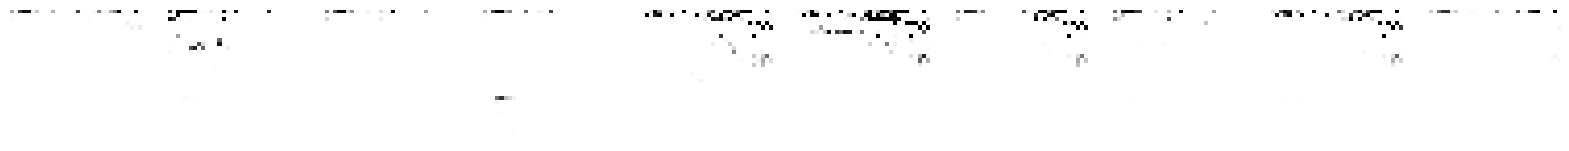

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step - c_gp: 0.0051 - c_loss: -0.4295 - c_wass_loss: -0.4809 - g_loss: -12.1221
Epoch 651/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - c_gp: 0.0041 - c_loss: -0.4383 - c_wass_loss: -0.4796 - g_loss: -11.1940
Epoch 652/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0038 - c_loss: -0.2277 - c_wass_loss: -0.2653 - g_loss: -8.4325
Epoch 653/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - c_gp: 0.0045 - c_loss: 0.0010 - c_wass_loss: -0.0437 - g_loss: -5.9678 
Epoch 654/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - c_gp: 0.0074 - c_loss: -0.4161 - c_wass_loss: -0.4897 - g_loss: -5.7212
Epoch 655/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - c_gp: 0.0062 - c_loss: -0.3065 - c_wass_loss: -0.3681 - g_loss: -6.1816
Saved to ./output/generated_img_654.png


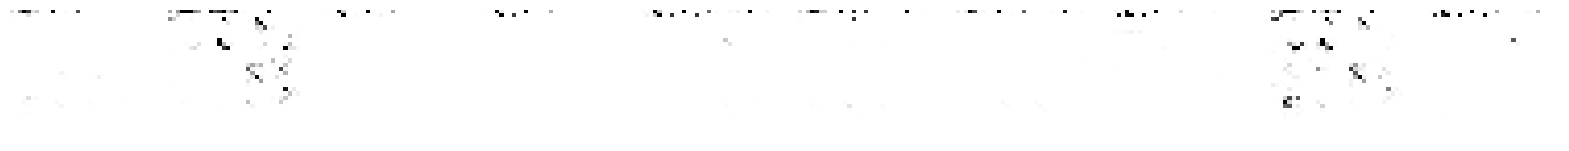

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 784ms/step - c_gp: 0.0069 - c_loss: -0.3532 - c_wass_loss: -0.4217 - g_loss: -6.4646
Epoch 656/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 595ms/step - c_gp: 0.0072 - c_loss: -0.6729 - c_wass_loss: -0.7448 - g_loss: -8.3025
Epoch 657/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - c_gp: 0.0061 - c_loss: -0.7300 - c_wass_loss: -0.7913 - g_loss: -9.7953
Epoch 658/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step - c_gp: 0.0052 - c_loss: -0.6405 - c_wass_loss: -0.6920 - g_loss: -11.1784
Epoch 659/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step - c_gp: 0.0044 - c_loss: -0.3451 - c_wass_loss: -0.3887 - g_loss: -11.2340
Epoch 660/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - c_gp: 0.0045 - c_loss: -0.5370 - c_wass_loss: -0.5824 - g_loss: -11.3539
Saved to ./output/generated_img_659.png


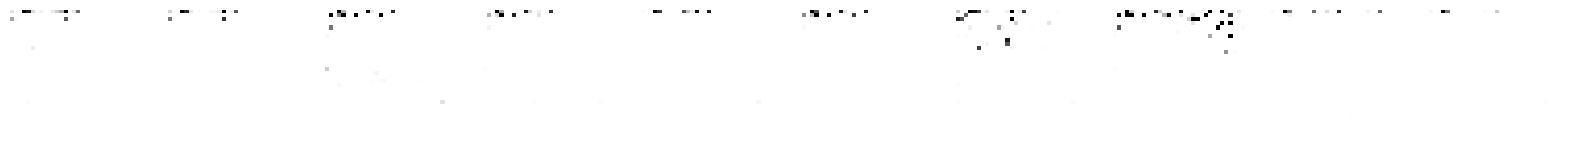

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 805ms/step - c_gp: 0.0048 - c_loss: -0.5338 - c_wass_loss: -0.5814 - g_loss: -11.3798
Epoch 661/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step - c_gp: 0.0053 - c_loss: -0.5589 - c_wass_loss: -0.6118 - g_loss: -9.8477 
Epoch 662/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - c_gp: 0.0052 - c_loss: -0.2724 - c_wass_loss: -0.3246 - g_loss: -9.4456
Epoch 663/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 595ms/step - c_gp: 0.0075 - c_loss: -0.6335 - c_wass_loss: -0.7082 - g_loss: -9.6049
Epoch 664/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0076 - c_loss: -0.4768 - c_wass_loss: -0.5527 - g_loss: -10.9551
Epoch 665/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - c_gp: 0.0061 - c_loss: -0.6944 - c_wass_loss: -0.7555 - g_loss: -11.0740
Saved to ./output/generated_img_664.png


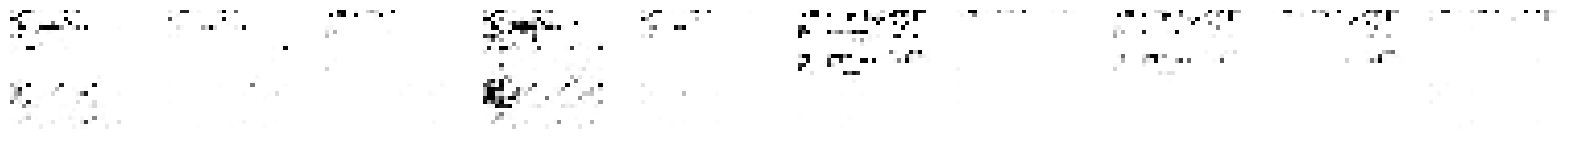

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step - c_gp: 0.0057 - c_loss: -0.6820 - c_wass_loss: -0.7387 - g_loss: -11.1160
Epoch 666/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0054 - c_loss: -0.7573 - c_wass_loss: -0.8116 - g_loss: -10.8607
Epoch 667/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - c_gp: 0.0057 - c_loss: -0.6796 - c_wass_loss: -0.7369 - g_loss: -10.6574
Epoch 668/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - c_gp: 0.0067 - c_loss: -0.4131 - c_wass_loss: -0.4806 - g_loss: -11.3535
Epoch 669/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0042 - c_loss: -0.4295 - c_wass_loss: -0.4712 - g_loss: -11.4306
Epoch 670/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - c_gp: 0.0048 - c_loss: -0.6606 - c_wass_loss: -0.7089 - g_loss: -11.3445
Saved to ./output/generated_img_669.png


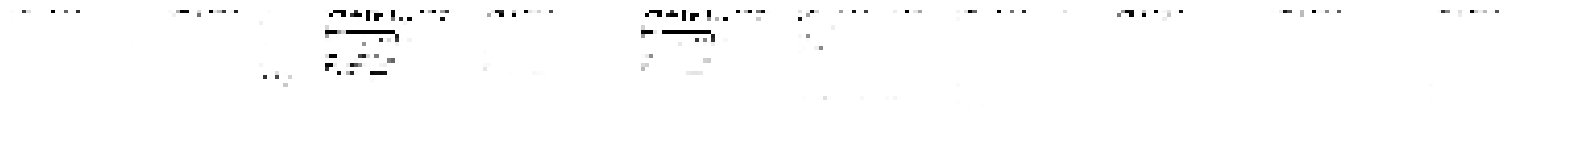

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 741ms/step - c_gp: 0.0047 - c_loss: -0.6470 - c_wass_loss: -0.6939 - g_loss: -11.4865
Epoch 671/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 698ms/step - c_gp: 0.0056 - c_loss: -0.6342 - c_wass_loss: -0.6901 - g_loss: -12.3921
Epoch 672/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 588ms/step - c_gp: 0.0047 - c_loss: -0.5057 - c_wass_loss: -0.5528 - g_loss: -12.0365
Epoch 673/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 670ms/step - c_gp: 0.0049 - c_loss: -0.2996 - c_wass_loss: -0.3489 - g_loss: -11.3333
Epoch 674/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0048 - c_loss: -0.7109 - c_wass_loss: -0.7590 - g_loss: -10.0009
Epoch 675/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - c_gp: 0.0061 - c_loss: -0.5780 - c_wass_loss: -0.6392 - g_loss: -9.3119
Saved to ./output/generated_img_674.png


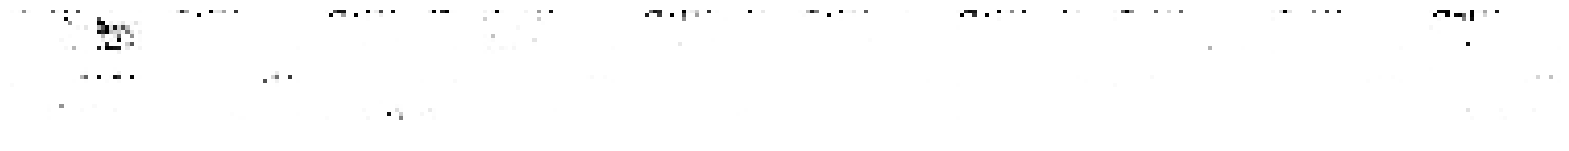

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 791ms/step - c_gp: 0.0063 - c_loss: -0.6684 - c_wass_loss: -0.7316 - g_loss: -8.9052
Epoch 676/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - c_gp: 0.0061 - c_loss: -0.2907 - c_wass_loss: -0.3515 - g_loss: -7.1261
Epoch 677/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - c_gp: 0.0059 - c_loss: -0.7871 - c_wass_loss: -0.8466 - g_loss: -7.9194
Epoch 678/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - c_gp: 0.0060 - c_loss: -0.3746 - c_wass_loss: -0.4343 - g_loss: -10.0244
Epoch 679/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0043 - c_loss: -0.2198 - c_wass_loss: -0.2631 - g_loss: -10.9194
Epoch 680/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_gp: 0.0043 - c_loss: -0.5822 - c_wass_loss: -0.6249 - g_loss: -11.3346
Saved to ./output/generated_img_679.png


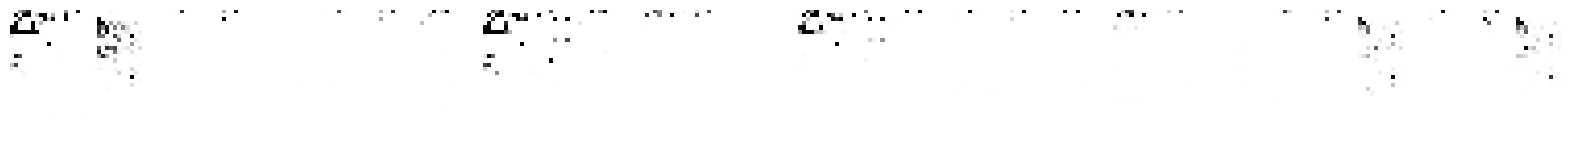

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step - c_gp: 0.0043 - c_loss: -0.4943 - c_wass_loss: -0.5375 - g_loss: -11.1729
Epoch 681/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0040 - c_loss: -0.5824 - c_wass_loss: -0.6220 - g_loss: -10.3372
Epoch 682/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0047 - c_loss: -0.8805 - c_wass_loss: -0.9272 - g_loss: -11.0538
Epoch 683/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - c_gp: 0.0053 - c_loss: -0.5287 - c_wass_loss: -0.5820 - g_loss: -10.9660
Epoch 684/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step - c_gp: 0.0053 - c_loss: -0.9083 - c_wass_loss: -0.9612 - g_loss: -10.6005
Epoch 685/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - c_gp: 0.0052 - c_loss: -0.5794 - c_wass_loss: -0.6318 - g_loss: -9.8226
Saved to ./output/generated_img_684.png


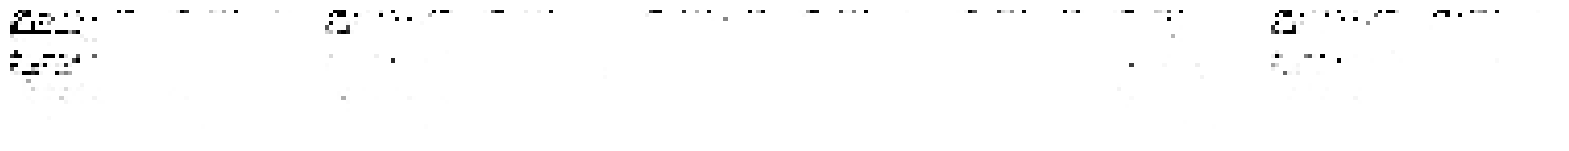

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 715ms/step - c_gp: 0.0053 - c_loss: -0.6243 - c_wass_loss: -0.6771 - g_loss: -9.6180
Epoch 686/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - c_gp: 0.0061 - c_loss: -0.6523 - c_wass_loss: -0.7132 - g_loss: -7.7663
Epoch 687/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - c_gp: 0.0079 - c_loss: -0.6497 - c_wass_loss: -0.7289 - g_loss: -6.2378
Epoch 688/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - c_gp: 0.0089 - c_loss: -0.6280 - c_wass_loss: -0.7171 - g_loss: -6.6097
Epoch 689/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0087 - c_loss: -0.8214 - c_wass_loss: -0.9081 - g_loss: -7.3580
Epoch 690/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - c_gp: 0.0054 - c_loss: -0.7348 - c_wass_loss: -0.7886 - g_loss: -7.5577
Saved to ./output/generated_img_689.png


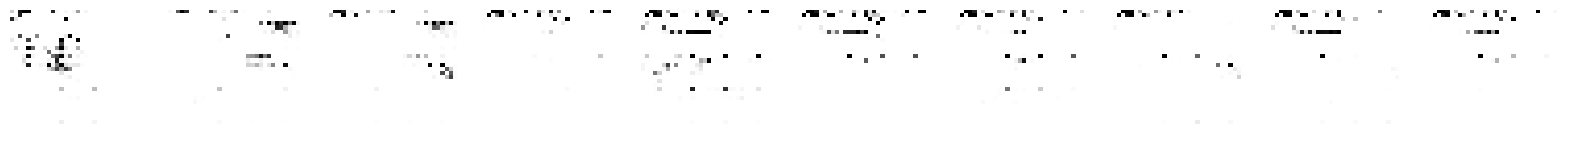

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 852ms/step - c_gp: 0.0049 - c_loss: -0.7195 - c_wass_loss: -0.7690 - g_loss: -7.6093
Epoch 691/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - c_gp: 0.0052 - c_loss: -0.7996 - c_wass_loss: -0.8518 - g_loss: -8.1178
Epoch 692/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - c_gp: 0.0046 - c_loss: -0.4163 - c_wass_loss: -0.4624 - g_loss: -8.1260
Epoch 693/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step - c_gp: 0.0048 - c_loss: -0.3464 - c_wass_loss: -0.3948 - g_loss: -7.2234
Epoch 694/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - c_gp: 0.0055 - c_loss: -0.6684 - c_wass_loss: -0.7230 - g_loss: -6.2305
Epoch 695/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - c_gp: 0.0059 - c_loss: -0.5399 - c_wass_loss: -0.5993 - g_loss: -6.2952
Saved to ./output/generated_img_694.png


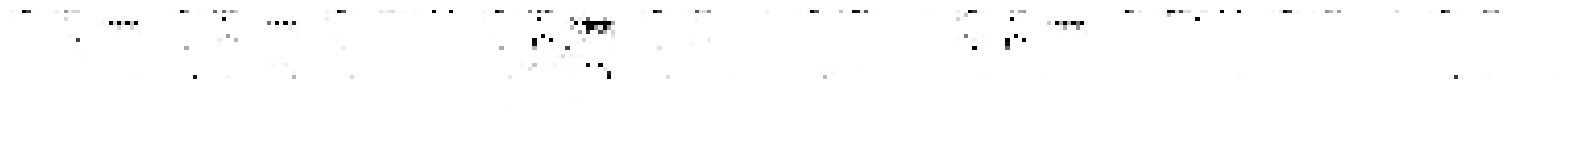

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 739ms/step - c_gp: 0.0054 - c_loss: -0.5750 - c_wass_loss: -0.6294 - g_loss: -6.5067
Epoch 696/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - c_gp: 0.0050 - c_loss: -0.6905 - c_wass_loss: -0.7404 - g_loss: -7.4243
Epoch 697/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - c_gp: 0.0061 - c_loss: -0.5433 - c_wass_loss: -0.6046 - g_loss: -7.5914
Epoch 698/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step - c_gp: 0.0043 - c_loss: -0.2626 - c_wass_loss: -0.3054 - g_loss: -8.3600
Epoch 699/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - c_gp: 0.0036 - c_loss: -0.2811 - c_wass_loss: -0.3170 - g_loss: -9.8090
Epoch 700/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - c_gp: 0.0047 - c_loss: -0.6731 - c_wass_loss: -0.7201 - g_loss: -10.6619
Saved to ./output/generated_img_699.png


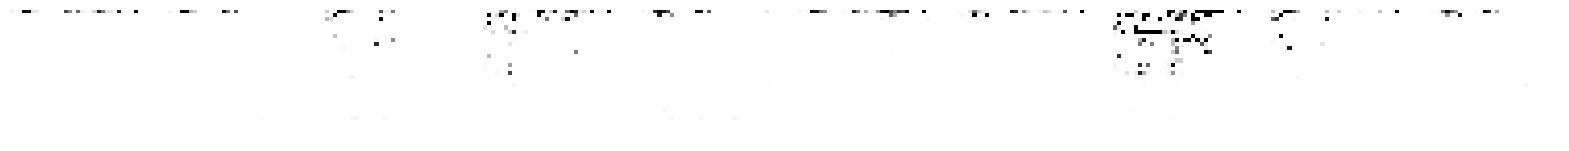

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 761ms/step - c_gp: 0.0047 - c_loss: -0.9153 - c_wass_loss: -0.9628 - g_loss: -10.7403
Epoch 701/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - c_gp: 0.0035 - c_loss: -0.7462 - c_wass_loss: -0.7807 - g_loss: -11.5313
Epoch 702/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step - c_gp: 0.0038 - c_loss: -0.7010 - c_wass_loss: -0.7392 - g_loss: -10.1803
Epoch 703/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step - c_gp: 0.0044 - c_loss: -0.4984 - c_wass_loss: -0.5423 - g_loss: -7.8222
Epoch 704/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step - c_gp: 0.0048 - c_loss: -0.9215 - c_wass_loss: -0.9696 - g_loss: -6.0538
Epoch 705/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_gp: 0.0053 - c_loss: -0.5662 - c_wass_loss: -0.6193 - g_loss: -5.7948
Saved to ./output/generated_img_704.png


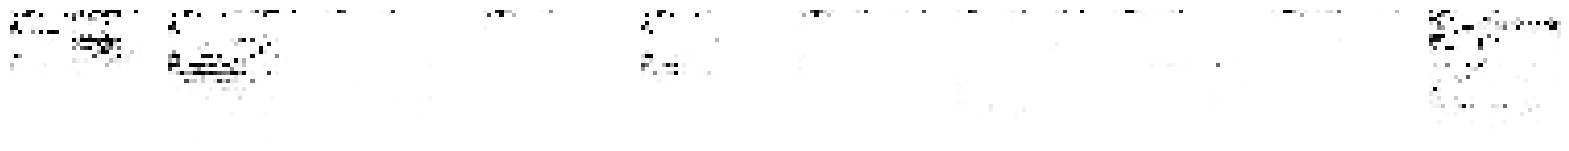

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step - c_gp: 0.0053 - c_loss: -0.7973 - c_wass_loss: -0.8502 - g_loss: -6.0142
Epoch 706/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 553ms/step - c_gp: 0.0062 - c_loss: -0.3326 - c_wass_loss: -0.3944 - g_loss: -7.1522
Epoch 707/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - c_gp: 0.0055 - c_loss: -0.3267 - c_wass_loss: -0.3818 - g_loss: -8.7367
Epoch 708/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - c_gp: 0.0062 - c_loss: -0.4729 - c_wass_loss: -0.5352 - g_loss: -11.4428
Epoch 709/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0050 - c_loss: -1.0271 - c_wass_loss: -1.0772 - g_loss: -12.0256
Epoch 710/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - c_gp: 0.0049 - c_loss: -0.7095 - c_wass_loss: -0.7581 - g_loss: -11.1871
Saved to ./output/generated_img_709.png


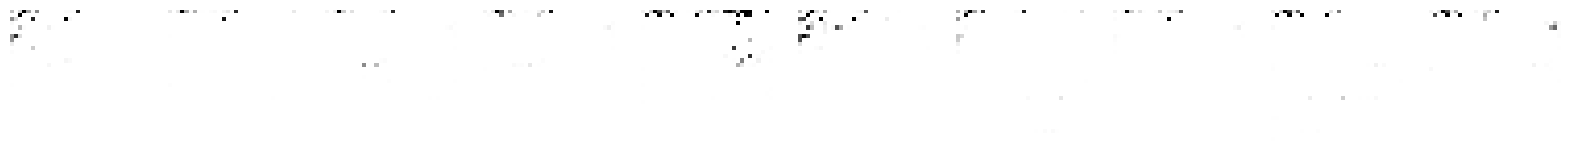

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step - c_gp: 0.0047 - c_loss: -0.5739 - c_wass_loss: -0.6206 - g_loss: -10.9313
Epoch 711/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - c_gp: 0.0036 - c_loss: -0.5624 - c_wass_loss: -0.5988 - g_loss: -8.2442
Epoch 712/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - c_gp: 0.0043 - c_loss: -0.5458 - c_wass_loss: -0.5891 - g_loss: -6.8715
Epoch 713/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0045 - c_loss: -0.7439 - c_wass_loss: -0.7887 - g_loss: -7.2065
Epoch 714/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - c_gp: 0.0053 - c_loss: -0.0701 - c_wass_loss: -0.1234 - g_loss: -7.3166
Epoch 715/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - c_gp: 0.0044 - c_loss: -0.5062 - c_wass_loss: -0.5505 - g_loss: -7.2729
Saved to ./output/generated_img_714.png


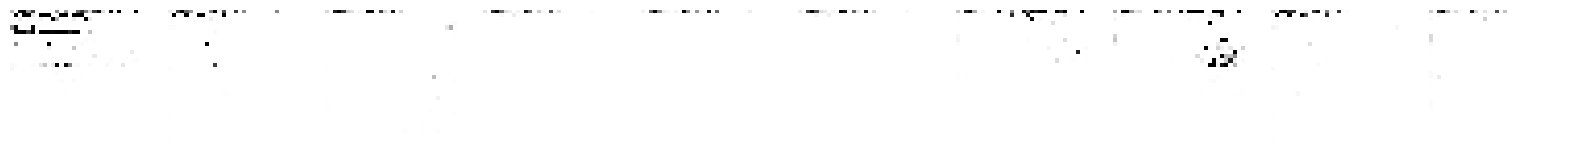

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step - c_gp: 0.0047 - c_loss: -0.5404 - c_wass_loss: -0.5876 - g_loss: -7.4592
Epoch 716/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 784ms/step - c_gp: 0.0055 - c_loss: -0.6866 - c_wass_loss: -0.7416 - g_loss: -8.4436
Epoch 717/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - c_gp: 0.0050 - c_loss: -0.3816 - c_wass_loss: -0.4317 - g_loss: -7.8948
Epoch 718/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - c_gp: 0.0038 - c_loss: -0.3062 - c_wass_loss: -0.3440 - g_loss: -7.6415
Epoch 719/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 572ms/step - c_gp: 0.0048 - c_loss: -0.2801 - c_wass_loss: -0.3283 - g_loss: -7.0007
Epoch 720/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - c_gp: 0.0045 - c_loss: -0.4574 - c_wass_loss: -0.5025 - g_loss: -6.8873
Saved to ./output/generated_img_719.png


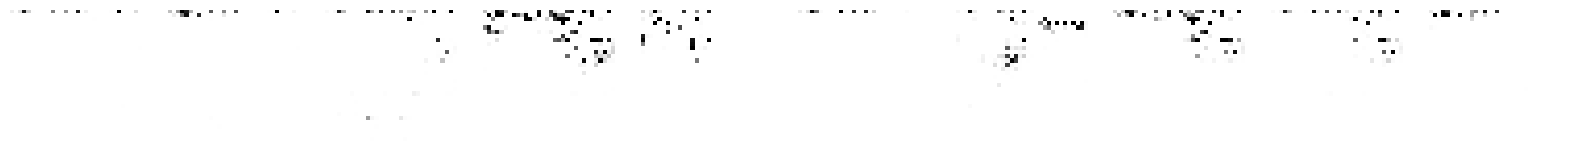

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 799ms/step - c_gp: 0.0042 - c_loss: -0.5704 - c_wass_loss: -0.6120 - g_loss: -7.0555
Epoch 721/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - c_gp: 0.0043 - c_loss: -0.1542 - c_wass_loss: -0.1969 - g_loss: -7.9062
Epoch 722/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step - c_gp: 0.0036 - c_loss: -0.5401 - c_wass_loss: -0.5762 - g_loss: -8.9226
Epoch 723/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0048 - c_loss: -0.4313 - c_wass_loss: -0.4796 - g_loss: -11.9640
Epoch 724/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - c_gp: 0.0045 - c_loss: -0.6835 - c_wass_loss: -0.7283 - g_loss: -11.8308
Epoch 725/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - c_gp: 0.0046 - c_loss: -0.3818 - c_wass_loss: -0.4279 - g_loss: -11.5027
Saved to ./output/generated_img_724.png


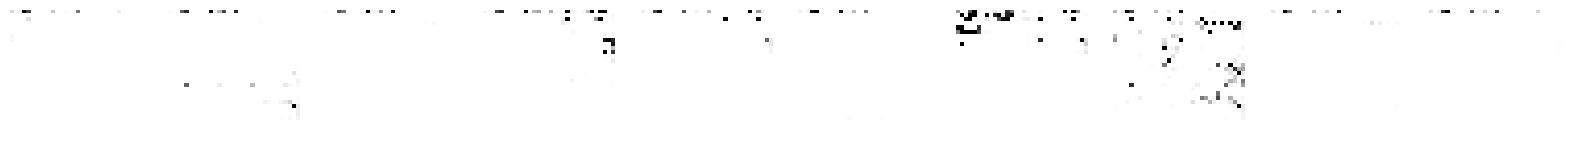

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 783ms/step - c_gp: 0.0046 - c_loss: -0.4153 - c_wass_loss: -0.4617 - g_loss: -11.3280
Epoch 726/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0033 - c_loss: -0.1783 - c_wass_loss: -0.2115 - g_loss: -9.7922
Epoch 727/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0031 - c_loss: -0.0969 - c_wass_loss: -0.1284 - g_loss: -9.1596
Epoch 728/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - c_gp: 0.0044 - c_loss: -0.4488 - c_wass_loss: -0.4932 - g_loss: -7.8047
Epoch 729/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - c_gp: 0.0060 - c_loss: -0.4389 - c_wass_loss: -0.4985 - g_loss: -6.4158
Epoch 730/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - c_gp: 0.0039 - c_loss: -0.6357 - c_wass_loss: -0.6745 - g_loss: -7.0794
Saved to ./output/generated_img_729.png


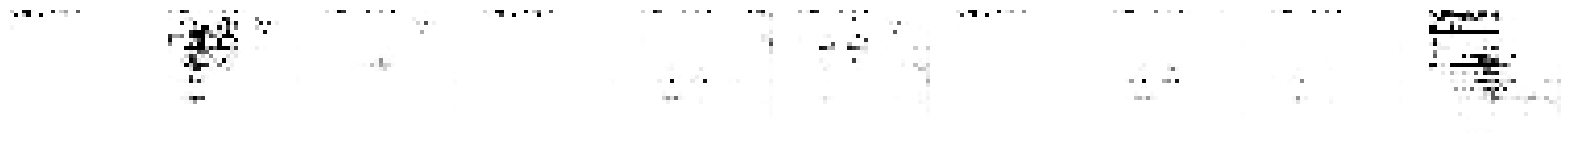

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 782ms/step - c_gp: 0.0034 - c_loss: -0.7283 - c_wass_loss: -0.7628 - g_loss: -7.4174
Epoch 731/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 516ms/step - c_gp: 0.0047 - c_loss: -0.2119 - c_wass_loss: -0.2587 - g_loss: -9.2527
Epoch 732/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0059 - c_loss: -0.5374 - c_wass_loss: -0.5963 - g_loss: -11.2546
Epoch 733/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 592ms/step - c_gp: 0.0031 - c_loss: -0.7120 - c_wass_loss: -0.7432 - g_loss: -12.2193
Epoch 734/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - c_gp: 0.0045 - c_loss: -0.2124 - c_wass_loss: -0.2576 - g_loss: -11.6119
Epoch 735/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - c_gp: 0.0035 - c_loss: -0.4315 - c_wass_loss: -0.4668 - g_loss: -10.8492
Saved to ./output/generated_img_734.png


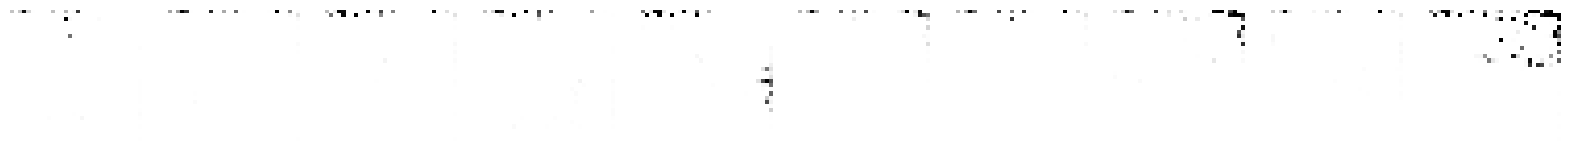

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 863ms/step - c_gp: 0.0033 - c_loss: -0.3391 - c_wass_loss: -0.3721 - g_loss: -10.7533
Epoch 736/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - c_gp: 0.0034 - c_loss: -0.4048 - c_wass_loss: -0.4387 - g_loss: -10.7188
Epoch 737/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - c_gp: 0.0036 - c_loss: -0.4382 - c_wass_loss: -0.4743 - g_loss: -10.0377
Epoch 738/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - c_gp: 0.0046 - c_loss: -0.0765 - c_wass_loss: -0.1228 - g_loss: -9.3654
Epoch 739/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - c_gp: 0.0052 - c_loss: -0.4984 - c_wass_loss: -0.5499 - g_loss: -10.3870
Epoch 740/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - c_gp: 0.0050 - c_loss: -0.5924 - c_wass_loss: -0.6428 - g_loss: -10.0337
Saved to ./output/generated_img_739.png


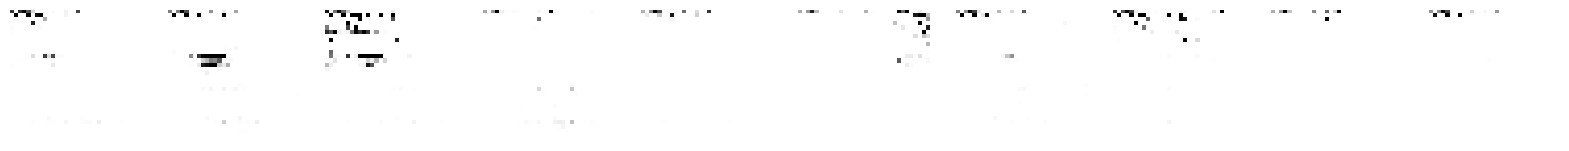

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 800ms/step - c_gp: 0.0055 - c_loss: -0.6962 - c_wass_loss: -0.7517 - g_loss: -10.1465
Epoch 741/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - c_gp: 0.0047 - c_loss: -0.7019 - c_wass_loss: -0.7487 - g_loss: -11.7262
Epoch 742/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - c_gp: 0.0049 - c_loss: -0.7614 - c_wass_loss: -0.8101 - g_loss: -11.0787
Epoch 743/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - c_gp: 0.0049 - c_loss: -0.7228 - c_wass_loss: -0.7717 - g_loss: -8.5798
Epoch 744/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - c_gp: 0.0037 - c_loss: -0.5684 - c_wass_loss: -0.6049 - g_loss: -7.0044
Epoch 745/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - c_gp: 0.0052 - c_loss: -0.7753 - c_wass_loss: -0.8268 - g_loss: -5.8935
Saved to ./output/generated_img_744.png


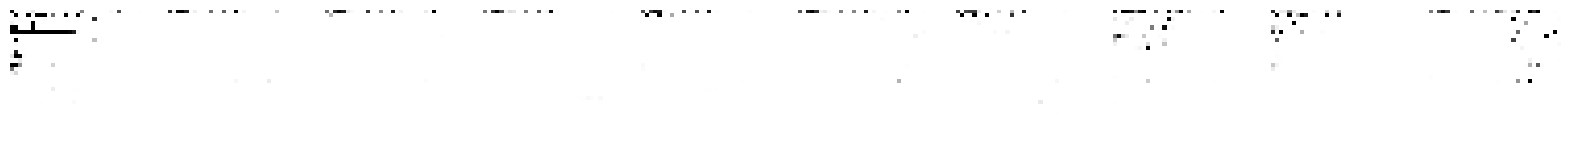

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step - c_gp: 0.0050 - c_loss: -0.8511 - c_wass_loss: -0.9007 - g_loss: -5.8661
Epoch 746/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0066 - c_loss: -0.6404 - c_wass_loss: -0.7065 - g_loss: -6.8480
Epoch 747/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0060 - c_loss: -0.4693 - c_wass_loss: -0.5295 - g_loss: -7.6107
Epoch 748/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - c_gp: 0.0057 - c_loss: -0.9860 - c_wass_loss: -1.0427 - g_loss: -7.7031
Epoch 749/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - c_gp: 0.0065 - c_loss: -0.6225 - c_wass_loss: -0.6871 - g_loss: -8.1656
Epoch 750/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - c_gp: 0.0052 - c_loss: -0.5258 - c_wass_loss: -0.5774 - g_loss: -9.1153
Saved to ./output/generated_img_749.png


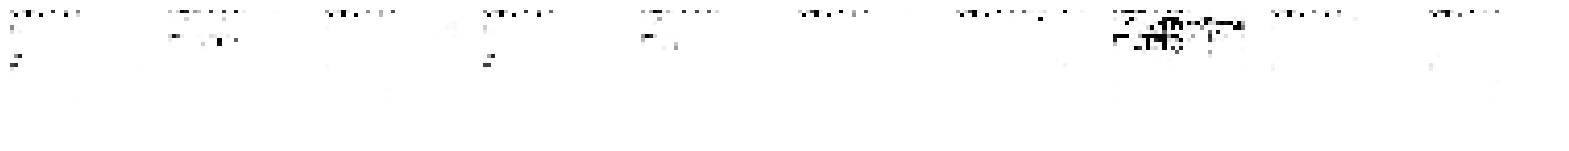

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step - c_gp: 0.0053 - c_loss: -0.4590 - c_wass_loss: -0.5120 - g_loss: -9.1321
Epoch 751/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - c_gp: 0.0045 - c_loss: -0.8083 - c_wass_loss: -0.8529 - g_loss: -8.6919
Epoch 752/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 598ms/step - c_gp: 0.0046 - c_loss: -0.1264 - c_wass_loss: -0.1722 - g_loss: -7.7122
Epoch 753/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - c_gp: 0.0044 - c_loss: -0.6026 - c_wass_loss: -0.6470 - g_loss: -7.2590
Epoch 754/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0043 - c_loss: -0.5677 - c_wass_loss: -0.6103 - g_loss: -7.6290
Epoch 755/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - c_gp: 0.0049 - c_loss: -0.2815 - c_wass_loss: -0.3302 - g_loss: -7.5263
Saved to ./output/generated_img_754.png


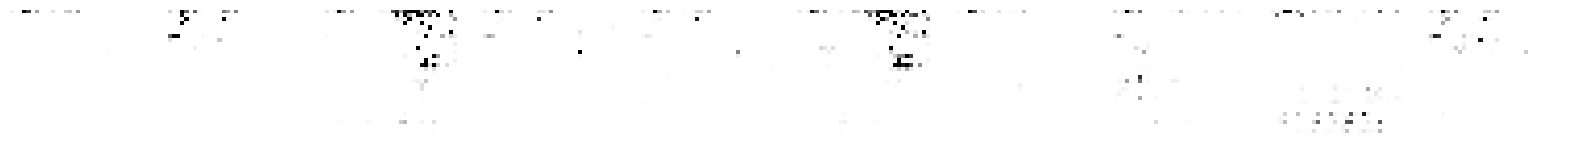

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 791ms/step - c_gp: 0.0045 - c_loss: -0.1703 - c_wass_loss: -0.2153 - g_loss: -7.4691
Epoch 756/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - c_gp: 0.0048 - c_loss: -0.4356 - c_wass_loss: -0.4832 - g_loss: -7.6548
Epoch 757/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - c_gp: 0.0053 - c_loss: -0.1810 - c_wass_loss: -0.2337 - g_loss: -9.1581
Epoch 758/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - c_gp: 0.0038 - c_loss: -0.6957 - c_wass_loss: -0.7341 - g_loss: -10.1178
Epoch 759/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - c_gp: 0.0038 - c_loss: -0.5180 - c_wass_loss: -0.5557 - g_loss: -10.7859
Epoch 760/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - c_gp: 0.0036 - c_loss: -0.3853 - c_wass_loss: -0.4213 - g_loss: -10.3158
Saved to ./output/generated_img_759.png


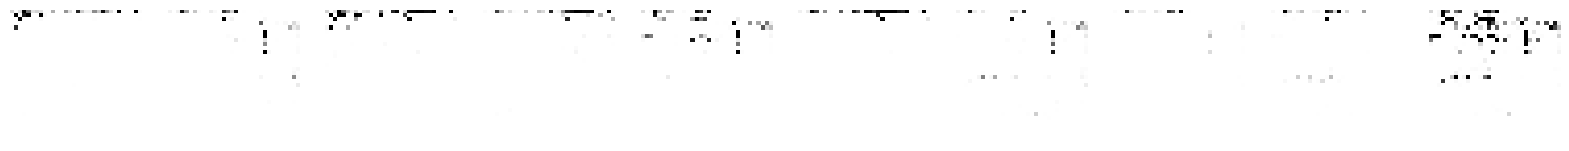

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 812ms/step - c_gp: 0.0040 - c_loss: -0.5288 - c_wass_loss: -0.5690 - g_loss: -10.3481
Epoch 761/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - c_gp: 0.0034 - c_loss: -0.6165 - c_wass_loss: -0.6504 - g_loss: -9.3519
Epoch 762/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - c_gp: 0.0030 - c_loss: -0.6226 - c_wass_loss: -0.6527 - g_loss: -9.6035
Epoch 763/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step - c_gp: 0.0034 - c_loss: -0.1457 - c_wass_loss: -0.1795 - g_loss: -10.2961
Epoch 764/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0037 - c_loss: -0.4884 - c_wass_loss: -0.5253 - g_loss: -10.5309
Epoch 765/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - c_gp: 0.0039 - c_loss: -0.1726 - c_wass_loss: -0.2115 - g_loss: -9.7521
Saved to ./output/generated_img_764.png


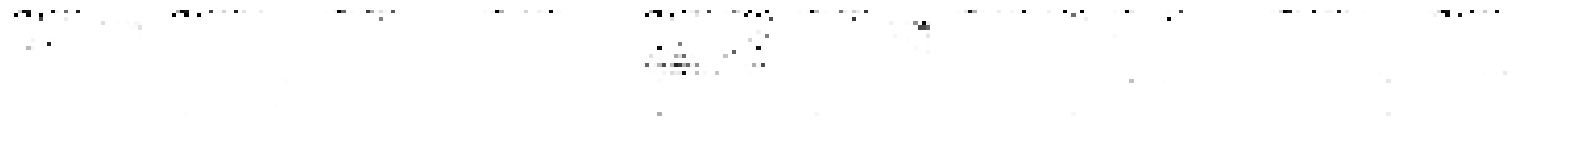

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 784ms/step - c_gp: 0.0043 - c_loss: -0.1361 - c_wass_loss: -0.1789 - g_loss: -9.5682
Epoch 766/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.0045 - c_loss: -0.5332 - c_wass_loss: -0.5779 - g_loss: -8.0810
Epoch 767/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - c_gp: 0.0053 - c_loss: -0.4805 - c_wass_loss: -0.5338 - g_loss: -8.8179
Epoch 768/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0047 - c_loss: -0.2658 - c_wass_loss: -0.3123 - g_loss: -9.7144
Epoch 769/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - c_gp: 0.0063 - c_loss: -0.4202 - c_wass_loss: -0.4832 - g_loss: -11.5221
Epoch 770/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_gp: 0.0043 - c_loss: -0.1970 - c_wass_loss: -0.2403 - g_loss: -12.3421
Saved to ./output/generated_img_769.png


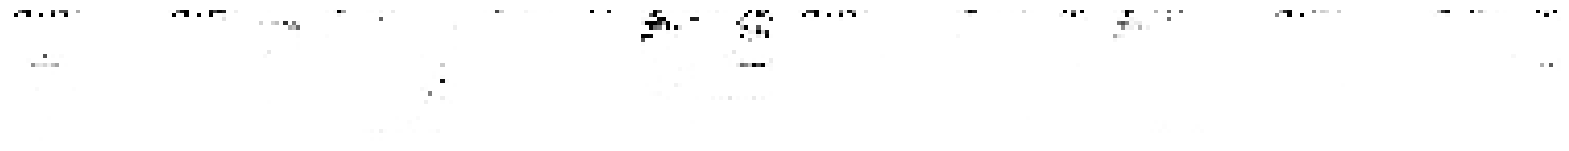

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step - c_gp: 0.0043 - c_loss: -0.0811 - c_wass_loss: -0.1239 - g_loss: -12.1829
Epoch 771/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - c_gp: 0.0044 - c_loss: -0.6929 - c_wass_loss: -0.7373 - g_loss: -11.7489
Epoch 772/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - c_gp: 0.0034 - c_loss: -0.4612 - c_wass_loss: -0.4952 - g_loss: -10.9463
Epoch 773/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - c_gp: 0.0041 - c_loss: -0.3420 - c_wass_loss: -0.3830 - g_loss: -10.6673
Epoch 774/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - c_gp: 0.0044 - c_loss: -0.2661 - c_wass_loss: -0.3098 - g_loss: -8.6980
Epoch 775/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - c_gp: 0.0051 - c_loss: -0.4646 - c_wass_loss: -0.5153 - g_loss: -7.7028
Saved to ./output/generated_img_774.png


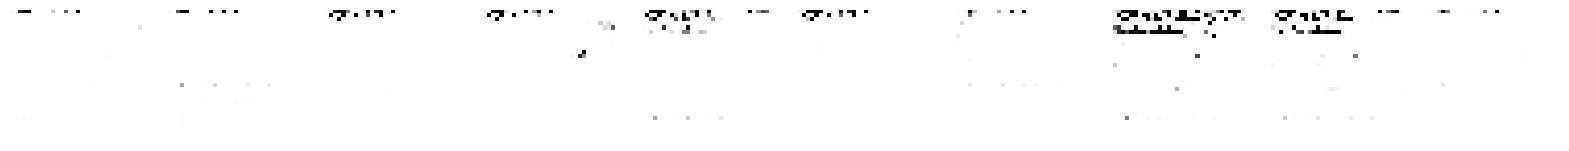

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step - c_gp: 0.0060 - c_loss: -0.5900 - c_wass_loss: -0.6502 - g_loss: -7.6111
Epoch 776/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0052 - c_loss: -0.3838 - c_wass_loss: -0.4363 - g_loss: -7.9069
Epoch 777/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - c_gp: 0.0044 - c_loss: -0.3153 - c_wass_loss: -0.3596 - g_loss: -8.4993
Epoch 778/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - c_gp: 0.0042 - c_loss: -0.6387 - c_wass_loss: -0.6803 - g_loss: -10.0861
Epoch 779/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0040 - c_loss: -0.4229 - c_wass_loss: -0.4628 - g_loss: -11.6518
Epoch 780/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - c_gp: 0.0049 - c_loss: -0.5376 - c_wass_loss: -0.5870 - g_loss: -12.5976
Saved to ./output/generated_img_779.png


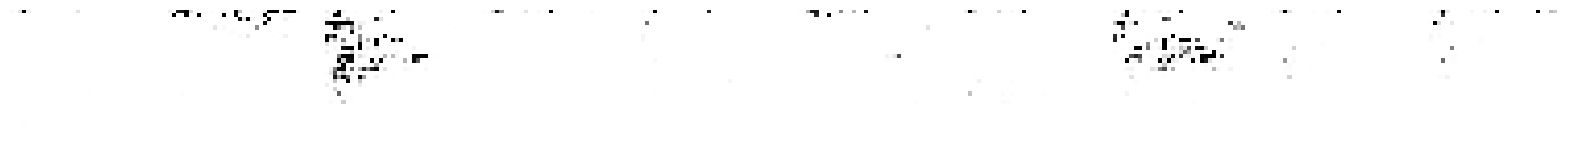

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step - c_gp: 0.0048 - c_loss: -0.6448 - c_wass_loss: -0.6931 - g_loss: -12.8521
Epoch 781/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0042 - c_loss: -0.4639 - c_wass_loss: -0.5060 - g_loss: -14.2667
Epoch 782/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - c_gp: 0.0042 - c_loss: -0.2039 - c_wass_loss: -0.2454 - g_loss: -13.7698
Epoch 783/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - c_gp: 0.0055 - c_loss: -0.1932 - c_wass_loss: -0.2478 - g_loss: -12.8818
Epoch 784/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - c_gp: 0.0045 - c_loss: -0.2516 - c_wass_loss: -0.2966 - g_loss: -12.9136
Epoch 785/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_gp: 0.0038 - c_loss: -0.6405 - c_wass_loss: -0.6786 - g_loss: -12.7332
Saved to ./output/generated_img_784.png


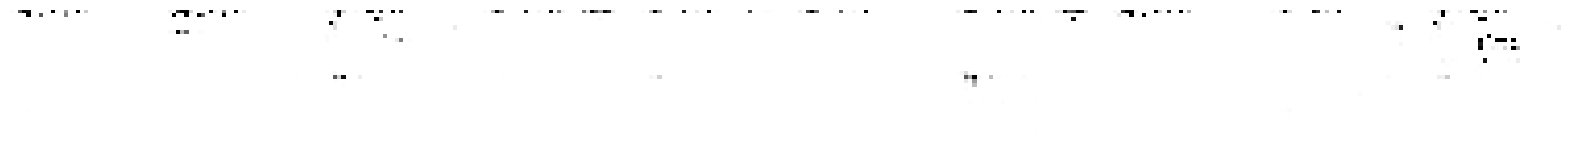

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step - c_gp: 0.0038 - c_loss: -0.6687 - c_wass_loss: -0.7065 - g_loss: -13.2103
Epoch 786/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - c_gp: 0.0052 - c_loss: -0.6068 - c_wass_loss: -0.6587 - g_loss: -14.6854
Epoch 787/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - c_gp: 0.0040 - c_loss: -0.6053 - c_wass_loss: -0.6449 - g_loss: -14.0433
Epoch 788/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - c_gp: 0.0046 - c_loss: -0.7677 - c_wass_loss: -0.8137 - g_loss: -13.1405
Epoch 789/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0048 - c_loss: -0.4330 - c_wass_loss: -0.4811 - g_loss: -11.0472
Epoch 790/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - c_gp: 0.0041 - c_loss: -0.9216 - c_wass_loss: -0.9629 - g_loss: -9.6011
Saved to ./output/generated_img_789.png


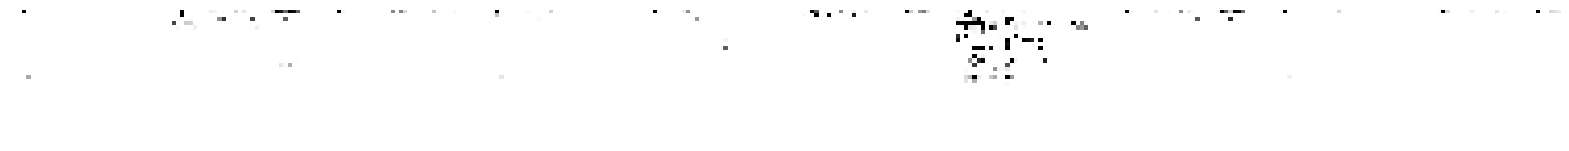

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 714ms/step - c_gp: 0.0046 - c_loss: -0.8072 - c_wass_loss: -0.8533 - g_loss: -9.4603
Epoch 791/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - c_gp: 0.0054 - c_loss: -0.5797 - c_wass_loss: -0.6338 - g_loss: -8.3674
Epoch 792/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0046 - c_loss: -1.1802 - c_wass_loss: -1.2259 - g_loss: -7.6252
Epoch 793/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - c_gp: 0.0038 - c_loss: -0.4027 - c_wass_loss: -0.4406 - g_loss: -6.1530
Epoch 794/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0049 - c_loss: -0.4929 - c_wass_loss: -0.5417 - g_loss: -7.8677
Epoch 795/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - c_gp: 0.0056 - c_loss: -0.7701 - c_wass_loss: -0.8258 - g_loss: -8.6432
Saved to ./output/generated_img_794.png


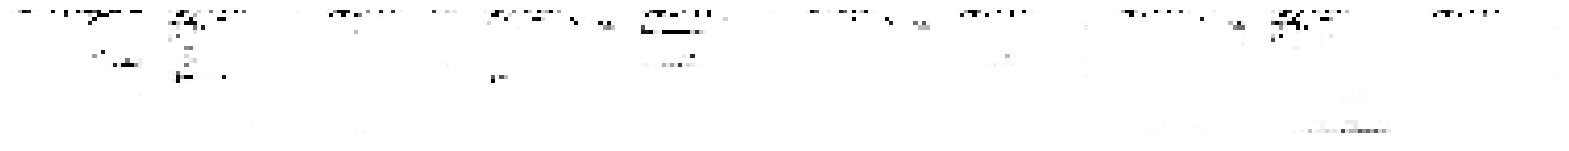

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 722ms/step - c_gp: 0.0052 - c_loss: -0.7389 - c_wass_loss: -0.7905 - g_loss: -8.9314
Epoch 796/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - c_gp: 0.0058 - c_loss: -0.6458 - c_wass_loss: -0.7040 - g_loss: -10.4850
Epoch 797/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - c_gp: 0.0048 - c_loss: -0.3578 - c_wass_loss: -0.4053 - g_loss: -10.6517
Epoch 798/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - c_gp: 0.0041 - c_loss: -0.4928 - c_wass_loss: -0.5343 - g_loss: -11.1088
Epoch 799/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0048 - c_loss: -0.8715 - c_wass_loss: -0.9199 - g_loss: -9.9502
Epoch 800/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - c_gp: 0.0042 - c_loss: -0.4603 - c_wass_loss: -0.5023 - g_loss: -9.9504
Saved to ./output/generated_img_799.png


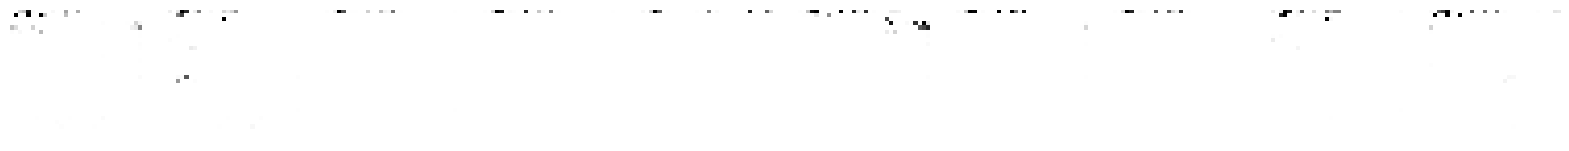

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 703ms/step - c_gp: 0.0042 - c_loss: -0.4282 - c_wass_loss: -0.4699 - g_loss: -10.0365
Epoch 801/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.0035 - c_loss: -0.4666 - c_wass_loss: -0.5013 - g_loss: -7.9052
Epoch 802/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - c_gp: 0.0035 - c_loss: -0.4594 - c_wass_loss: -0.4947 - g_loss: -6.3494
Epoch 803/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - c_gp: 0.0045 - c_loss: -0.7026 - c_wass_loss: -0.7472 - g_loss: -5.8391
Epoch 804/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - c_gp: 0.0062 - c_loss: -0.8042 - c_wass_loss: -0.8665 - g_loss: -6.0547
Epoch 805/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - c_gp: 0.0061 - c_loss: -0.3452 - c_wass_loss: -0.4067 - g_loss: -7.2044
Saved to ./output/generated_img_804.png


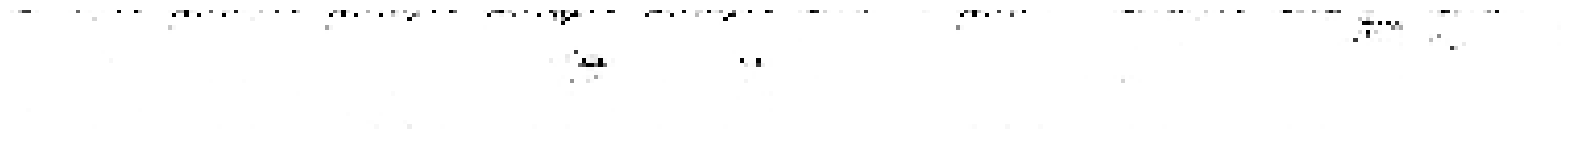

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step - c_gp: 0.0059 - c_loss: -0.1601 - c_wass_loss: -0.2192 - g_loss: -7.8387
Epoch 806/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - c_gp: 0.0065 - c_loss: -0.8775 - c_wass_loss: -0.9425 - g_loss: -10.1783
Epoch 807/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - c_gp: 0.0053 - c_loss: -0.7714 - c_wass_loss: -0.8244 - g_loss: -12.3186
Epoch 808/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - c_gp: 0.0061 - c_loss: -0.7647 - c_wass_loss: -0.8253 - g_loss: -14.0478
Epoch 809/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step - c_gp: 0.0057 - c_loss: -0.7937 - c_wass_loss: -0.8511 - g_loss: -14.2887
Epoch 810/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - c_gp: 0.0045 - c_loss: -0.5615 - c_wass_loss: -0.6066 - g_loss: -13.1345
Saved to ./output/generated_img_809.png


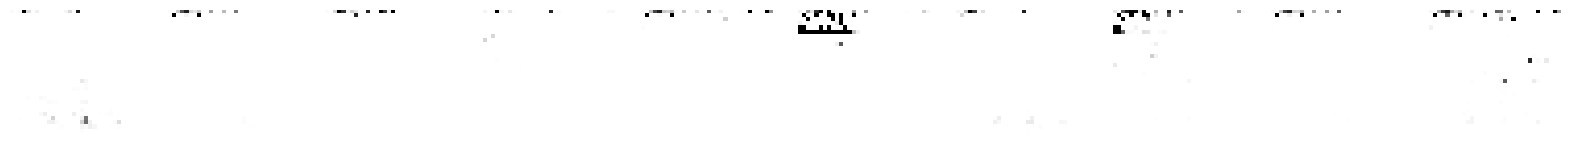

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 763ms/step - c_gp: 0.0046 - c_loss: -0.6910 - c_wass_loss: -0.7367 - g_loss: -13.2757
Epoch 811/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - c_gp: 0.0043 - c_loss: -0.3704 - c_wass_loss: -0.4130 - g_loss: -12.4407
Epoch 812/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - c_gp: 0.0042 - c_loss: 0.0691 - c_wass_loss: 0.0270 - g_loss: -11.4926  
Epoch 813/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step - c_gp: 0.0037 - c_loss: -0.5157 - c_wass_loss: -0.5522 - g_loss: -10.5066
Epoch 814/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - c_gp: 0.0044 - c_loss: -0.3907 - c_wass_loss: -0.4342 - g_loss: -9.8624
Epoch 815/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - c_gp: 0.0043 - c_loss: -0.8130 - c_wass_loss: -0.8564 - g_loss: -10.1955
Saved to ./output/generated_img_814.png


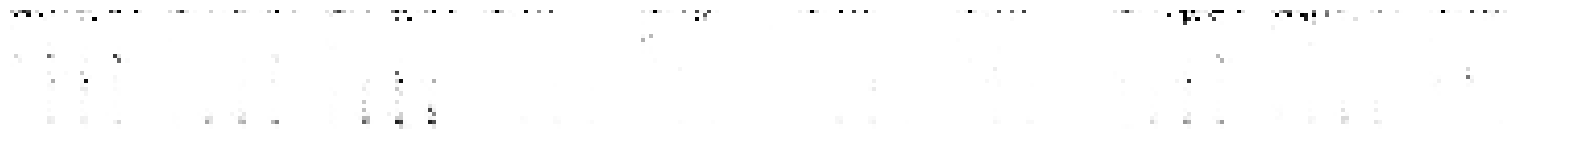

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 824ms/step - c_gp: 0.0047 - c_loss: -0.8964 - c_wass_loss: -0.9433 - g_loss: -10.4354
Epoch 816/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 610ms/step - c_gp: 0.0050 - c_loss: -0.4759 - c_wass_loss: -0.5259 - g_loss: -10.0473
Epoch 817/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - c_gp: 0.0064 - c_loss: -0.5066 - c_wass_loss: -0.5710 - g_loss: -10.3976
Epoch 818/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - c_gp: 0.0047 - c_loss: -0.6215 - c_wass_loss: -0.6689 - g_loss: -10.6826
Epoch 819/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - c_gp: 0.0048 - c_loss: -0.3890 - c_wass_loss: -0.4372 - g_loss: -11.1552
Epoch 820/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - c_gp: 0.0048 - c_loss: -0.4172 - c_wass_loss: -0.4654 - g_loss: -11.4807
Saved to ./output/generated_img_819.png


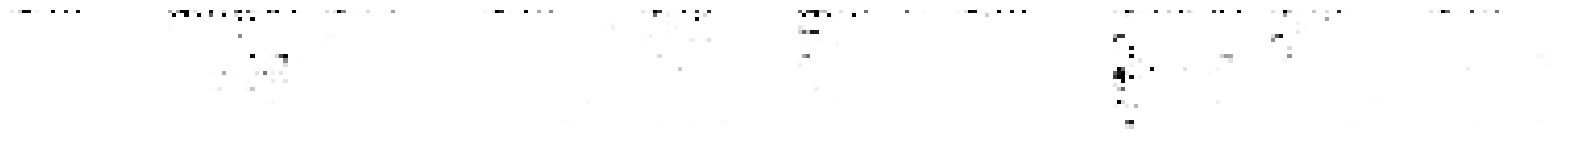

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 752ms/step - c_gp: 0.0050 - c_loss: -0.2639 - c_wass_loss: -0.3140 - g_loss: -11.3521
Epoch 821/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0043 - c_loss: -0.4619 - c_wass_loss: -0.5046 - g_loss: -11.0639
Epoch 822/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0036 - c_loss: -0.7625 - c_wass_loss: -0.7990 - g_loss: -10.6490
Epoch 823/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step - c_gp: 0.0044 - c_loss: 0.0456 - c_wass_loss: 0.0011 - g_loss: -10.4528  
Epoch 824/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0062 - c_loss: -0.6900 - c_wass_loss: -0.7523 - g_loss: -9.2612
Epoch 825/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - c_gp: 0.0046 - c_loss: -0.3980 - c_wass_loss: -0.4437 - g_loss: -9.0278
Saved to ./output/generated_img_824.png


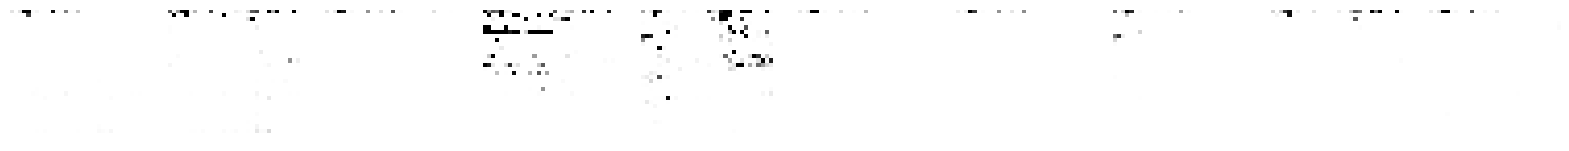

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step - c_gp: 0.0042 - c_loss: -0.4974 - c_wass_loss: -0.5390 - g_loss: -8.6566
Epoch 826/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step - c_gp: 0.0058 - c_loss: -0.3348 - c_wass_loss: -0.3928 - g_loss: -7.6291
Epoch 827/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0053 - c_loss: -0.6064 - c_wass_loss: -0.6594 - g_loss: -7.9695
Epoch 828/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0045 - c_loss: -0.5541 - c_wass_loss: -0.5994 - g_loss: -9.6866
Epoch 829/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0045 - c_loss: 0.2290 - c_wass_loss: 0.1841 - g_loss: -10.5184  
Epoch 830/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - c_gp: 0.0041 - c_loss: -0.9529 - c_wass_loss: -0.9940 - g_loss: -9.9854
Saved to ./output/generated_img_829.png


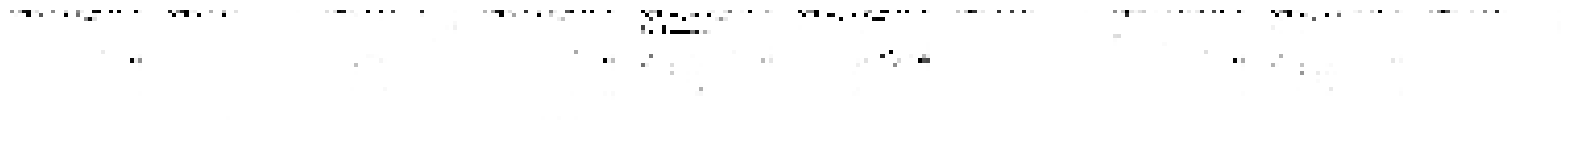

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 744ms/step - c_gp: 0.0038 - c_loss: -1.0468 - c_wass_loss: -1.0847 - g_loss: -10.2611
Epoch 831/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step - c_gp: 0.0042 - c_loss: -0.7259 - c_wass_loss: -0.7675 - g_loss: -10.3955
Epoch 832/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - c_gp: 0.0047 - c_loss: -0.5231 - c_wass_loss: -0.5701 - g_loss: -8.9519
Epoch 833/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - c_gp: 0.0045 - c_loss: -0.5341 - c_wass_loss: -0.5789 - g_loss: -8.3300
Epoch 834/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - c_gp: 0.0047 - c_loss: -1.2589 - c_wass_loss: -1.3063 - g_loss: -8.4629
Epoch 835/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - c_gp: 0.0061 - c_loss: -0.3958 - c_wass_loss: -0.4566 - g_loss: -9.9118
Saved to ./output/generated_img_834.png


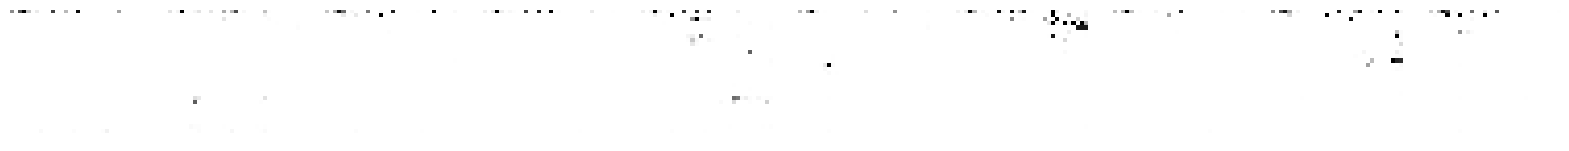

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - c_gp: 0.0068 - c_loss: -0.3728 - c_wass_loss: -0.4408 - g_loss: -9.6899
Epoch 836/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - c_gp: 0.0048 - c_loss: 0.1943 - c_wass_loss: 0.1458 - g_loss: -10.7099  
Epoch 837/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 589ms/step - c_gp: 0.0071 - c_loss: -0.3947 - c_wass_loss: -0.4655 - g_loss: -11.6373
Epoch 838/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - c_gp: 0.0063 - c_loss: -0.4882 - c_wass_loss: -0.5516 - g_loss: -11.5654
Epoch 839/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - c_gp: 0.0052 - c_loss: -0.5445 - c_wass_loss: -0.5960 - g_loss: -10.9429
Epoch 840/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - c_gp: 0.0052 - c_loss: -0.6687 - c_wass_loss: -0.7209 - g_loss: -9.6257
Saved to ./output/generated_img_839.png


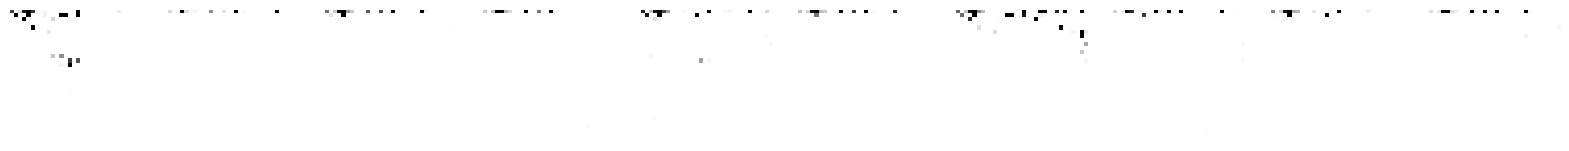

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step - c_gp: 0.0050 - c_loss: -0.7934 - c_wass_loss: -0.8433 - g_loss: -9.1319
Epoch 841/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - c_gp: 0.0040 - c_loss: -0.4692 - c_wass_loss: -0.5092 - g_loss: -7.3467
Epoch 842/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - c_gp: 0.0051 - c_loss: -0.6152 - c_wass_loss: -0.6664 - g_loss: -6.6062
Epoch 843/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - c_gp: 0.0063 - c_loss: -0.5131 - c_wass_loss: -0.5761 - g_loss: -5.9630
Epoch 844/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0057 - c_loss: -0.7336 - c_wass_loss: -0.7903 - g_loss: -6.4337
Epoch 845/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - c_gp: 0.0074 - c_loss: -0.7906 - c_wass_loss: -0.8646 - g_loss: -7.8223
Saved to ./output/generated_img_844.png


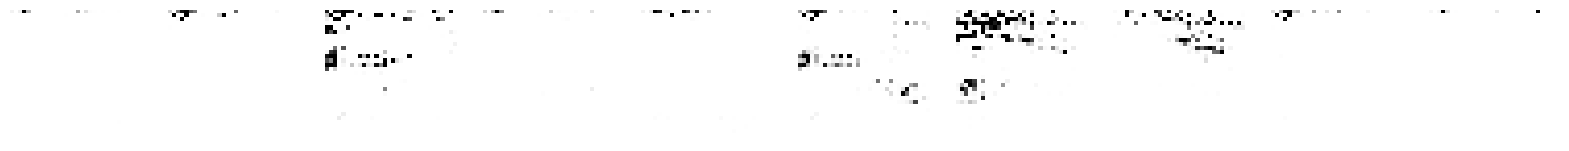

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step - c_gp: 0.0068 - c_loss: -0.8426 - c_wass_loss: -0.9107 - g_loss: -8.4910
Epoch 846/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0071 - c_loss: -0.4889 - c_wass_loss: -0.5594 - g_loss: -9.4834
Epoch 847/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - c_gp: 0.0060 - c_loss: -0.4685 - c_wass_loss: -0.5281 - g_loss: -8.9073
Epoch 848/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0055 - c_loss: -0.5600 - c_wass_loss: -0.6151 - g_loss: -9.5527
Epoch 849/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - c_gp: 0.0057 - c_loss: -0.6011 - c_wass_loss: -0.6583 - g_loss: -10.2343
Epoch 850/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - c_gp: 0.0041 - c_loss: 0.0474 - c_wass_loss: 0.0064 - g_loss: -9.8560
Saved to ./output/generated_img_849.png


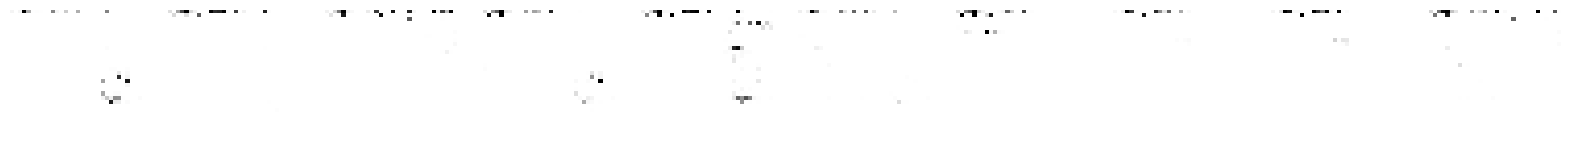

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 714ms/step - c_gp: 0.0041 - c_loss: 0.1506 - c_wass_loss: 0.1095 - g_loss: -9.5815
Epoch 851/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - c_gp: 0.0034 - c_loss: -0.4307 - c_wass_loss: -0.4645 - g_loss: -9.0109
Epoch 852/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - c_gp: 0.0042 - c_loss: -0.7141 - c_wass_loss: -0.7565 - g_loss: -9.5606
Epoch 853/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - c_gp: 0.0036 - c_loss: -0.4132 - c_wass_loss: -0.4494 - g_loss: -9.3322
Epoch 854/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - c_gp: 0.0047 - c_loss: -0.3656 - c_wass_loss: -0.4124 - g_loss: -8.6598
Epoch 855/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - c_gp: 0.0042 - c_loss: -0.4948 - c_wass_loss: -0.5372 - g_loss: -8.2151
Saved to ./output/generated_img_854.png


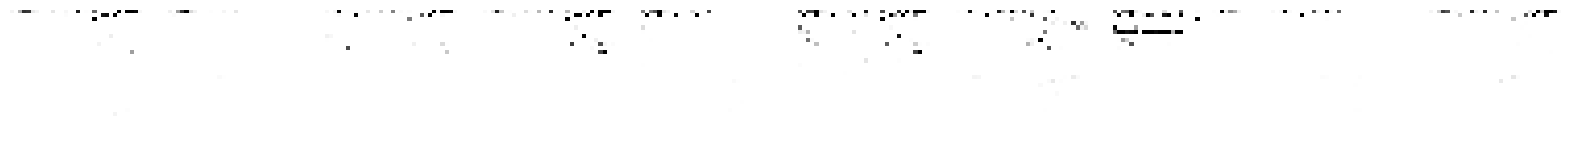

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step - c_gp: 0.0045 - c_loss: -0.6423 - c_wass_loss: -0.6874 - g_loss: -8.0879
Epoch 856/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0045 - c_loss: -0.9361 - c_wass_loss: -0.9816 - g_loss: -7.7266
Epoch 857/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - c_gp: 0.0034 - c_loss: -0.2927 - c_wass_loss: -0.3266 - g_loss: -6.6710
Epoch 858/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - c_gp: 0.0042 - c_loss: -0.6608 - c_wass_loss: -0.7024 - g_loss: -7.3199
Epoch 859/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - c_gp: 0.0036 - c_loss: 0.0601 - c_wass_loss: 0.0239 - g_loss: -6.8542  
Epoch 860/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - c_gp: 0.0049 - c_loss: -0.6778 - c_wass_loss: -0.7271 - g_loss: -6.2374
Saved to ./output/generated_img_859.png


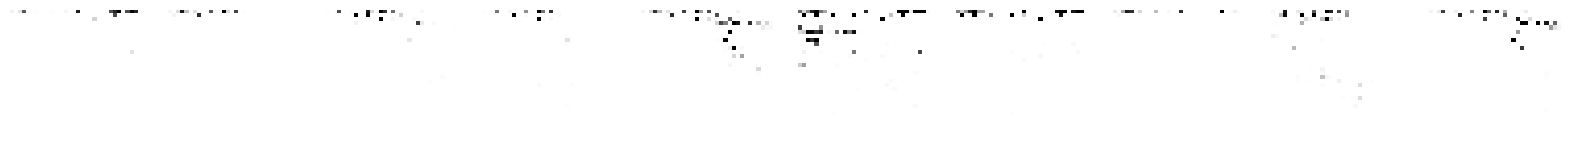

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 708ms/step - c_gp: 0.0057 - c_loss: -0.7419 - c_wass_loss: -0.7990 - g_loss: -6.3438
Epoch 861/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - c_gp: 0.0048 - c_loss: -0.8763 - c_wass_loss: -0.9243 - g_loss: -7.1682
Epoch 862/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0046 - c_loss: -0.2450 - c_wass_loss: -0.2914 - g_loss: -8.9515
Epoch 863/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - c_gp: 0.0050 - c_loss: 0.1998 - c_wass_loss: 0.1494 - g_loss: -9.8314  
Epoch 864/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - c_gp: 0.0054 - c_loss: -1.1176 - c_wass_loss: -1.1712 - g_loss: -9.4862
Epoch 865/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - c_gp: 0.0046 - c_loss: -0.3297 - c_wass_loss: -0.3755 - g_loss: -9.4093
Saved to ./output/generated_img_864.png


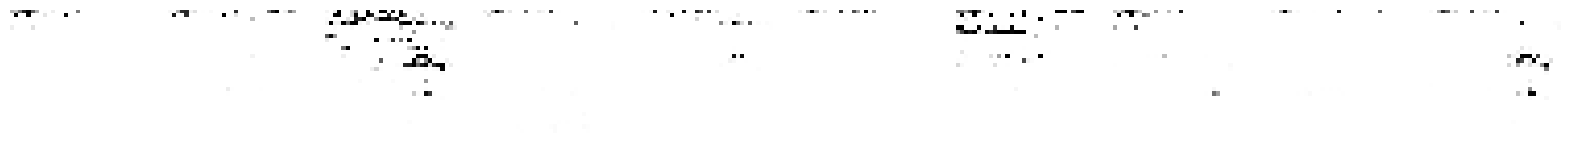

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step - c_gp: 0.0044 - c_loss: -0.4805 - c_wass_loss: -0.5242 - g_loss: -9.0881
Epoch 866/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - c_gp: 0.0042 - c_loss: 0.1406 - c_wass_loss: 0.0984 - g_loss: -7.8366  
Epoch 867/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - c_gp: 0.0040 - c_loss: -0.2879 - c_wass_loss: -0.3284 - g_loss: -6.0790
Epoch 868/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - c_gp: 0.0044 - c_loss: -0.6814 - c_wass_loss: -0.7249 - g_loss: -6.6049
Epoch 869/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - c_gp: 0.0042 - c_loss: -0.1199 - c_wass_loss: -0.1622 - g_loss: -7.7840
Epoch 870/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - c_gp: 0.0040 - c_loss: 0.0694 - c_wass_loss: 0.0295 - g_loss: -8.1285
Saved to ./output/generated_img_869.png


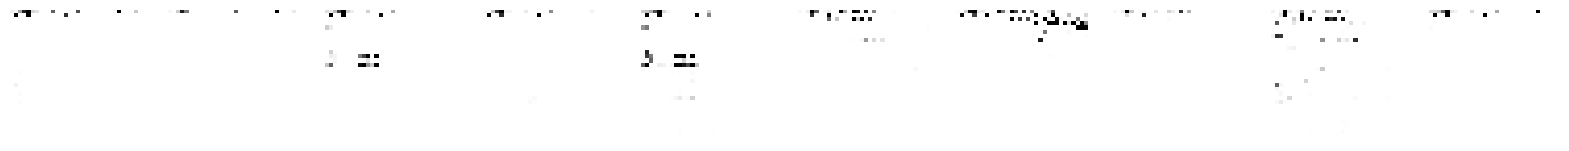

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step - c_gp: 0.0040 - c_loss: -0.0886 - c_wass_loss: -0.1282 - g_loss: -8.0606
Epoch 871/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - c_gp: 0.0048 - c_loss: -0.5584 - c_wass_loss: -0.6066 - g_loss: -8.3742
Epoch 872/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0043 - c_loss: -0.3513 - c_wass_loss: -0.3939 - g_loss: -8.8601
Epoch 873/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - c_gp: 0.0049 - c_loss: -0.6420 - c_wass_loss: -0.6913 - g_loss: -10.7030
Epoch 874/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 608ms/step - c_gp: 0.0042 - c_loss: -0.7488 - c_wass_loss: -0.7906 - g_loss: -12.2339
Epoch 875/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - c_gp: 0.0050 - c_loss: -0.4958 - c_wass_loss: -0.5463 - g_loss: -12.7888
Saved to ./output/generated_img_874.png


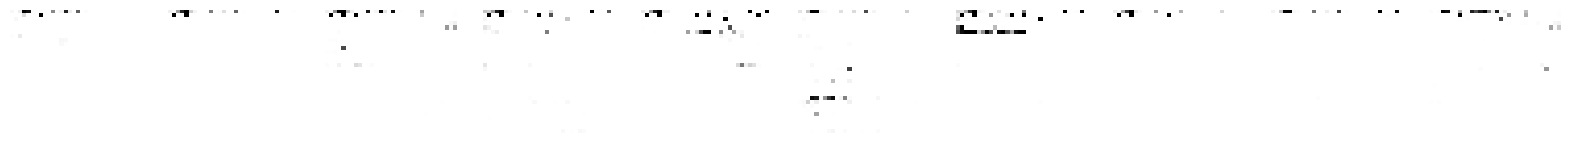

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 704ms/step - c_gp: 0.0056 - c_loss: -0.6402 - c_wass_loss: -0.6960 - g_loss: -12.9102
Epoch 876/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - c_gp: 0.0052 - c_loss: -0.3657 - c_wass_loss: -0.4175 - g_loss: -13.5345
Epoch 877/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - c_gp: 0.0057 - c_loss: -0.7693 - c_wass_loss: -0.8261 - g_loss: -11.9169
Epoch 878/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - c_gp: 0.0041 - c_loss: -0.5444 - c_wass_loss: -0.5857 - g_loss: -10.7070
Epoch 879/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0053 - c_loss: -0.4403 - c_wass_loss: -0.4933 - g_loss: -8.1865
Epoch 880/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - c_gp: 0.0053 - c_loss: -0.5489 - c_wass_loss: -0.6017 - g_loss: -5.4789
Saved to ./output/generated_img_879.png


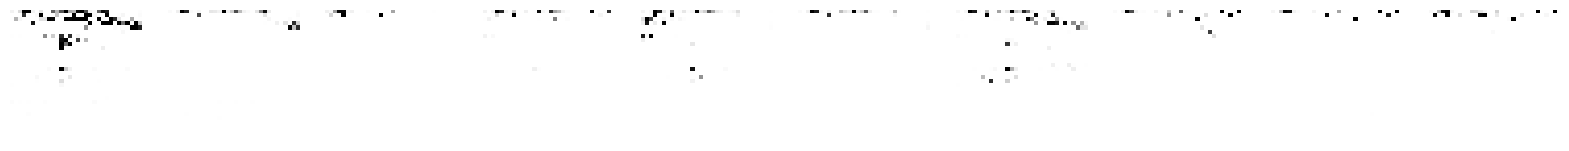

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 782ms/step - c_gp: 0.0054 - c_loss: -0.8143 - c_wass_loss: -0.8682 - g_loss: -5.2422
Epoch 881/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step - c_gp: 0.0057 - c_loss: -0.5714 - c_wass_loss: -0.6284 - g_loss: -5.7464
Epoch 882/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - c_gp: 0.0055 - c_loss: -0.4176 - c_wass_loss: -0.4729 - g_loss: -7.7068
Epoch 883/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.0063 - c_loss: -0.3998 - c_wass_loss: -0.4628 - g_loss: -9.8792
Epoch 884/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - c_gp: 0.0051 - c_loss: -0.9512 - c_wass_loss: -1.0021 - g_loss: -10.5550
Epoch 885/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - c_gp: 0.0050 - c_loss: -0.5374 - c_wass_loss: -0.5876 - g_loss: -11.8704
Saved to ./output/generated_img_884.png


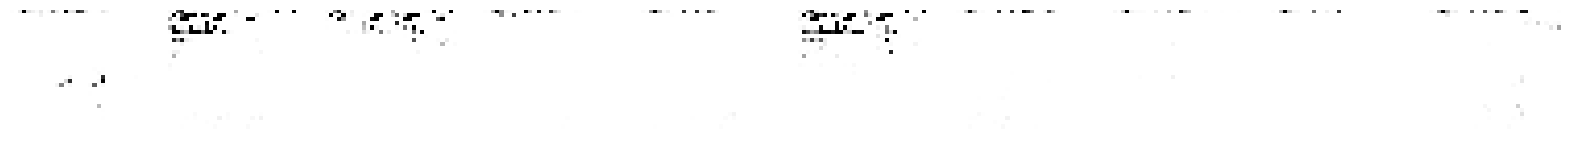

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - c_gp: 0.0053 - c_loss: -0.7025 - c_wass_loss: -0.7559 - g_loss: -12.1242
Epoch 886/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - c_gp: 0.0045 - c_loss: -0.6091 - c_wass_loss: -0.6545 - g_loss: -12.8015
Epoch 887/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - c_gp: 0.0041 - c_loss: -0.7352 - c_wass_loss: -0.7759 - g_loss: -12.5374
Epoch 888/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - c_gp: 0.0041 - c_loss: 0.1684 - c_wass_loss: 0.1275 - g_loss: -11.0718  
Epoch 889/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - c_gp: 0.0056 - c_loss: 0.2378 - c_wass_loss: 0.1819 - g_loss: -10.2922
Epoch 890/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - c_gp: 0.0050 - c_loss: -0.5050 - c_wass_loss: -0.5550 - g_loss: -8.5502
Saved to ./output/generated_img_889.png


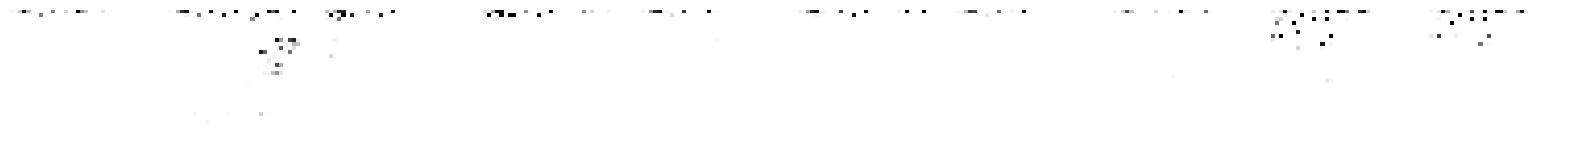

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 748ms/step - c_gp: 0.0052 - c_loss: -0.3859 - c_wass_loss: -0.4384 - g_loss: -8.7956
Epoch 891/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - c_gp: 0.0059 - c_loss: -0.5278 - c_wass_loss: -0.5869 - g_loss: -9.5396
Epoch 892/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - c_gp: 0.0050 - c_loss: -1.0889 - c_wass_loss: -1.1386 - g_loss: -9.6426
Epoch 893/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - c_gp: 0.0062 - c_loss: -1.1486 - c_wass_loss: -1.2110 - g_loss: -9.7870
Epoch 894/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - c_gp: 0.0062 - c_loss: -0.3206 - c_wass_loss: -0.3823 - g_loss: -9.1558
Epoch 895/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - c_gp: 0.0056 - c_loss: 0.1263 - c_wass_loss: 0.0705 - g_loss: -9.1297
Saved to ./output/generated_img_894.png


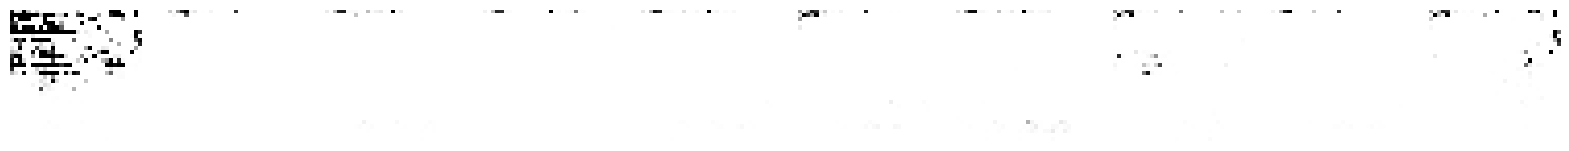

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - c_gp: 0.0052 - c_loss: 0.4296 - c_wass_loss: 0.3780 - g_loss: -9.1511
Epoch 896/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - c_gp: 0.0041 - c_loss: -0.8618 - c_wass_loss: -0.9028 - g_loss: -9.9071
Epoch 897/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - c_gp: 0.0043 - c_loss: -0.0770 - c_wass_loss: -0.1198 - g_loss: -9.3912
Epoch 898/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - c_gp: 0.0053 - c_loss: -0.7706 - c_wass_loss: -0.8234 - g_loss: -9.4721
Epoch 899/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - c_gp: 0.0075 - c_loss: -0.6733 - c_wass_loss: -0.7479 - g_loss: -9.8951 
Epoch 900/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_gp: 0.0061 - c_loss: -0.4502 - c_wass_loss: -0.5112 - g_loss: -9.0068
Saved to ./output/generated_img_899.png


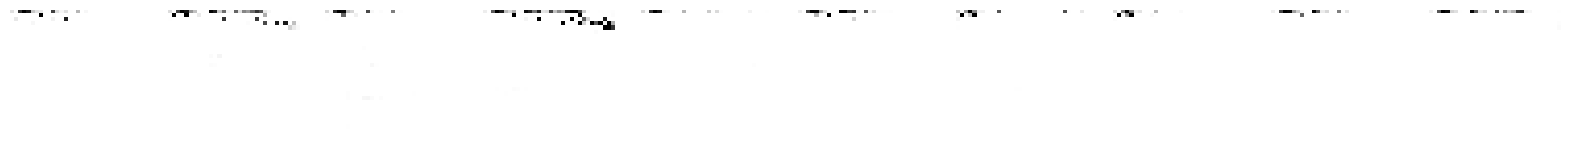

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step - c_gp: 0.0065 - c_loss: -0.4294 - c_wass_loss: -0.4948 - g_loss: -8.7228
Epoch 901/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step - c_gp: 0.0059 - c_loss: -0.4175 - c_wass_loss: -0.4770 - g_loss: -8.5322
Epoch 902/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - c_gp: 0.0057 - c_loss: -0.3411 - c_wass_loss: -0.3978 - g_loss: -10.2046
Epoch 903/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - c_gp: 0.0059 - c_loss: -0.3828 - c_wass_loss: -0.4421 - g_loss: -9.6608
Epoch 904/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - c_gp: 0.0057 - c_loss: -0.0782 - c_wass_loss: -0.1350 - g_loss: -9.4299
Epoch 905/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_gp: 0.0049 - c_loss: -0.2968 - c_wass_loss: -0.3454 - g_loss: -9.5166
Saved to ./output/generated_img_904.png


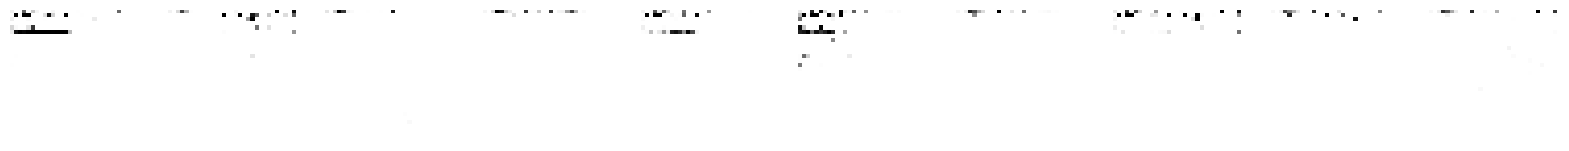

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 714ms/step - c_gp: 0.0047 - c_loss: -0.3658 - c_wass_loss: -0.4131 - g_loss: -9.7383
Epoch 906/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step - c_gp: 0.0042 - c_loss: -0.5508 - c_wass_loss: -0.5930 - g_loss: -9.2708
Epoch 907/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - c_gp: 0.0056 - c_loss: -0.4173 - c_wass_loss: -0.4734 - g_loss: -8.5721
Epoch 908/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - c_gp: 0.0048 - c_loss: -0.7635 - c_wass_loss: -0.8119 - g_loss: -7.8082
Epoch 909/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - c_gp: 0.0048 - c_loss: -0.5210 - c_wass_loss: -0.5694 - g_loss: -6.7464
Epoch 910/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - c_gp: 0.0056 - c_loss: -0.4092 - c_wass_loss: -0.4656 - g_loss: -6.4434
Saved to ./output/generated_img_909.png


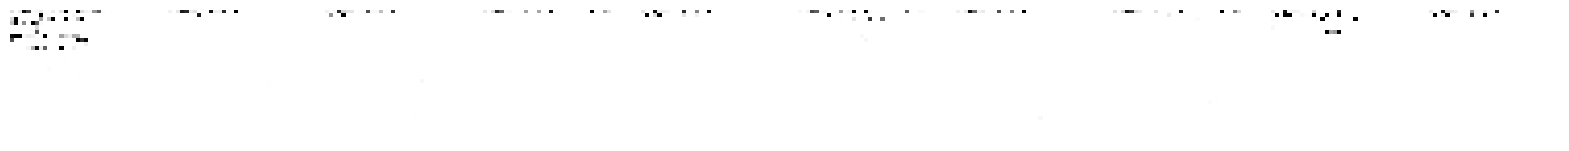

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 804ms/step - c_gp: 0.0056 - c_loss: -0.3160 - c_wass_loss: -0.3724 - g_loss: -6.5164
Epoch 911/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - c_gp: 0.0052 - c_loss: -0.8981 - c_wass_loss: -0.9506 - g_loss: -6.2905
Epoch 912/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - c_gp: 0.0056 - c_loss: -0.6238 - c_wass_loss: -0.6796 - g_loss: -6.9744
Epoch 913/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - c_gp: 0.0056 - c_loss: -0.1973 - c_wass_loss: -0.2529 - g_loss: -8.1205
Epoch 914/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0061 - c_loss: -1.0413 - c_wass_loss: -1.1023 - g_loss: -8.8519
Epoch 915/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - c_gp: 0.0051 - c_loss: -1.0079 - c_wass_loss: -1.0590 - g_loss: -9.8424
Saved to ./output/generated_img_914.png


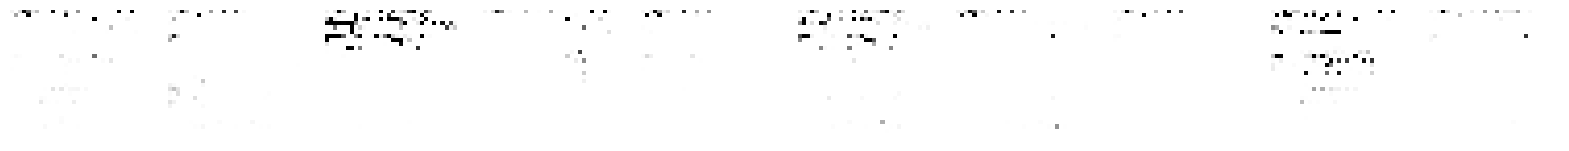

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step - c_gp: 0.0053 - c_loss: -1.1741 - c_wass_loss: -1.2267 - g_loss: -10.0392
Epoch 916/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0050 - c_loss: -0.7910 - c_wass_loss: -0.8408 - g_loss: -9.0966
Epoch 917/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step - c_gp: 0.0037 - c_loss: -0.1565 - c_wass_loss: -0.1937 - g_loss: -7.5170
Epoch 918/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - c_gp: 0.0039 - c_loss: -0.8997 - c_wass_loss: -0.9387 - g_loss: -6.8223
Epoch 919/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - c_gp: 0.0036 - c_loss: -0.1972 - c_wass_loss: -0.2336 - g_loss: -5.0494
Epoch 920/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - c_gp: 0.0042 - c_loss: -0.3346 - c_wass_loss: -0.3767 - g_loss: -4.9463
Saved to ./output/generated_img_919.png


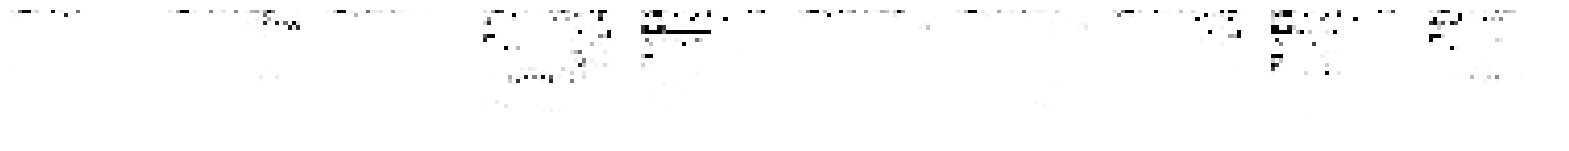

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step - c_gp: 0.0043 - c_loss: -0.3720 - c_wass_loss: -0.4148 - g_loss: -4.5001
Epoch 921/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0052 - c_loss: -1.1161 - c_wass_loss: -1.1685 - g_loss: -3.8909
Epoch 922/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - c_gp: 0.0044 - c_loss: -0.5511 - c_wass_loss: -0.5948 - g_loss: -5.0592
Epoch 923/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.0053 - c_loss: -0.4965 - c_wass_loss: -0.5494 - g_loss: -6.9276
Epoch 924/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - c_gp: 0.0041 - c_loss: -0.6297 - c_wass_loss: -0.6711 - g_loss: -8.6302
Epoch 925/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - c_gp: 0.0043 - c_loss: -0.7455 - c_wass_loss: -0.7887 - g_loss: -10.1734
Saved to ./output/generated_img_924.png


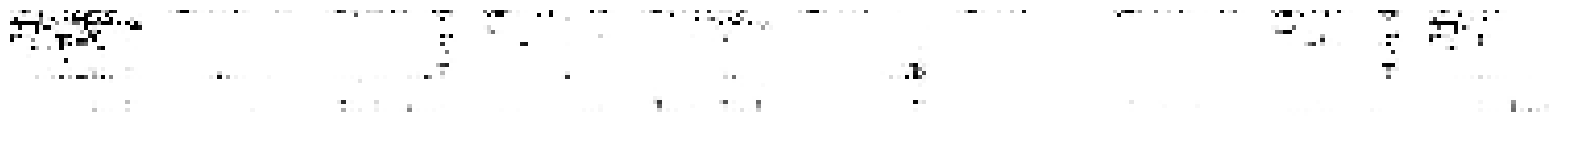

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 722ms/step - c_gp: 0.0043 - c_loss: -0.9299 - c_wass_loss: -0.9729 - g_loss: -10.2568
Epoch 926/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - c_gp: 0.0047 - c_loss: -0.5682 - c_wass_loss: -0.6154 - g_loss: -11.3080
Epoch 927/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - c_gp: 0.0040 - c_loss: -0.7846 - c_wass_loss: -0.8246 - g_loss: -11.8120
Epoch 928/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - c_gp: 0.0045 - c_loss: -0.4528 - c_wass_loss: -0.4978 - g_loss: -11.1325
Epoch 929/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step - c_gp: 0.0037 - c_loss: -0.7936 - c_wass_loss: -0.8308 - g_loss: -10.6206
Epoch 930/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - c_gp: 0.0038 - c_loss: -0.4744 - c_wass_loss: -0.5123 - g_loss: -9.2200
Saved to ./output/generated_img_929.png


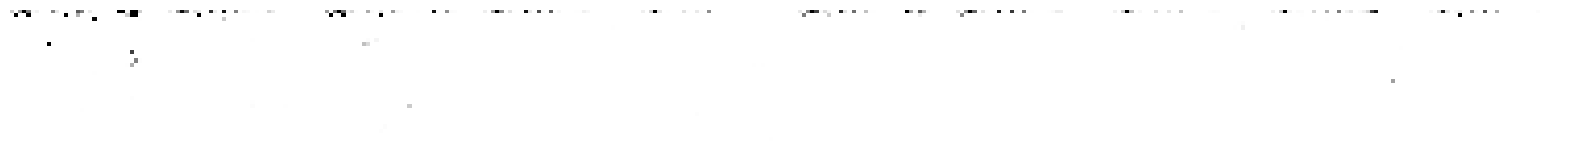

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step - c_gp: 0.0040 - c_loss: -0.5332 - c_wass_loss: -0.5731 - g_loss: -9.0638
Epoch 931/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - c_gp: 0.0043 - c_loss: -0.7711 - c_wass_loss: -0.8136 - g_loss: -7.7262
Epoch 932/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - c_gp: 0.0052 - c_loss: -0.8946 - c_wass_loss: -0.9466 - g_loss: -6.9276
Epoch 933/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - c_gp: 0.0051 - c_loss: -0.5770 - c_wass_loss: -0.6276 - g_loss: -6.5146
Epoch 934/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - c_gp: 0.0057 - c_loss: -0.4979 - c_wass_loss: -0.5551 - g_loss: -7.1699
Epoch 935/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - c_gp: 0.0049 - c_loss: -0.8538 - c_wass_loss: -0.9032 - g_loss: -7.6398
Saved to ./output/generated_img_934.png


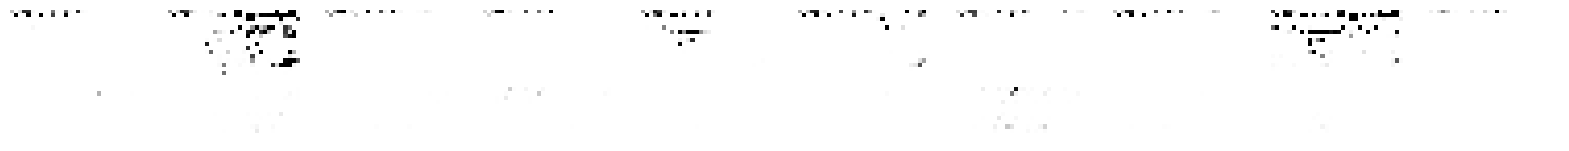

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 742ms/step - c_gp: 0.0050 - c_loss: -0.8543 - c_wass_loss: -0.9039 - g_loss: -7.6527
Epoch 936/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 748ms/step - c_gp: 0.0053 - c_loss: -0.3267 - c_wass_loss: -0.3798 - g_loss: -8.6049
Epoch 937/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - c_gp: 0.0085 - c_loss: 0.1405 - c_wass_loss: 0.0551 - g_loss: -11.3424  
Epoch 938/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - c_gp: 0.0058 - c_loss: -0.1952 - c_wass_loss: -0.2531 - g_loss: -12.3626
Epoch 939/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - c_gp: 0.0045 - c_loss: -0.3233 - c_wass_loss: -0.3686 - g_loss: -11.5435
Epoch 940/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - c_gp: 0.0045 - c_loss: -0.0806 - c_wass_loss: -0.1253 - g_loss: -11.0418
Saved to ./output/generated_img_939.png


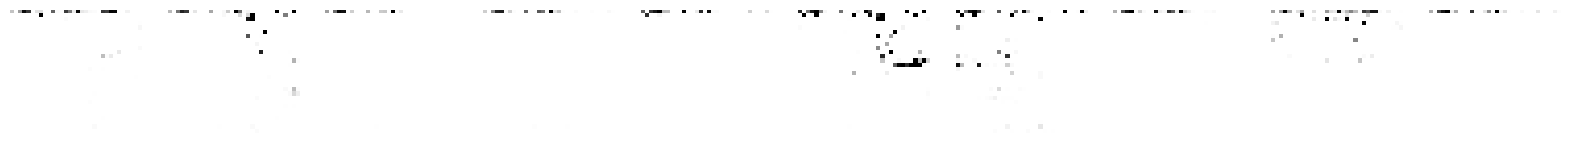

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step - c_gp: 0.0048 - c_loss: 0.0481 - c_wass_loss: 1.0109e-04 - g_loss: -10.6279
Epoch 941/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - c_gp: 0.0075 - c_loss: -0.3673 - c_wass_loss: -0.4424 - g_loss: -9.4735
Epoch 942/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - c_gp: 0.0051 - c_loss: -0.3314 - c_wass_loss: -0.3821 - g_loss: -7.7874
Epoch 943/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - c_gp: 0.0049 - c_loss: -0.7259 - c_wass_loss: -0.7747 - g_loss: -5.9855
Epoch 944/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - c_gp: 0.0048 - c_loss: -0.0783 - c_wass_loss: -0.1261 - g_loss: -5.8151
Epoch 945/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - c_gp: 0.0054 - c_loss: -0.4047 - c_wass_loss: -0.4589 - g_loss: -5.9924
Saved to ./output/generated_img_944.png


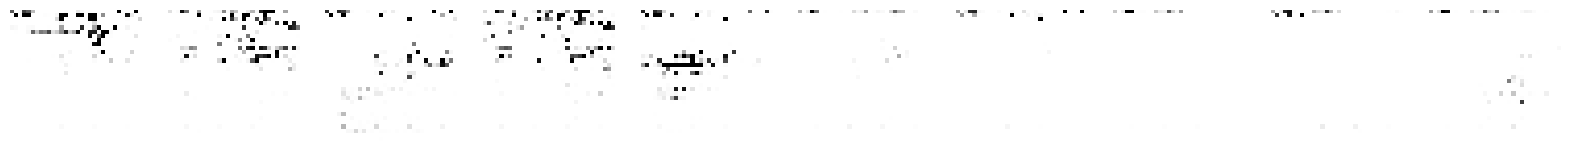

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step - c_gp: 0.0057 - c_loss: -0.2852 - c_wass_loss: -0.3426 - g_loss: -6.0086
Epoch 946/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - c_gp: 0.0059 - c_loss: -0.6228 - c_wass_loss: -0.6819 - g_loss: -6.6368
Epoch 947/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - c_gp: 0.0059 - c_loss: -0.0636 - c_wass_loss: -0.1228 - g_loss: -8.8047
Epoch 948/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 699ms/step - c_gp: 0.0054 - c_loss: -0.5998 - c_wass_loss: -0.6541 - g_loss: -10.4966
Epoch 949/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 603ms/step - c_gp: 0.0051 - c_loss: -0.8079 - c_wass_loss: -0.8586 - g_loss: -11.2735
Epoch 950/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - c_gp: 0.0042 - c_loss: -0.3304 - c_wass_loss: -0.3725 - g_loss: -9.8827
Saved to ./output/generated_img_949.png


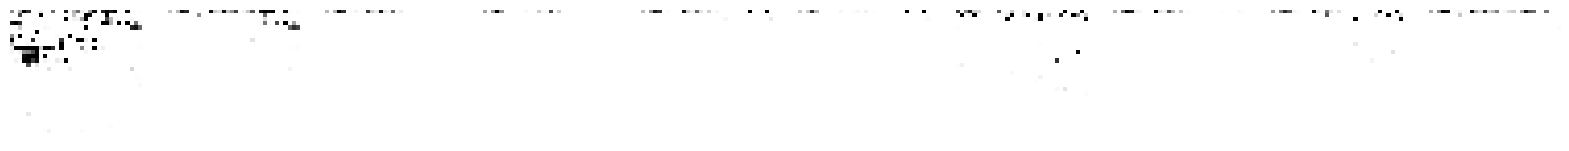

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 875ms/step - c_gp: 0.0039 - c_loss: -0.3897 - c_wass_loss: -0.4283 - g_loss: -9.5120
Epoch 951/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - c_gp: 0.0041 - c_loss: -1.0340 - c_wass_loss: -1.0753 - g_loss: -9.1708
Epoch 952/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - c_gp: 0.0039 - c_loss: -0.1691 - c_wass_loss: -0.2083 - g_loss: -8.9434
Epoch 953/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - c_gp: 0.0041 - c_loss: -0.3631 - c_wass_loss: -0.4041 - g_loss: -9.1267
Epoch 954/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - c_gp: 0.0044 - c_loss: -0.3893 - c_wass_loss: -0.4334 - g_loss: -8.5721
Epoch 955/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - c_gp: 0.0062 - c_loss: -0.6005 - c_wass_loss: -0.6624 - g_loss: -7.4884
Saved to ./output/generated_img_954.png


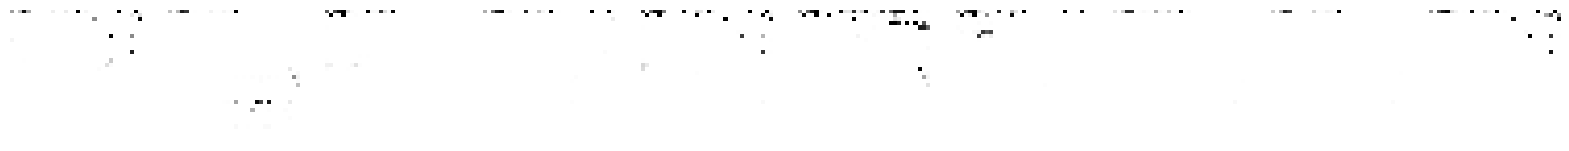

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 790ms/step - c_gp: 0.0067 - c_loss: -0.6442 - c_wass_loss: -0.7116 - g_loss: -7.3357
Epoch 956/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - c_gp: 0.0066 - c_loss: -0.7239 - c_wass_loss: -0.7901 - g_loss: -7.7902
Epoch 957/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step - c_gp: 0.0068 - c_loss: -0.9619 - c_wass_loss: -1.0298 - g_loss: -8.5659
Epoch 958/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - c_gp: 0.0061 - c_loss: -0.7320 - c_wass_loss: -0.7926 - g_loss: -8.7386
Epoch 959/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - c_gp: 0.0059 - c_loss: -0.8734 - c_wass_loss: -0.9329 - g_loss: -10.6373
Epoch 960/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - c_gp: 0.0052 - c_loss: -0.9237 - c_wass_loss: -0.9754 - g_loss: -13.3229
Saved to ./output/generated_img_959.png


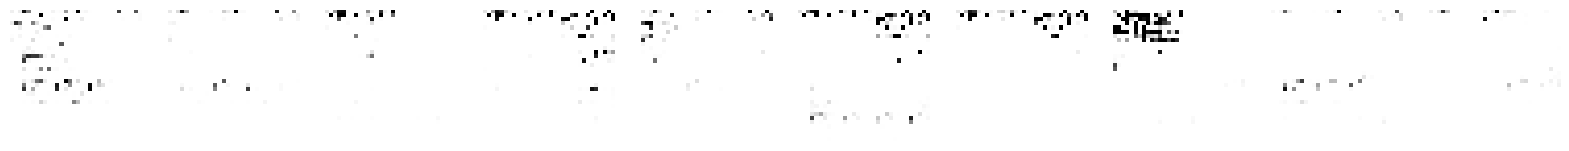

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step - c_gp: 0.0050 - c_loss: -1.0639 - c_wass_loss: -1.1141 - g_loss: -13.7789
Epoch 961/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step - c_gp: 0.0069 - c_loss: -0.3757 - c_wass_loss: -0.4443 - g_loss: -15.9476
Epoch 962/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - c_gp: 0.0061 - c_loss: -0.4081 - c_wass_loss: -0.4694 - g_loss: -15.8716
Epoch 963/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - c_gp: 0.0052 - c_loss: -0.3530 - c_wass_loss: -0.4050 - g_loss: -13.7283
Epoch 964/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0049 - c_loss: -0.4974 - c_wass_loss: -0.5465 - g_loss: -12.1184
Epoch 965/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - c_gp: 0.0059 - c_loss: -0.2744 - c_wass_loss: -0.3331 - g_loss: -10.8961
Saved to ./output/generated_img_964.png


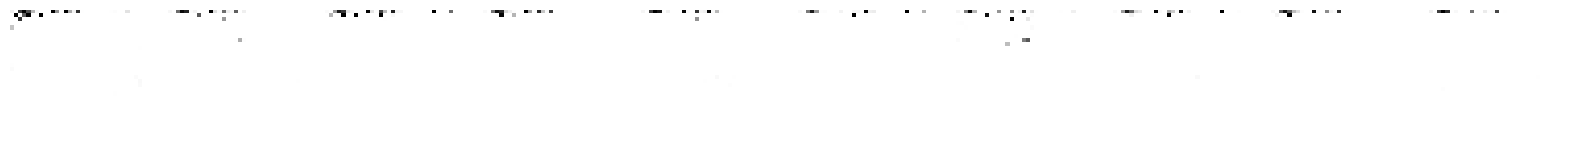

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step - c_gp: 0.0058 - c_loss: -0.2749 - c_wass_loss: -0.3326 - g_loss: -10.5263
Epoch 966/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - c_gp: 0.0068 - c_loss: -0.4558 - c_wass_loss: -0.5235 - g_loss: -9.6991
Epoch 967/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - c_gp: 0.0072 - c_loss: -0.6022 - c_wass_loss: -0.6742 - g_loss: -8.7984
Epoch 968/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - c_gp: 0.0079 - c_loss: -0.3134 - c_wass_loss: -0.3928 - g_loss: -8.7664
Epoch 969/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - c_gp: 0.0072 - c_loss: -0.7458 - c_wass_loss: -0.8183 - g_loss: -9.3101
Epoch 970/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - c_gp: 0.0086 - c_loss: -0.5879 - c_wass_loss: -0.6736 - g_loss: -10.3164
Saved to ./output/generated_img_969.png


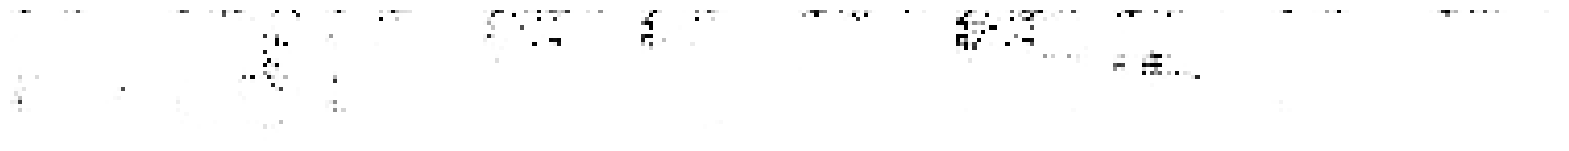

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 742ms/step - c_gp: 0.0087 - c_loss: -0.5916 - c_wass_loss: -0.6785 - g_loss: -10.4877
Epoch 971/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - c_gp: 0.0073 - c_loss: -0.3305 - c_wass_loss: -0.4036 - g_loss: -11.4946
Epoch 972/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - c_gp: 0.0074 - c_loss: -0.2986 - c_wass_loss: -0.3724 - g_loss: -11.5232
Epoch 973/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - c_gp: 0.0049 - c_loss: -0.5617 - c_wass_loss: -0.6110 - g_loss: -12.4514
Epoch 974/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - c_gp: 0.0051 - c_loss: -0.4929 - c_wass_loss: -0.5438 - g_loss: -12.1159
Epoch 975/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - c_gp: 0.0048 - c_loss: -0.2105 - c_wass_loss: -0.2582 - g_loss: -11.5859
Saved to ./output/generated_img_974.png


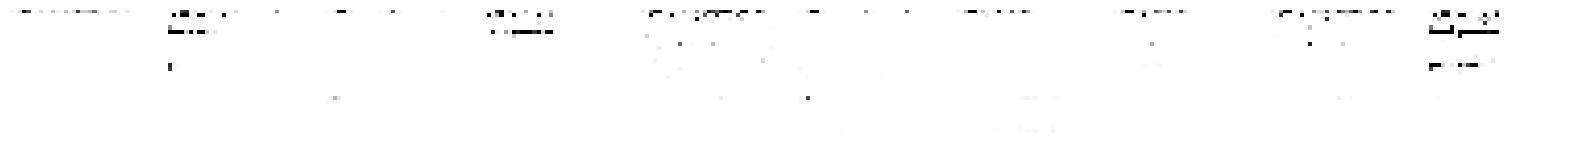

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 754ms/step - c_gp: 0.0050 - c_loss: -0.3528 - c_wass_loss: -0.4030 - g_loss: -11.6141
Epoch 976/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 575ms/step - c_gp: 0.0040 - c_loss: -0.6182 - c_wass_loss: -0.6580 - g_loss: -11.7142
Epoch 977/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.0047 - c_loss: -0.9992 - c_wass_loss: -1.0457 - g_loss: -11.7786
Epoch 978/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - c_gp: 0.0055 - c_loss: -0.4348 - c_wass_loss: -0.4901 - g_loss: -12.2028
Epoch 979/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - c_gp: 0.0056 - c_loss: -0.9548 - c_wass_loss: -1.0111 - g_loss: -10.5501
Epoch 980/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - c_gp: 0.0056 - c_loss: -0.3706 - c_wass_loss: -0.4271 - g_loss: -10.1367
Saved to ./output/generated_img_979.png


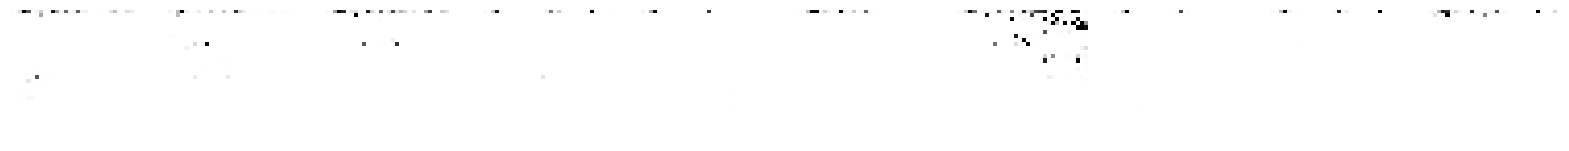

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step - c_gp: 0.0058 - c_loss: -0.4864 - c_wass_loss: -0.5440 - g_loss: -10.1160
Epoch 981/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - c_gp: 0.0064 - c_loss: -0.2652 - c_wass_loss: -0.3288 - g_loss: -8.3507
Epoch 982/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0054 - c_loss: -0.8247 - c_wass_loss: -0.8787 - g_loss: -8.3337
Epoch 983/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - c_gp: 0.0075 - c_loss: -0.3872 - c_wass_loss: -0.4625 - g_loss: -8.9746
Epoch 984/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - c_gp: 0.0052 - c_loss: -0.6202 - c_wass_loss: -0.6722 - g_loss: -9.9533
Epoch 985/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - c_gp: 0.0058 - c_loss: -0.3460 - c_wass_loss: -0.4043 - g_loss: -10.9566
Saved to ./output/generated_img_984.png


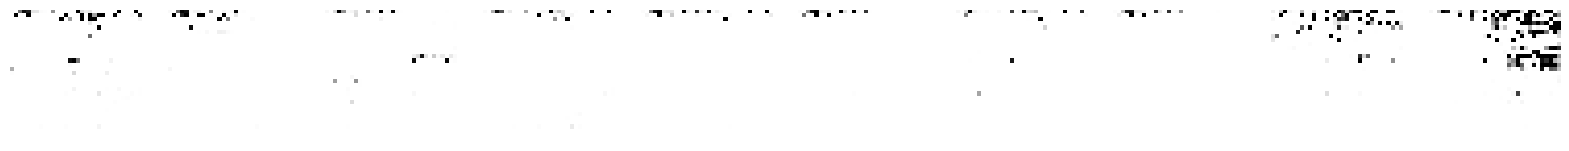

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 743ms/step - c_gp: 0.0058 - c_loss: -0.0211 - c_wass_loss: -0.0789 - g_loss: -11.0610
Epoch 986/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - c_gp: 0.0053 - c_loss: -0.7280 - c_wass_loss: -0.7813 - g_loss: -12.0447
Epoch 987/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - c_gp: 0.0051 - c_loss: -0.8163 - c_wass_loss: -0.8671 - g_loss: -11.7605
Epoch 988/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - c_gp: 0.0049 - c_loss: -0.7843 - c_wass_loss: -0.8337 - g_loss: -10.2305
Epoch 989/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - c_gp: 0.0050 - c_loss: -0.6029 - c_wass_loss: -0.6533 - g_loss: -10.3443
Epoch 990/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - c_gp: 0.0048 - c_loss: -0.4639 - c_wass_loss: -0.5116 - g_loss: -10.2448
Saved to ./output/generated_img_989.png


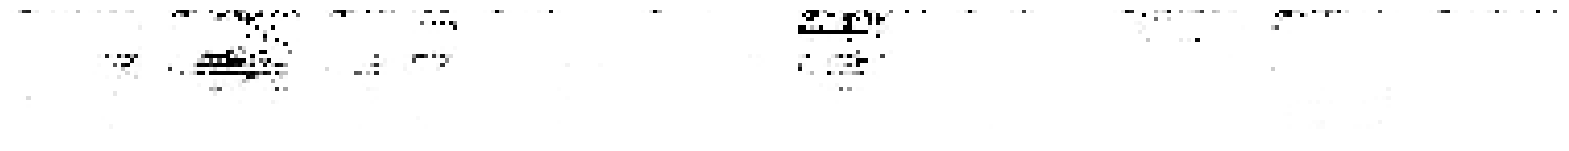

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 824ms/step - c_gp: 0.0047 - c_loss: -0.4294 - c_wass_loss: -0.4761 - g_loss: -10.3411
Epoch 991/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 872ms/step - c_gp: 0.0040 - c_loss: -0.4678 - c_wass_loss: -0.5081 - g_loss: -10.1668
Epoch 992/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - c_gp: 0.0043 - c_loss: -0.7522 - c_wass_loss: -0.7956 - g_loss: -10.7612
Epoch 993/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - c_gp: 0.0044 - c_loss: -0.2306 - c_wass_loss: -0.2746 - g_loss: -11.3656
Epoch 994/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - c_gp: 0.0061 - c_loss: -0.8526 - c_wass_loss: -0.9139 - g_loss: -11.2068
Epoch 995/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - c_gp: 0.0049 - c_loss: -0.6532 - c_wass_loss: -0.7024 - g_loss: -11.2797
Saved to ./output/generated_img_994.png


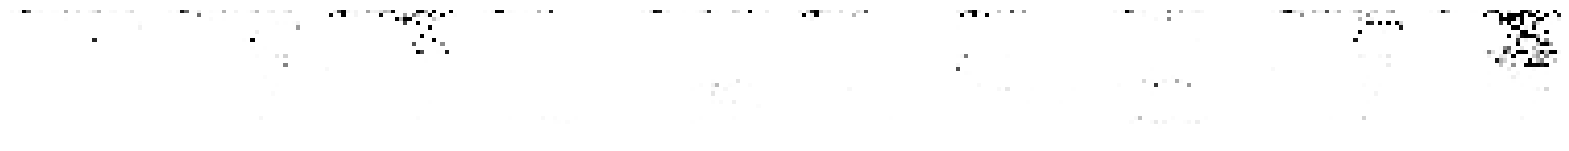

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step - c_gp: 0.0047 - c_loss: -0.8430 - c_wass_loss: -0.8903 - g_loss: -11.0058
Epoch 996/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - c_gp: 0.0043 - c_loss: -0.4617 - c_wass_loss: -0.5043 - g_loss: -11.1361
Epoch 997/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - c_gp: 0.0043 - c_loss: -1.3244 - c_wass_loss: -1.3677 - g_loss: -11.0030
Epoch 998/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - c_gp: 0.0058 - c_loss: -0.1703 - c_wass_loss: -0.2283 - g_loss: -11.1259
Epoch 999/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - c_gp: 0.0063 - c_loss: -0.1006 - c_wass_loss: -0.1633 - g_loss: -11.4510
Epoch 1000/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - c_gp: 0.0053 - c_loss: -0.5706 - c_wass_loss: -0.6234 - g_loss: -10.8400
Saved to ./output/generated_img_999.png


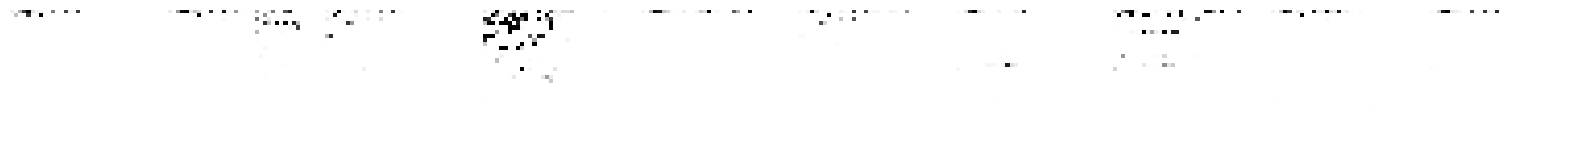

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 753ms/step - c_gp: 0.0051 - c_loss: -0.5048 - c_wass_loss: -0.5555 - g_loss: -11.1315


In [15]:
wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=2,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [16]:
# Save the final models
generator.save("./models/generator.keras")
critic.save("./models/critic.keras")

## Generate images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


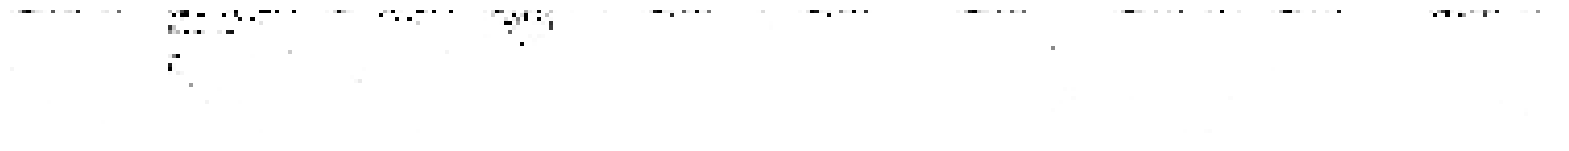

In [18]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap="gray_r")